<a href="https://colab.research.google.com/github/ocy0581/link_Jolssul/blob/master/python/CreateEVwithGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mediapipe

     |████████████████████████████████| 47.4MB 81kB/s 


In [2]:
import mediapipe as mp
import numpy as np
import time
import cv2

In [3]:
# Prepare DrawingSpec
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# Config holistic
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    min_detection_confidence=0.5, min_tracking_confidence=0.5)

# 영상 가져오기
cap = cv2.VideoCapture("/content/drive/MyDrive/Video/KETI_SL_0000006020.avi")

# 영상...
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# cap.set(cv2.CAP_PROP_FPS, 1)

total_frames = cap.get(7)
print(total_frames)

print(cap.get(cv2.CAP_PROP_FPS))

frame_rate = 10
prev = 0
i = 0
left_hand_lists = []
right_hand_lists = []
face_lists = []
pose_lists = []

def LandmarkToList(SourceLandmark, parts):
  DstList = []
  if (SourceLandmark):
    for coord in SourceLandmark.landmark:
      DstList.append([coord.x, coord.y, coord.z])
    return DstList
  else:
    if (parts == "hands"):
      for i in range(21):
        DstList.append([0,0,0])
    if (parts == "face"):
      for i in range(468):
        DstList.append([0,0,0])
    if (parts == "pose"):
      for i in range(33):
        DstList.append([0,0,0])
    return DstList

while cap.isOpened():
#     time_elapsed = time.time() - prev
    success, image = cap.read()

#     if time_elapsed > 1./frame_rate:
#         prev = time.time()
        
    if not success:
        print("Ignoring empty camera frame.")
        # If loading a video, use 'break' instead of 'continue'.
        break

    # Flip the image horizontally for a later selfie-view display, and convert
    # the BGR image to RGB.
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    results = holistic.process(image)

    # Draw landmark annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
      image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS)
    mp_drawing.draw_landmarks(
      image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(
      image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(
      image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    
    left_hand_lists.append(LandmarkToList(results.left_hand_landmarks,"hands"))
    right_hand_lists.append(LandmarkToList(results.right_hand_landmarks,"hands"))
    face_lists.append(LandmarkToList(results.face_landmarks,"face"))
    pose_lists.append(LandmarkToList(results.pose_landmarks,"pose"))
        
#     cv2.imshow('MediaPipe Holistic', image)
#     if cv2.waitKey(5) & 0xFF == ord('q'):
#         break
holistic.close()
cap.release()
cv2.destroyAllWindows()

156.0
29.970029
Ignoring empty camera frame.


In [4]:
import torch

In [5]:
LeftHandTensor = torch.FloatTensor(left_hand_lists)
RightHandTensor = torch.FloatTensor(right_hand_lists)
FaceTensor = torch.FloatTensor(face_lists)
poseTensor = torch.FloatTensor(pose_lists)

print(LeftHandTensor.shape, RightHandTensor.shape, FaceTensor.shape, poseTensor.shape)

torch.Size([156, 21, 3]) torch.Size([156, 21, 3]) torch.Size([156, 468, 3]) torch.Size([156, 33, 3])


## Edge Index 추출

In [ ]:
mp_holistic.HAND_CONNECTIONS

frozenset({(<HandLandmark.WRIST: 0>, <HandLandmark.THUMB_CMC: 1>),
           (<HandLandmark.WRIST: 0>, <HandLandmark.INDEX_FINGER_MCP: 5>),
           (<HandLandmark.WRIST: 0>, <HandLandmark.PINKY_MCP: 17>),
           (<HandLandmark.THUMB_CMC: 1>, <HandLandmark.THUMB_MCP: 2>),
           (<HandLandmark.THUMB_MCP: 2>, <HandLandmark.THUMB_IP: 3>),
           (<HandLandmark.THUMB_IP: 3>, <HandLandmark.THUMB_TIP: 4>),
           (<HandLandmark.INDEX_FINGER_MCP: 5>,
            <HandLandmark.INDEX_FINGER_PIP: 6>),
           (<HandLandmark.INDEX_FINGER_MCP: 5>,
            <HandLandmark.MIDDLE_FINGER_MCP: 9>),
           (<HandLandmark.INDEX_FINGER_PIP: 6>,
            <HandLandmark.INDEX_FINGER_DIP: 7>),
           (<HandLandmark.INDEX_FINGER_DIP: 7>,
            <HandLandmark.INDEX_FINGER_TIP: 8>),
           (<HandLandmark.MIDDLE_FINGER_MCP: 9>,
            <HandLandmark.MIDDLE_FINGER_PIP: 10>),
           (<HandLandmark.MIDDLE_FINGER_MCP: 9>,
            <HandLandmark.RING_FINGER_MCP:

In [6]:
def ConvertEdgeIndex(target,is_face = False):
  if (is_face == False): #Pose나 Hands이면
    EdgeIdx = [[x[0].value, x[1].value] for x in target]
  else: # Face이면
    EdgeIdx = [list(x) for x in target]
  EdgeIdx = sorted(EdgeIdx) #정렬
  reverse_edge_index = [list(reversed(x)) for x in EdgeIdx]
  #비방향성 그래프를 위해서 리스트를 뒤집어서 추가, ex) 0->1이 있으면 1->0도 존재해야함
  CreatedEdgeIndex = EdgeIdx + reverse_edge_index
  return sorted(CreatedEdgeIndex)

In [7]:
PoseEdgeIndex = ConvertEdgeIndex(mp_holistic.POSE_CONNECTIONS)
HandsEdgeIndex = ConvertEdgeIndex(mp_holistic.HAND_CONNECTIONS)
FaceEdgeIndex = ConvertEdgeIndex(mp_holistic.FACE_CONNECTIONS,is_face=True)
#Pose와 Hands와는 다른 형태

## 그래프 그리기 & GNN 활용 임베딩

In [8]:
#필요한 패키지 설치
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 9.5MB/s 
     |████████████████████████████████| 1.5MB 12.7MB/s 
     |████████████████████████████████| 194kB 10.6MB/s 
     |████████████████████████████████| 235kB 11.9MB/s 
     |████████████████████████████████| 2.2MB 35.4MB/s 
     |████████████████████████████████| 51kB 2.4MB/s 


In [9]:
from torch_geometric.data import Data

In [11]:
LeftHandEdgeTensor = torch.LongTensor(HandsEdgeIndex)
#엣지 인덱스는 LongTensor여야 함!

In [13]:
LeftHandEdgeTensor.dtype
#타입 확인

torch.int64

In [16]:
TransposedHandEdge = torch.transpose(LeftHandEdgeTensor,0,1)
#한번 Transpose 시켜줌, Edge index의 shape은 2,node 여야함

In [17]:
TransposedHandEdge.shape

torch.Size([2, 42])

In [19]:
# 첫 번째 접근, 각 노드를 클래스로 생각, 즉 33개의 노드 == 33개의 클래스
HandY = torch.LongTensor([i for i in range(LeftHandTensor.shape[1])])
PoseY = torch.LongTensor([i for i in range(poseTensor.shape[1])])
FaceY = torch.LongTensor([i for i in range(FaceTensor.shape[1])])

In [20]:
#train_mask, 일단은 모든 노드를 train에 활용
HandTrainMask = torch.BoolTensor([True]*LeftHandTensor.shape[1])
PoseTrainMask = torch.BoolTensor([True]*poseTensor.shape[1])
FaceTrainMask = torch.BoolTensor([True]*FaceTensor.shape[1])

In [22]:
#추가적인 edge_index 생성
PoseEdgeIndexTensor = torch.LongTensor(PoseEdgeIndex)
FaceEdgeIndexTensor = torch.LongTensor(FaceEdgeIndex)
TransPosedPoseEdge = torch.transpose(PoseEdgeIndexTensor,0,1)
TransPosedFaceEdge = torch.transpose(FaceEdgeIndexTensor,0,1)

In [28]:
#임의의 한 프레임에서 그래프를 추출
#데이터를 그려주고 활용하기 위해서 pytorch geometric의 Data를 활용해 Data object를 생성
LeftHandData = Data(x=LeftHandTensor[100],edge_index=TransposedHandEdge,y=HandY, train_mask = HandTrainMask)
RightHandData = Data(x=RightHandTensor[100],edge_index=TransposedHandEdge,y=HandY, train_mask = HandTrainMask)
PoseData = Data(x=poseTensor[100],edge_index=TransPosedPoseEdge, y=PoseY, train_mask = PoseTrainMask)
FaceData = Data(x=FaceTensor[100],edge_index=TransPosedFaceEdge, y=FaceY, train_mask=FaceTrainMask)

In [29]:
from torch_geometric.utils import to_networkx

In [30]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

In [35]:
def visualize(h, color="red", epoch=None, loss=None): #그래프를 matplotlib을 활용하여 출력하는 함수
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [36]:
LeftHandG = to_networkx(LeftHandData, to_undirected=True)
RightHandG = to_networkx(RightHandData, to_undirected=True)
PoseG = to_networkx(PoseData,to_undirected=True)
FaceG = to_networkx(FaceData, to_undirected=True)

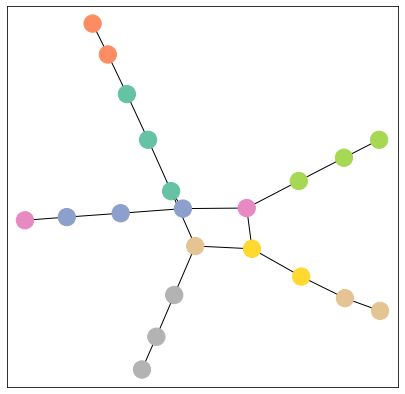

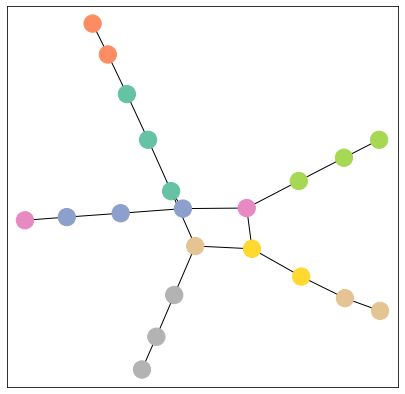

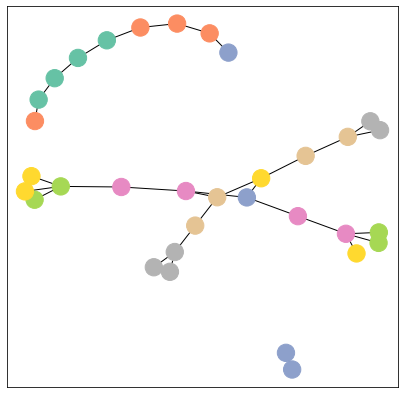

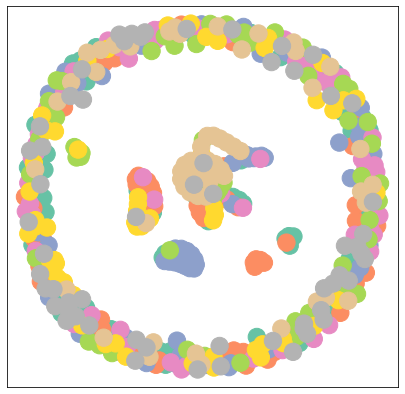

In [38]:
#Graph Visualize
visualize(LeftHandG,color=LeftHandData.y)
visualize(RightHandG,color=RightHandData.y)
visualize(PoseG,color=PoseData.y)
visualize(FaceG,color=FaceData.y)

## GCN 모델 생성

In [46]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

num_features = 3

class GCN(torch.nn.Module):
    def __init__(self,parts):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, 256)
        self.conv2 = GCNConv(256, 128)
        self.conv3 = GCNConv(128, 64)
        self.conv4 = GCNConv(64, 64)
        self.classifier = Linear(64,parts.shape[1])

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        h = self.conv4(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN(LeftHandTensor)
print(model)

GCN(
  (conv1): GCNConv(3, 256)
  (conv2): GCNConv(256, 128)
  (conv3): GCNConv(128, 64)
  (conv4): GCNConv(64, 64)
  (classifier): Linear(in_features=64, out_features=21, bias=True)
)


### LeftHand

Embedding shape: [21, 64]


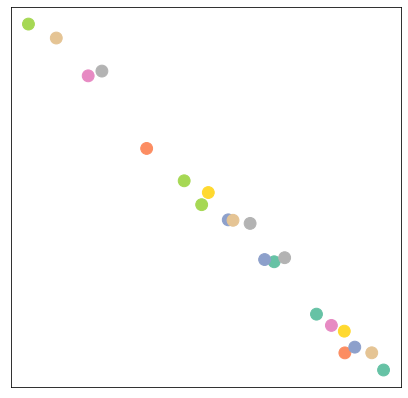

In [47]:
model = GCN(LeftHandTensor)

_, h = model(LeftHandData.x, LeftHandData.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=LeftHandData.y)

### RightHand

Embedding shape: [21, 64]


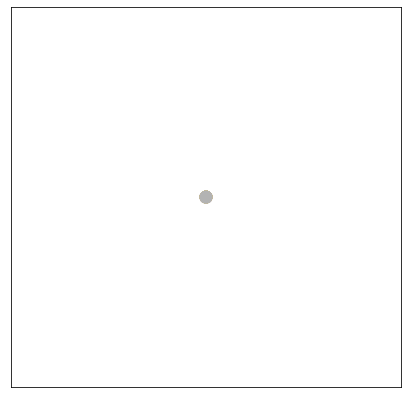

In [48]:
model = GCN(RightHandTensor)

_, h = model(RightHandData.x, RightHandData.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=RightHandData.y)

### Pose

Embedding shape: [33, 64]


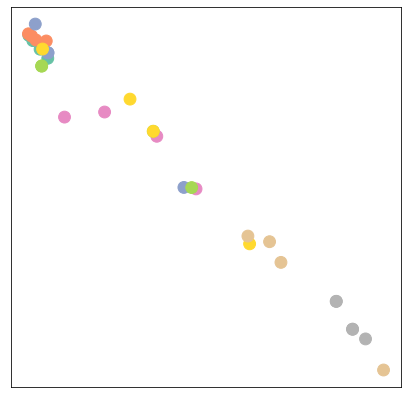

In [49]:
model = GCN(poseTensor)

_, h = model(PoseData.x, PoseData.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=PoseData.y)

### Face

Embedding shape: [468, 64]


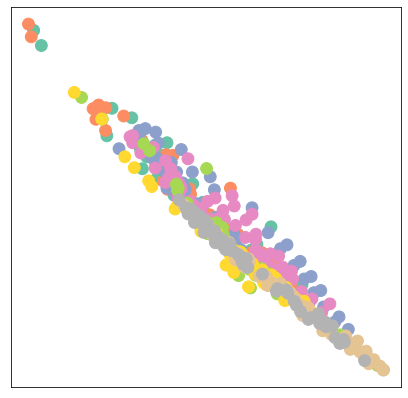

In [50]:
model = GCN(FaceTensor)

_, h = model(FaceData.x, FaceData.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=FaceData.y)

## Training

In [44]:
def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

### 1. Left Hand Training

<IPython.core.display.Javascript object>

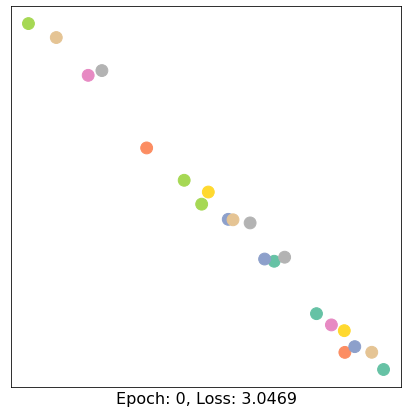

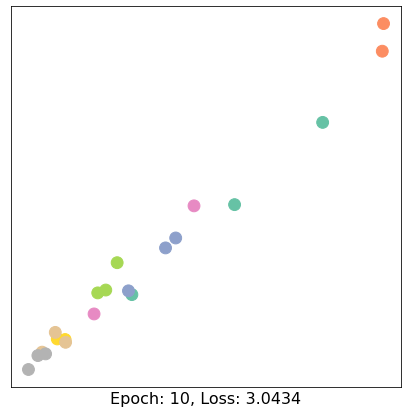

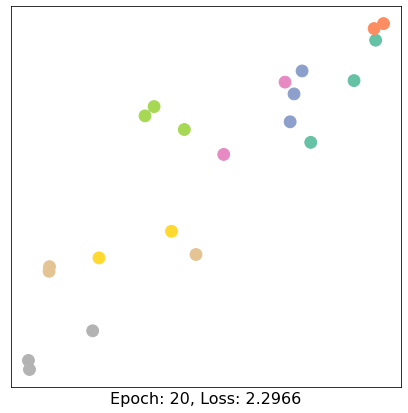

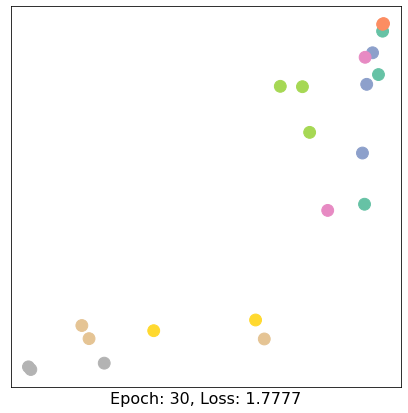

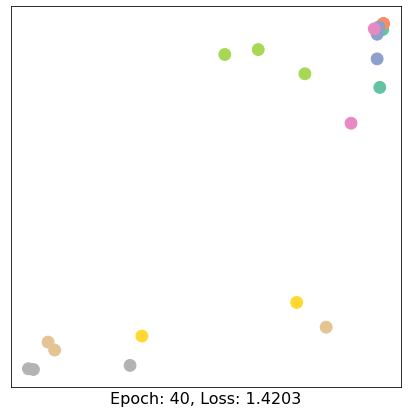

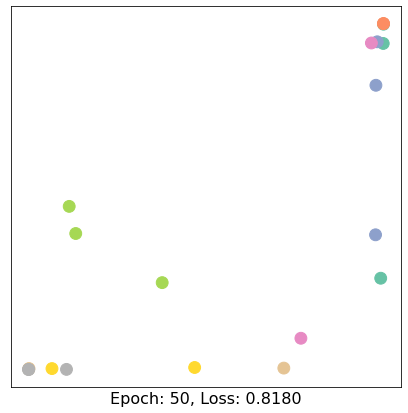

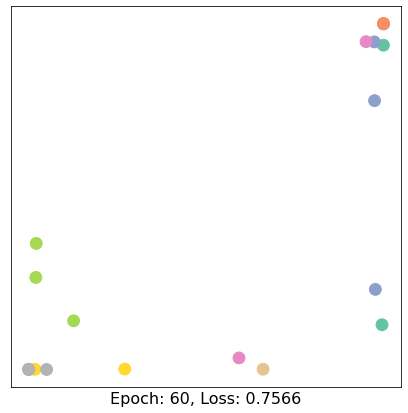

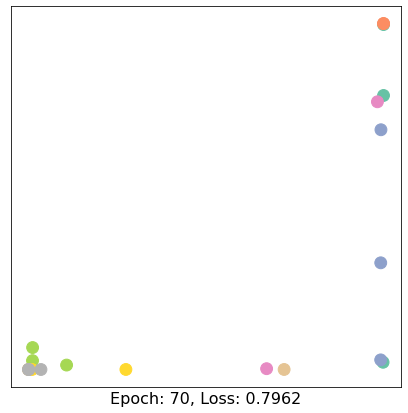

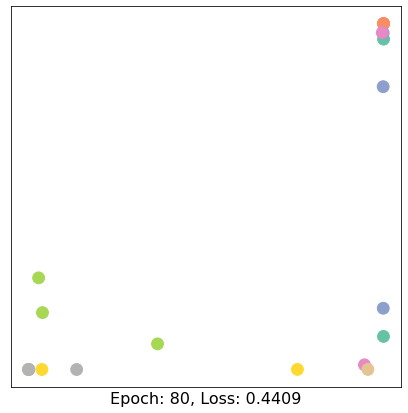

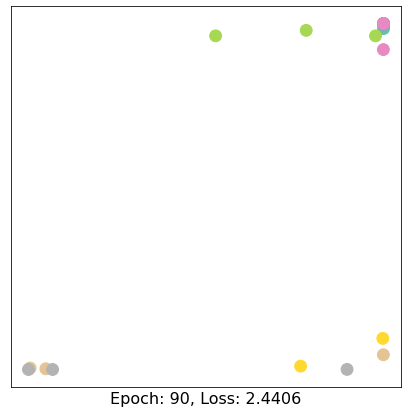

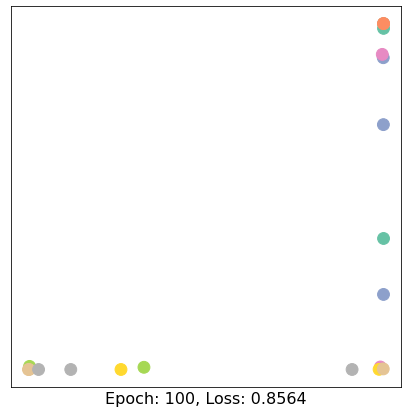

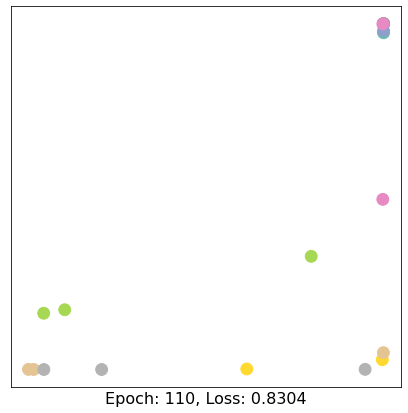

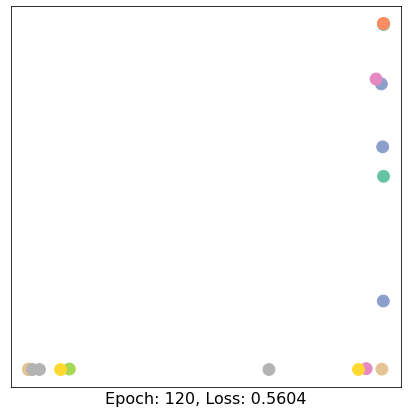

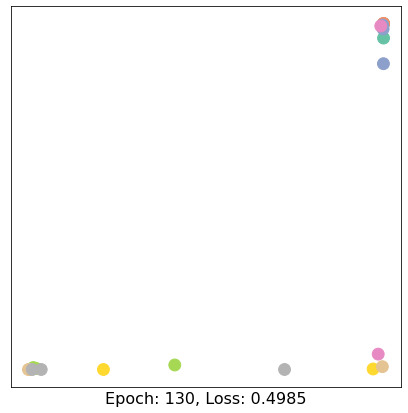

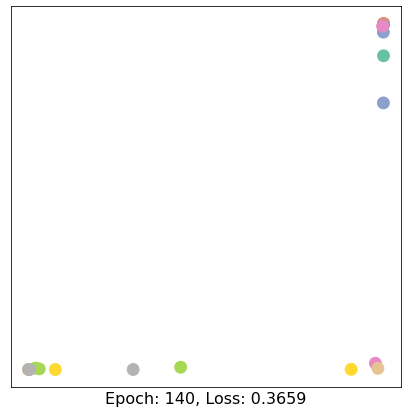

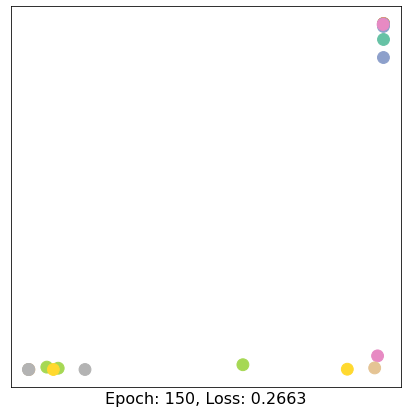

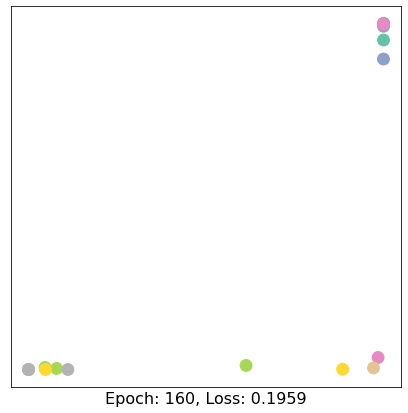

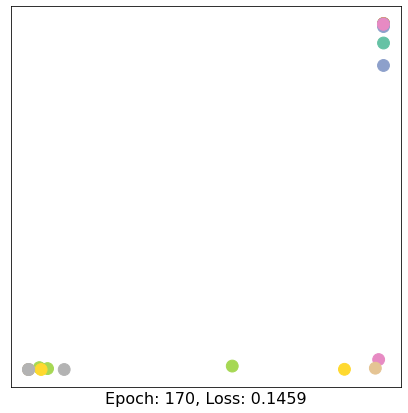

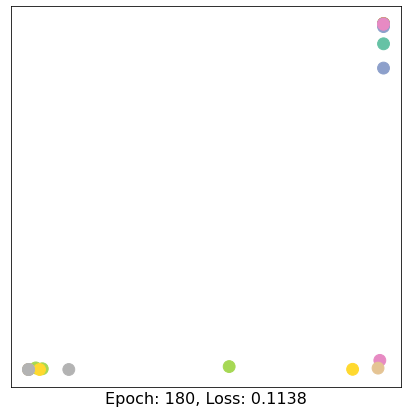

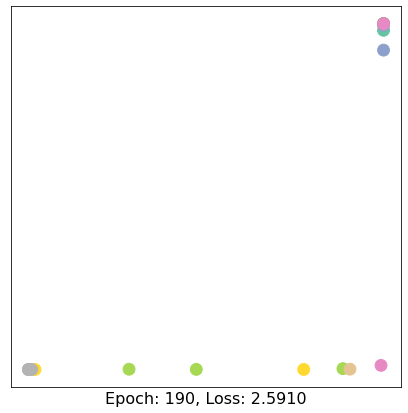

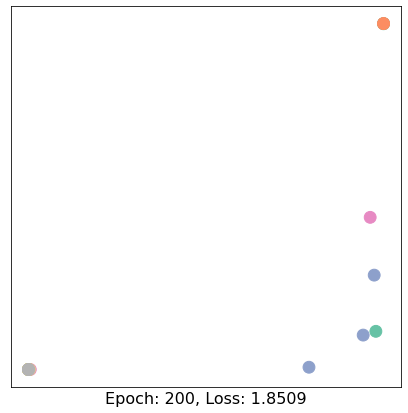

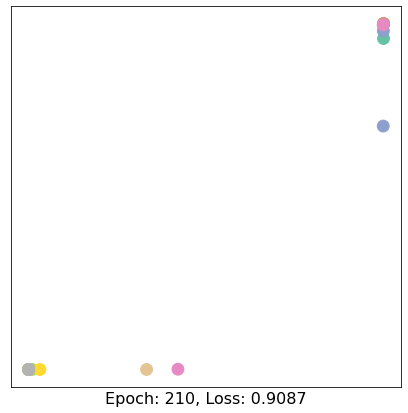

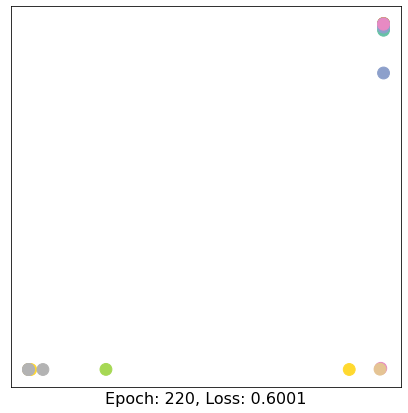

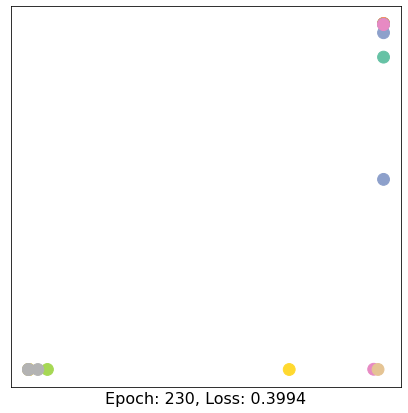

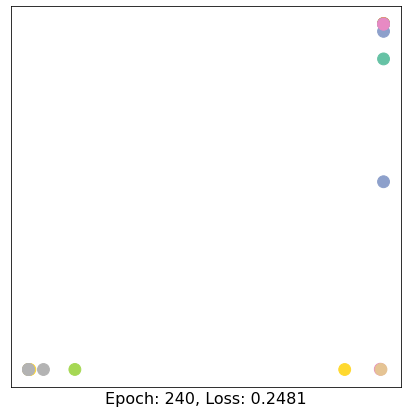

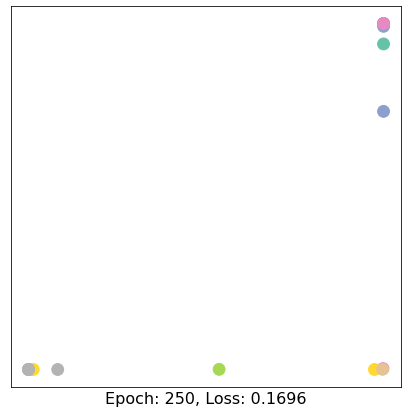

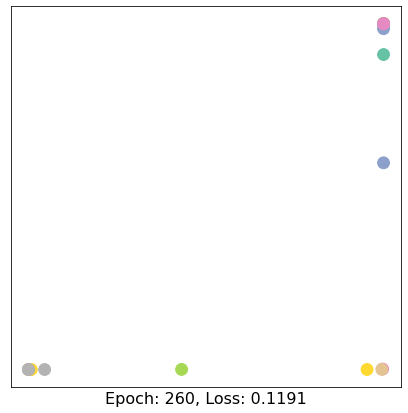

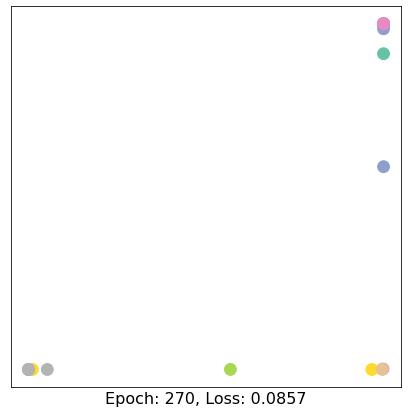

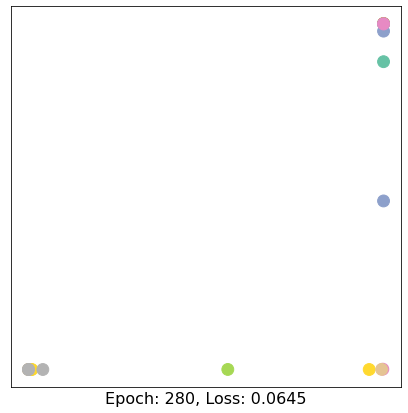

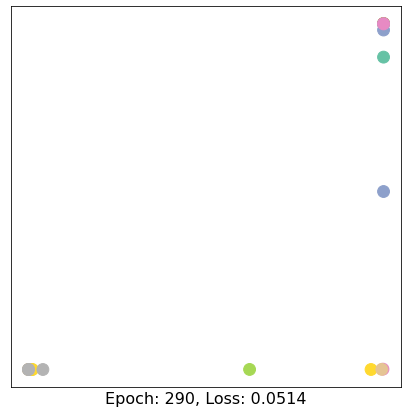

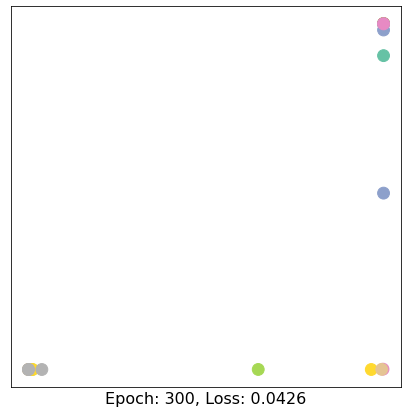

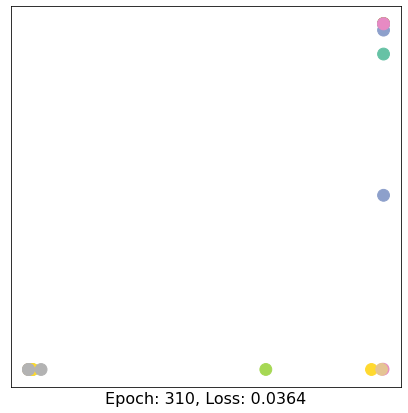

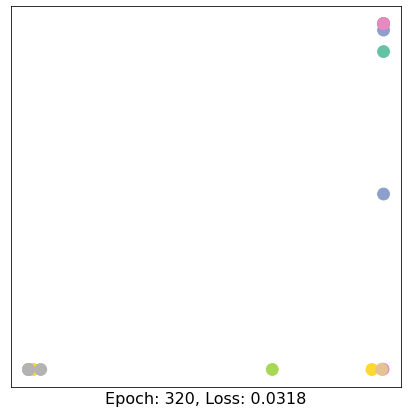

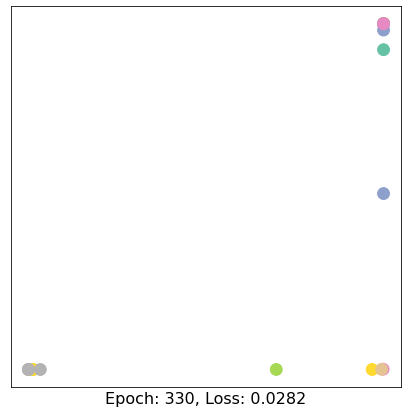

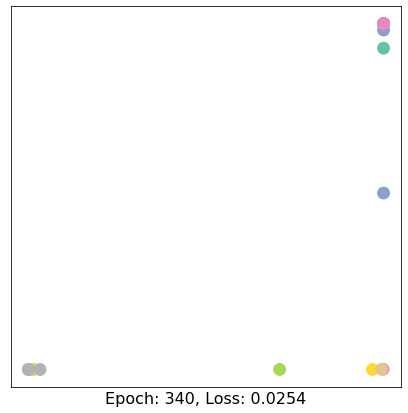

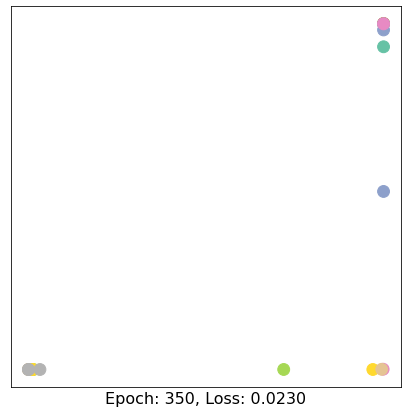

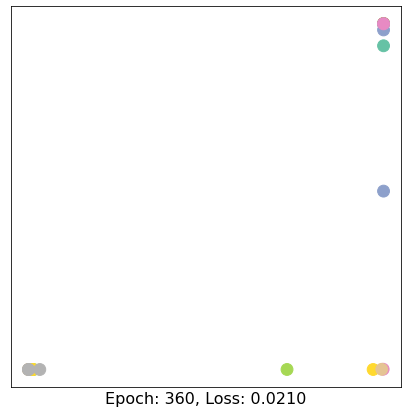

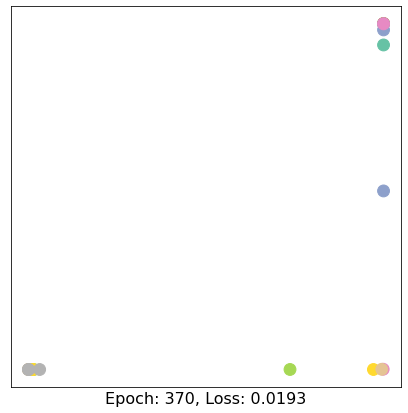

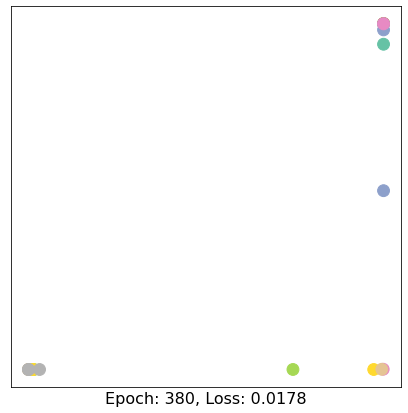

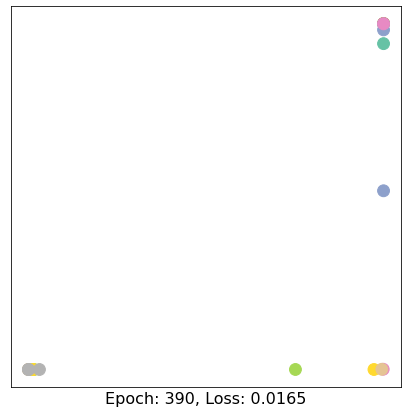

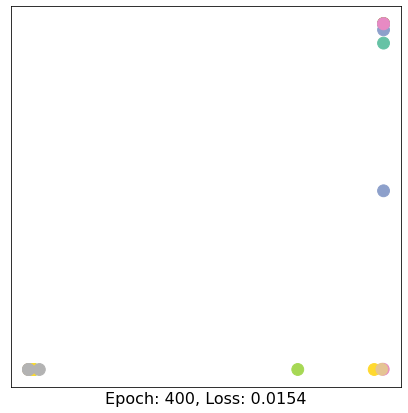

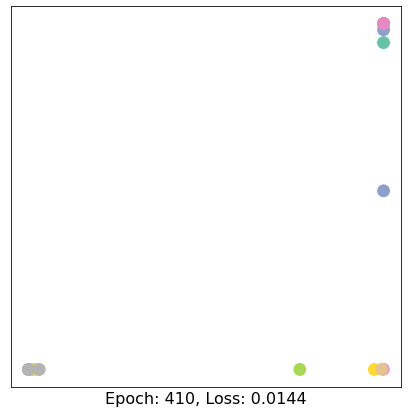

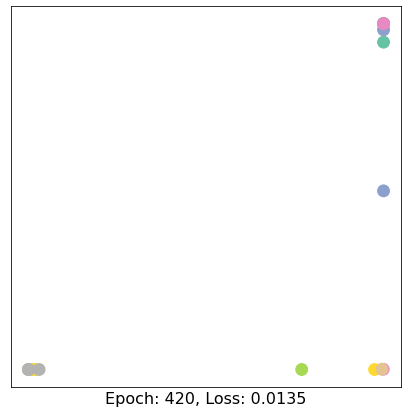

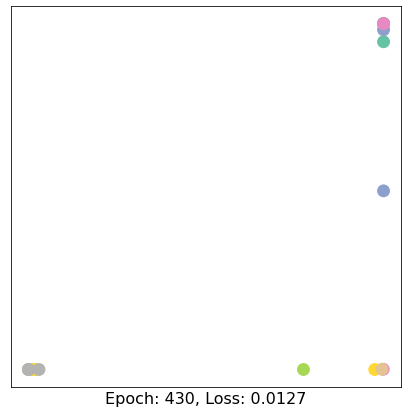

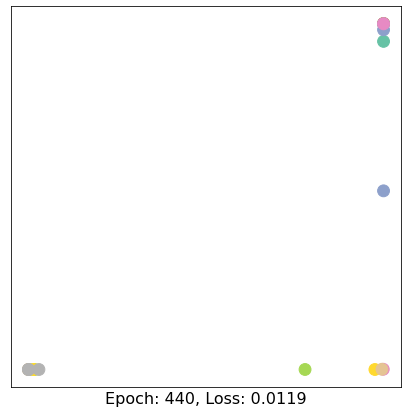

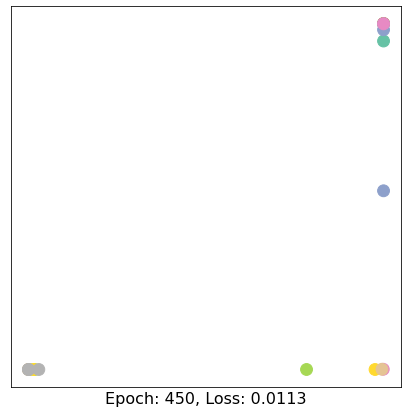

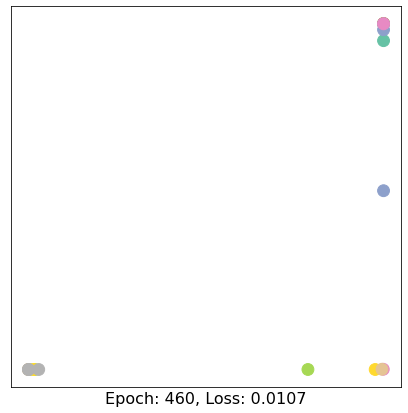

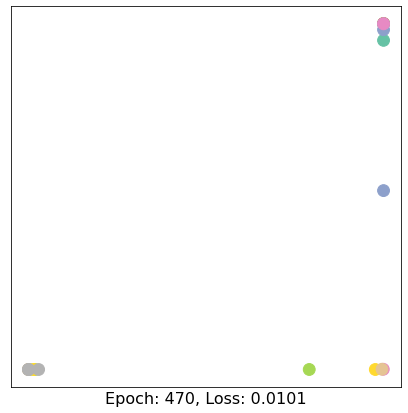

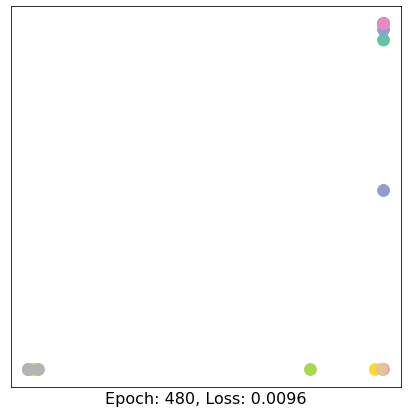

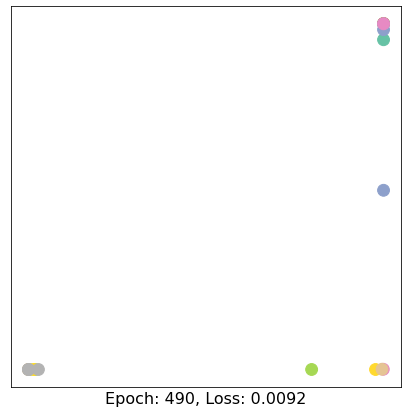

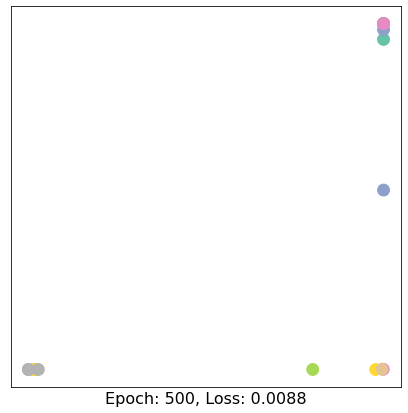

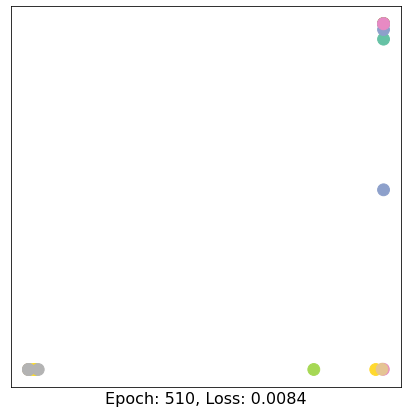

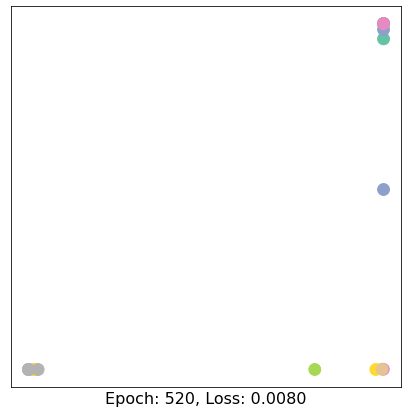

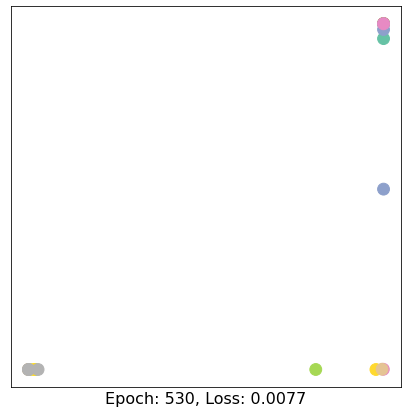

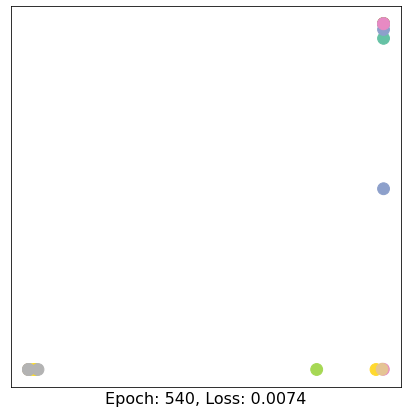

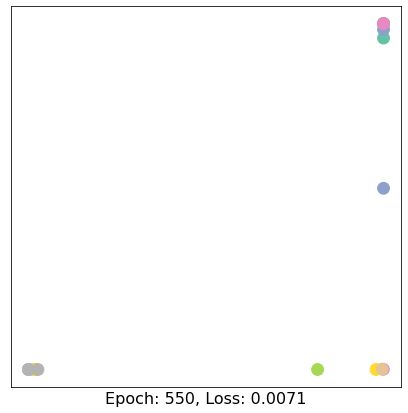

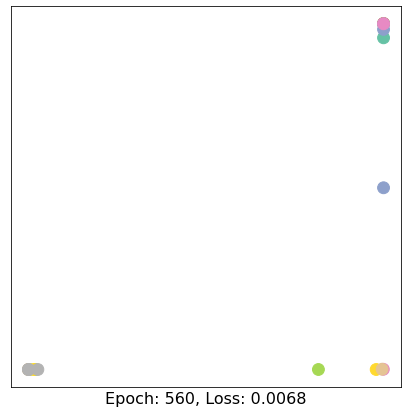

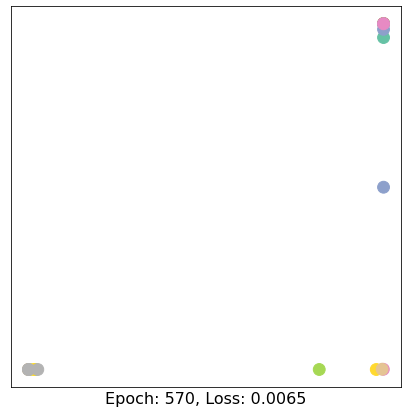

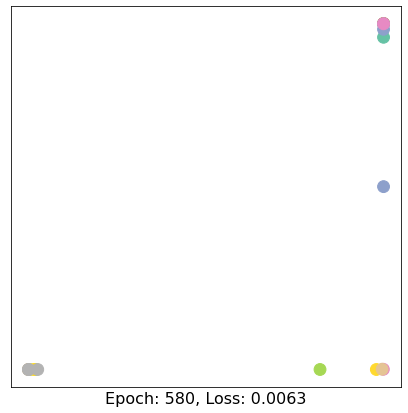

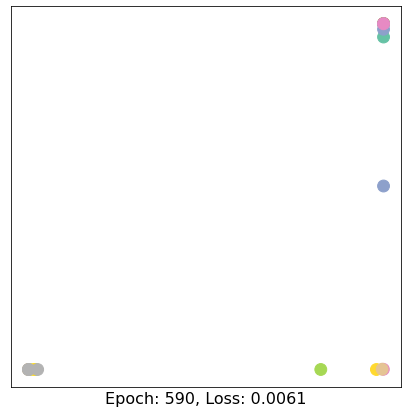

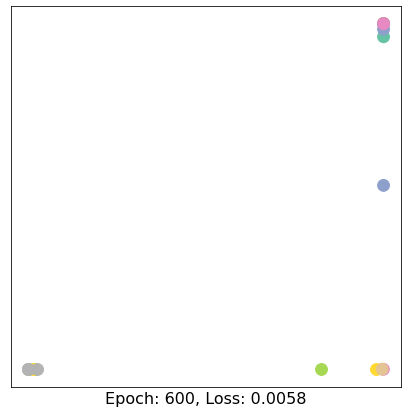

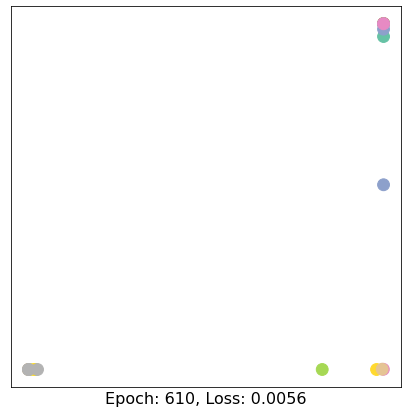

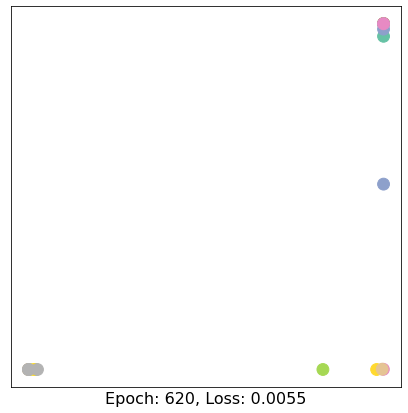

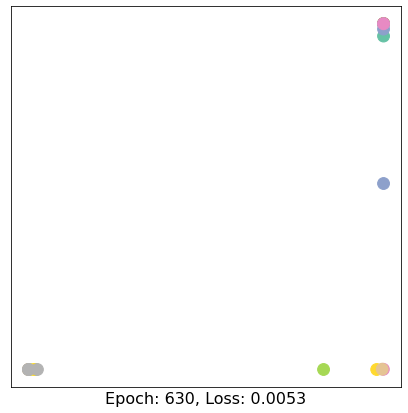

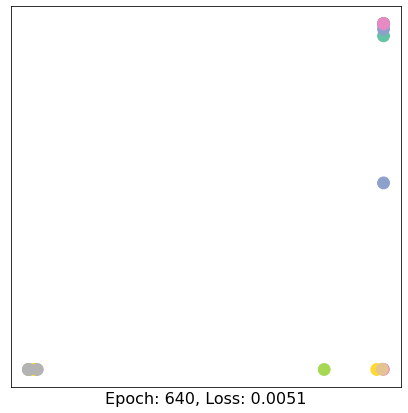

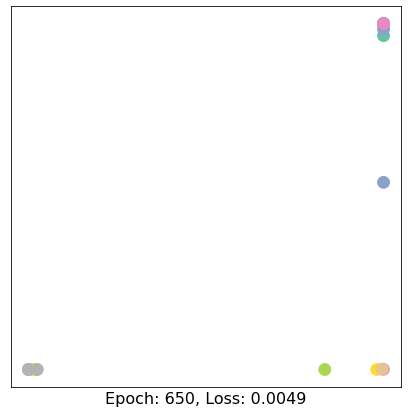

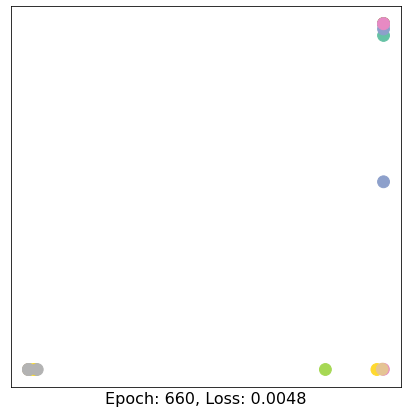

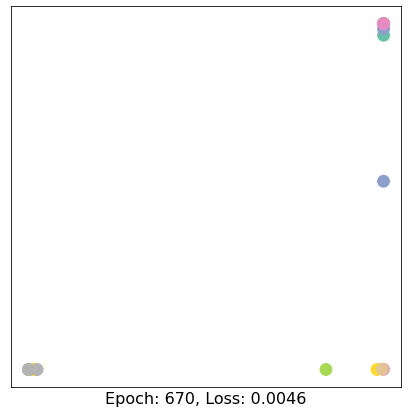

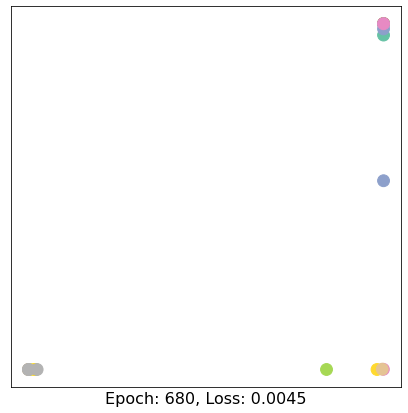

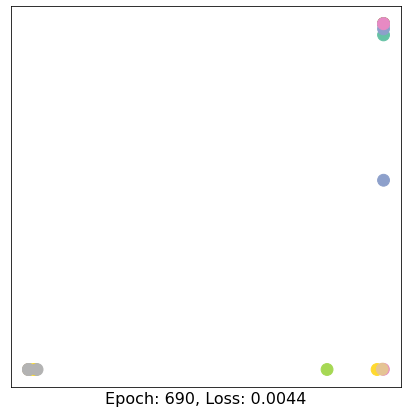

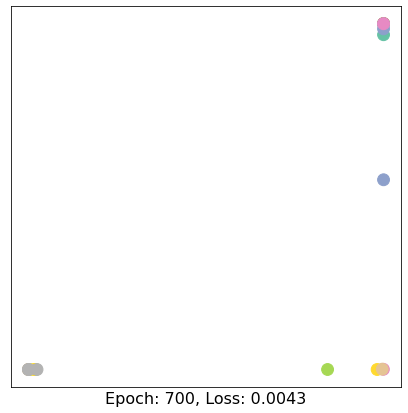

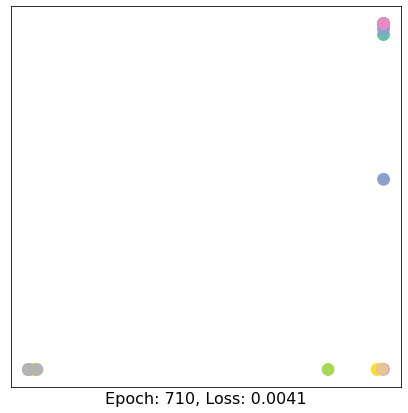

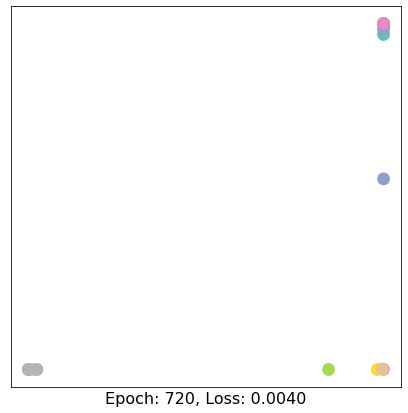

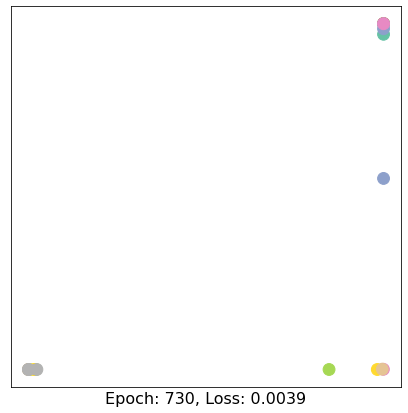

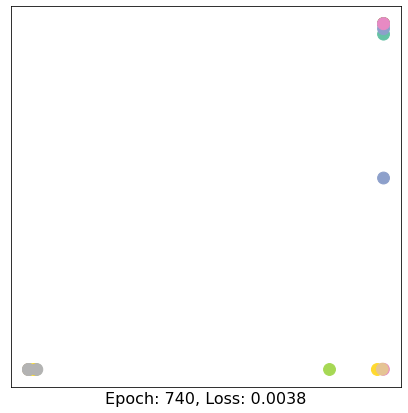

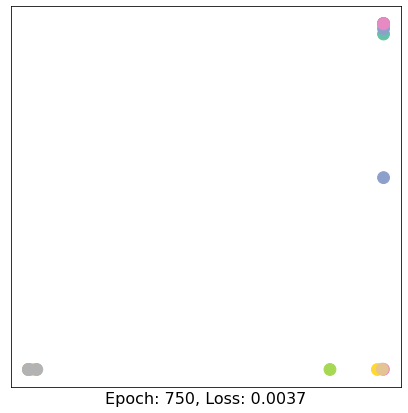

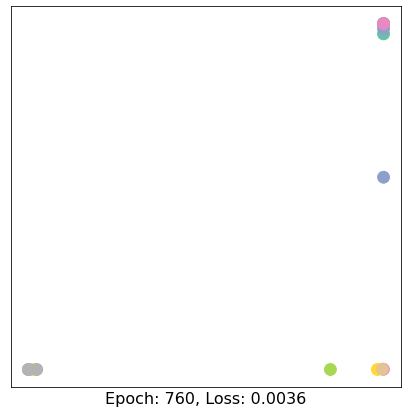

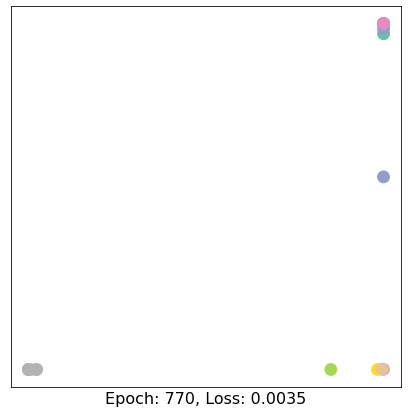

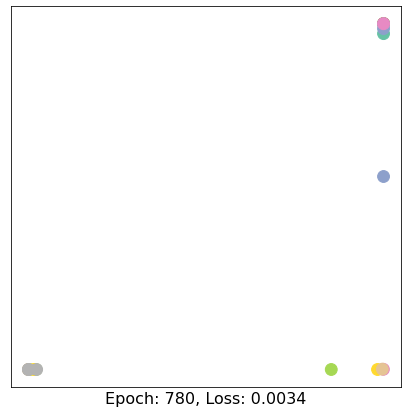

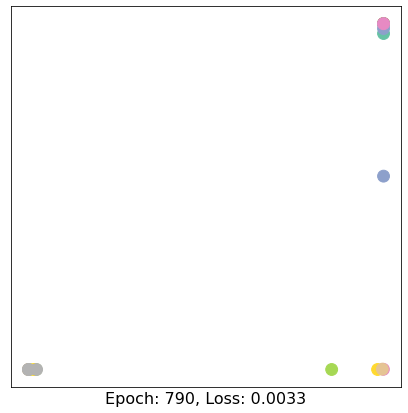

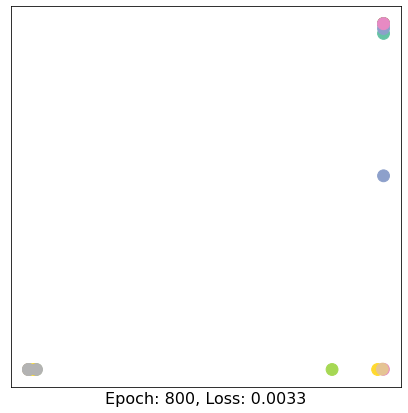

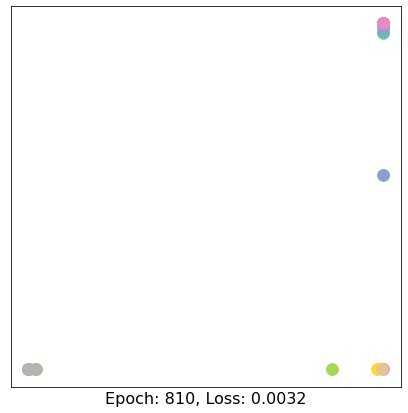

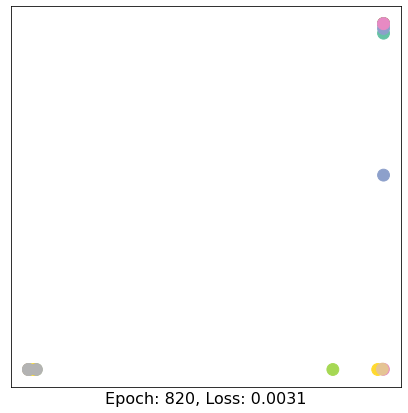

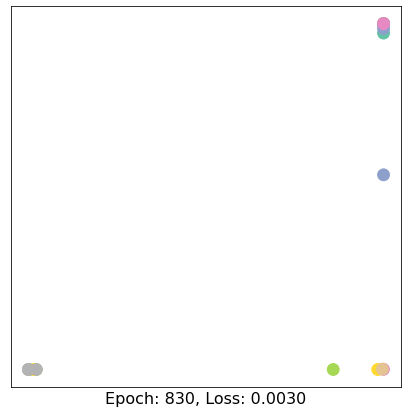

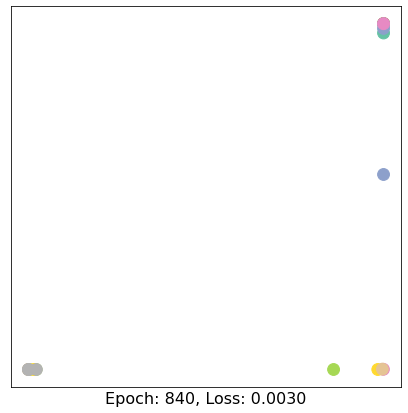

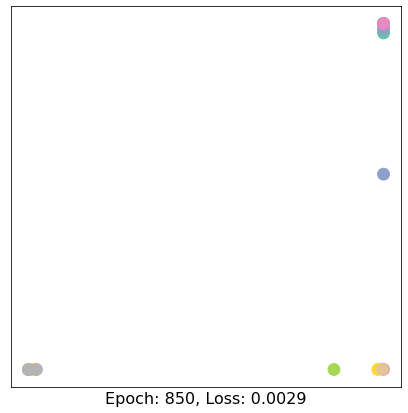

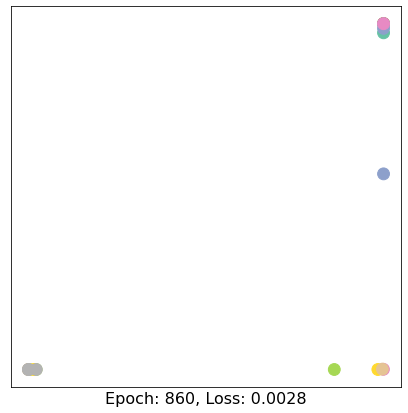

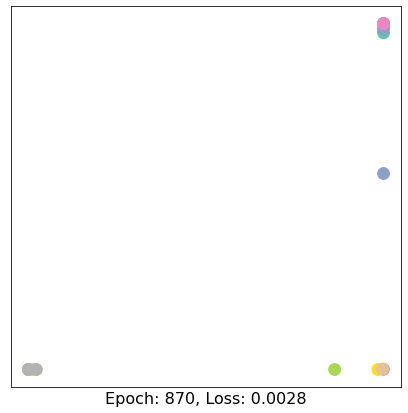

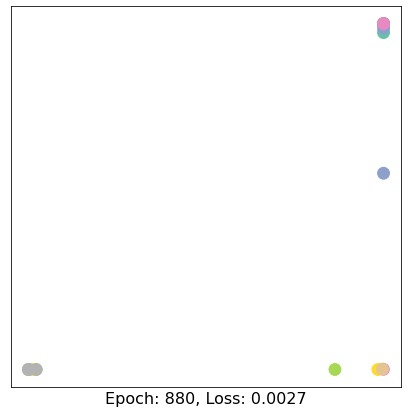

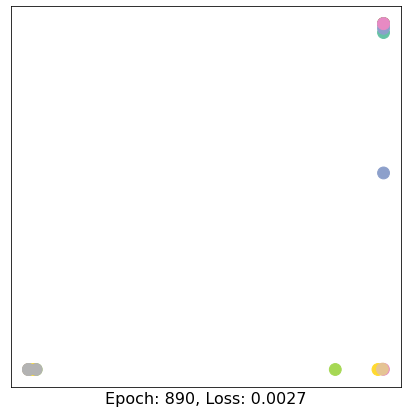

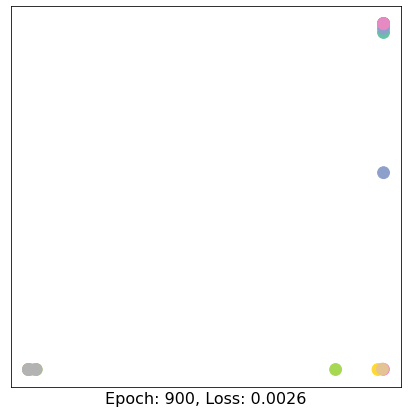

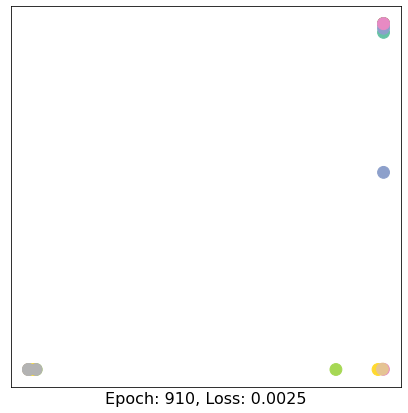

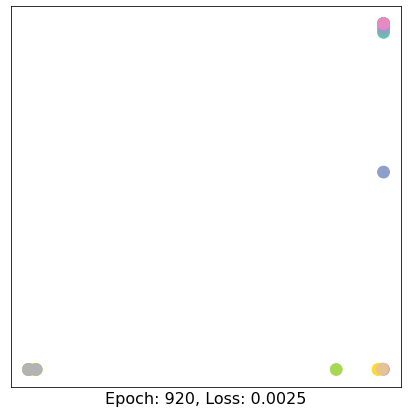

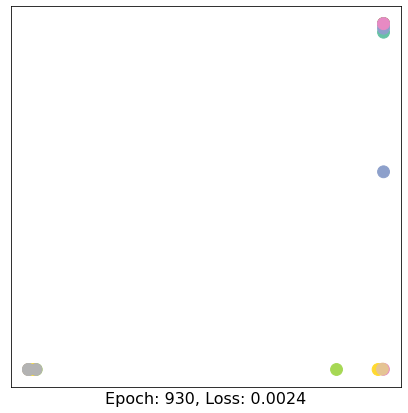

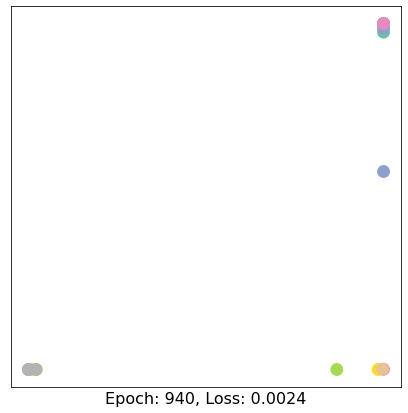

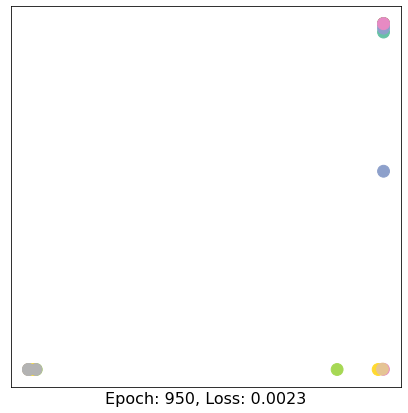

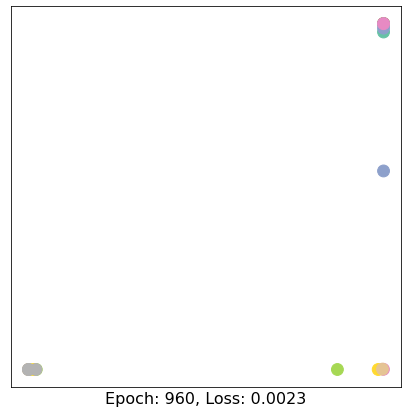

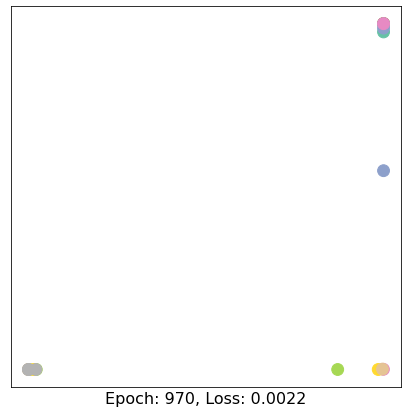

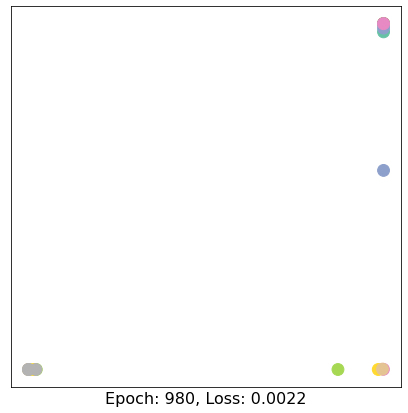

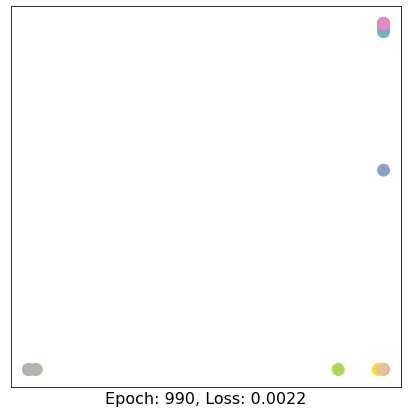

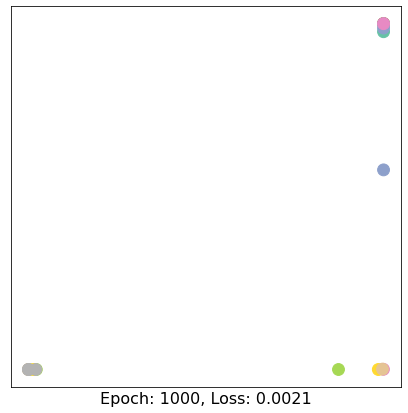

In [51]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN(LeftHandTensor)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

for epoch in range(1001):
    loss, h = train(LeftHandData)
    if epoch % 10 == 0:
        visualize(h, color=LeftHandData.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

### 2. Right Hand Training

<IPython.core.display.Javascript object>

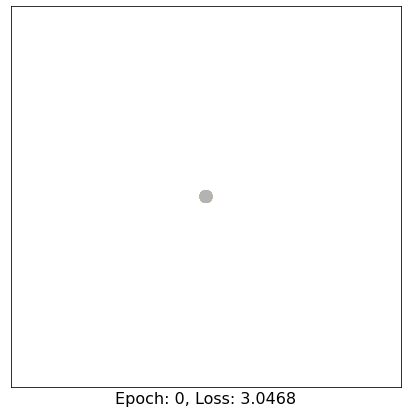

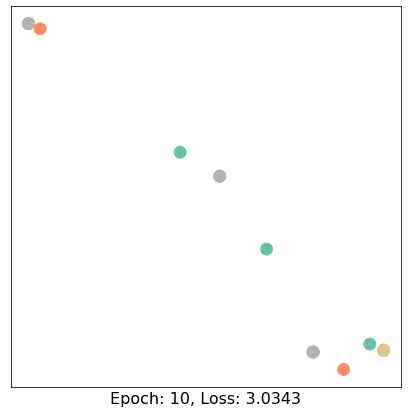

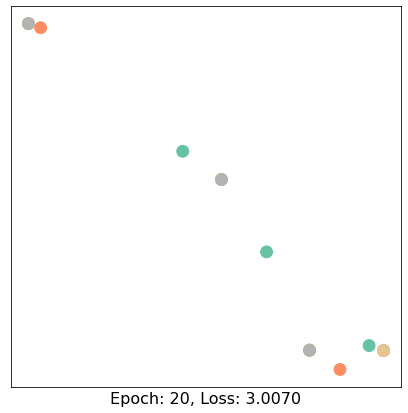

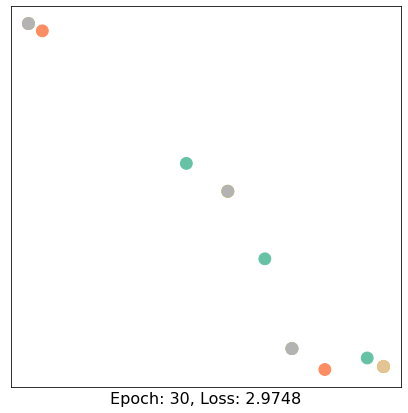

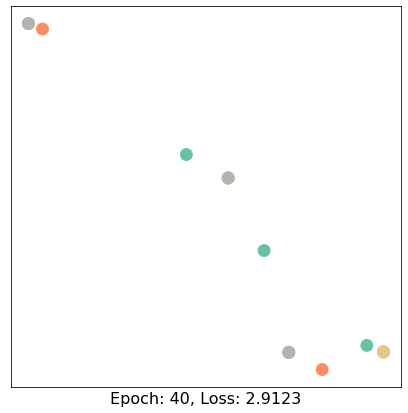

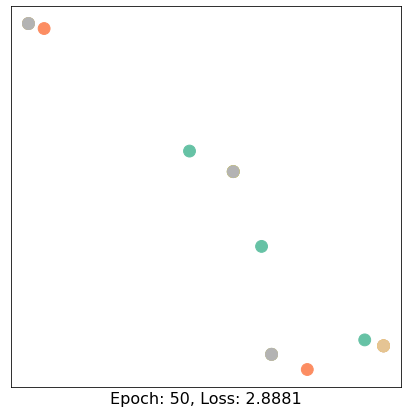

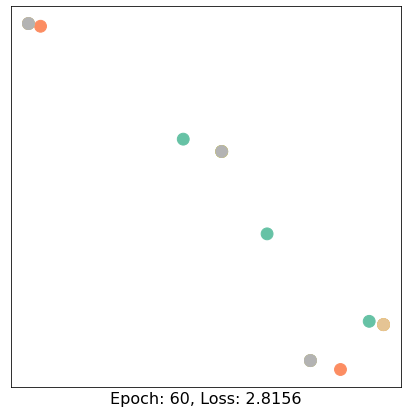

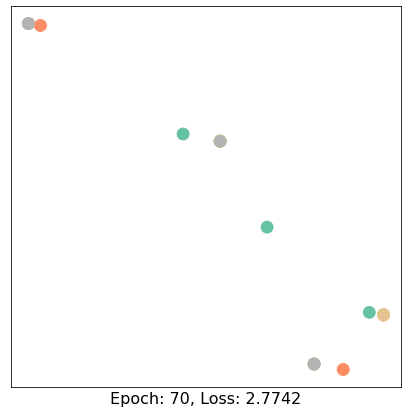

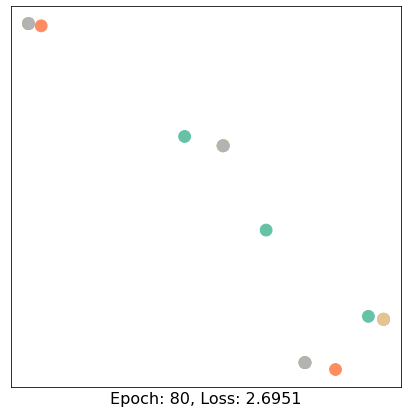

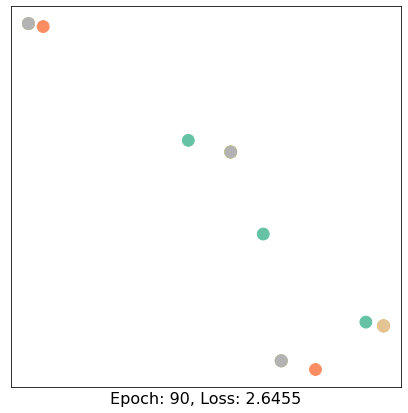

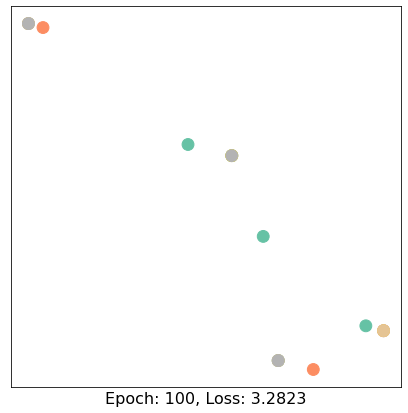

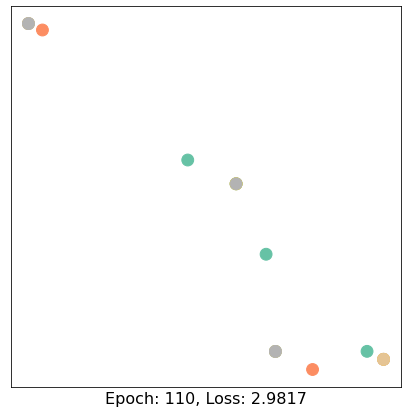

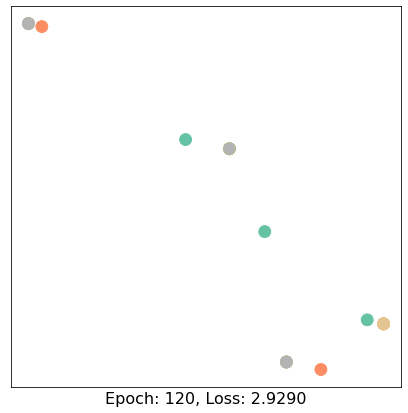

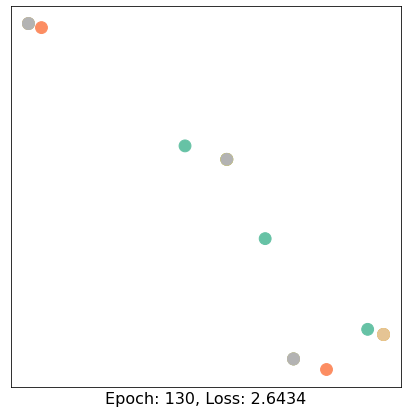

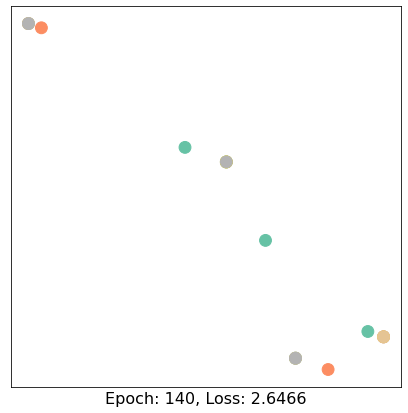

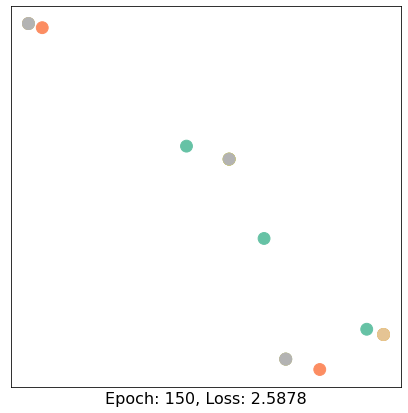

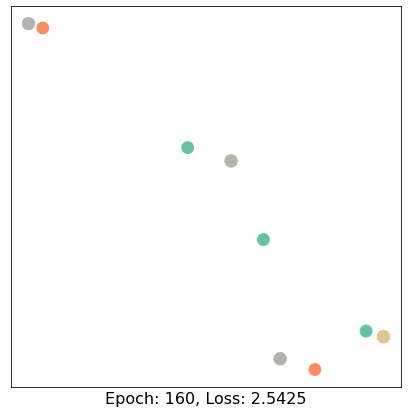

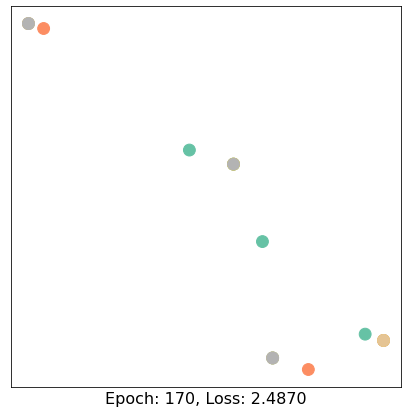

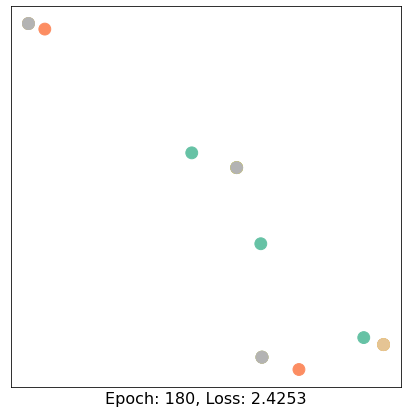

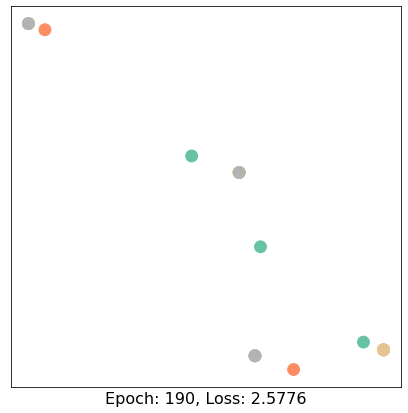

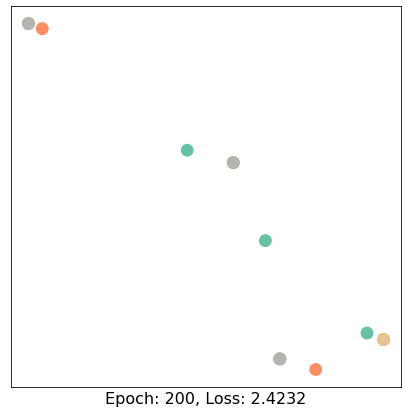

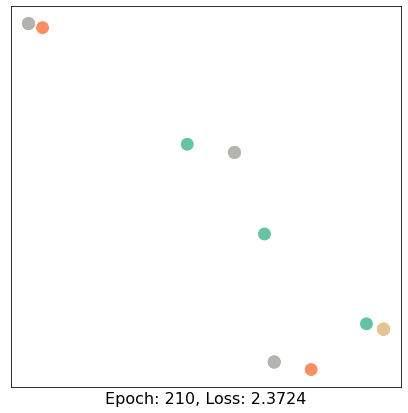

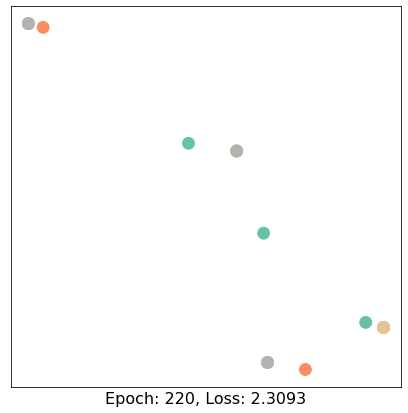

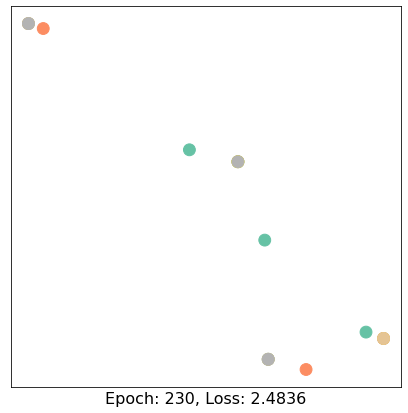

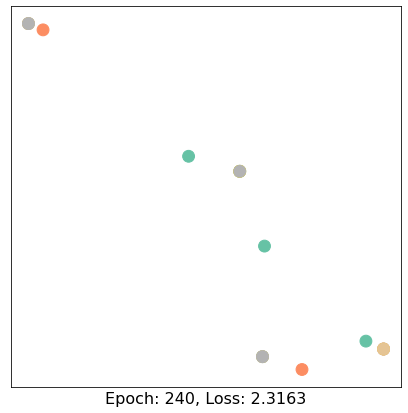

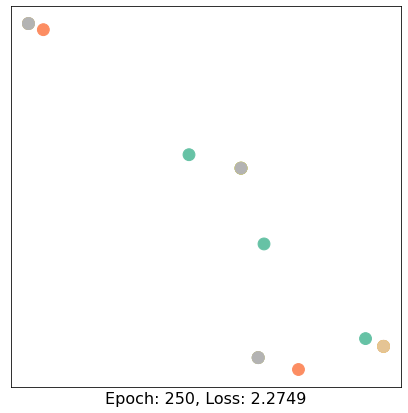

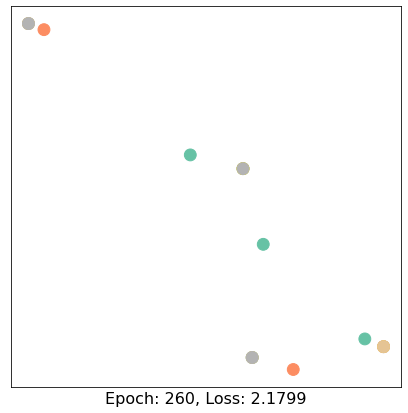

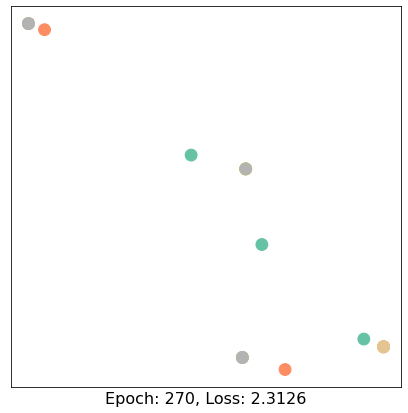

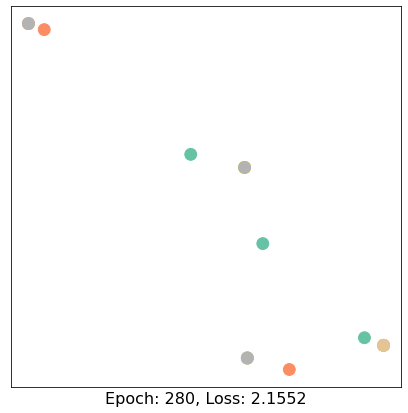

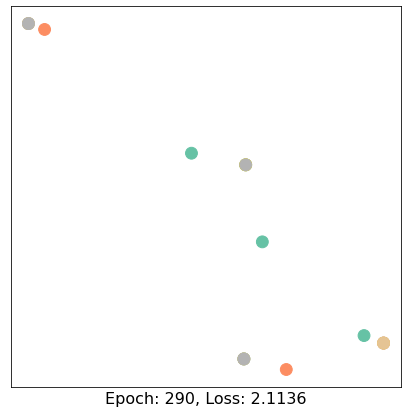

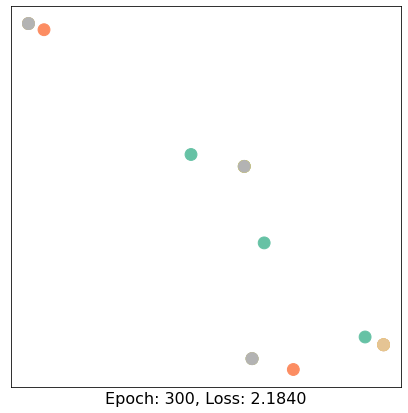

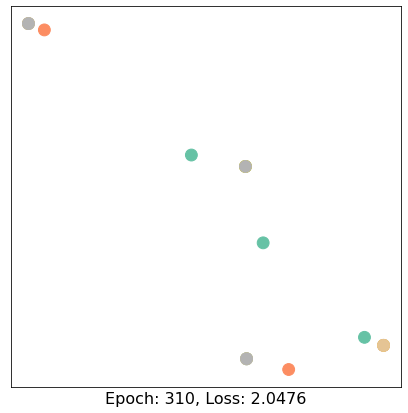

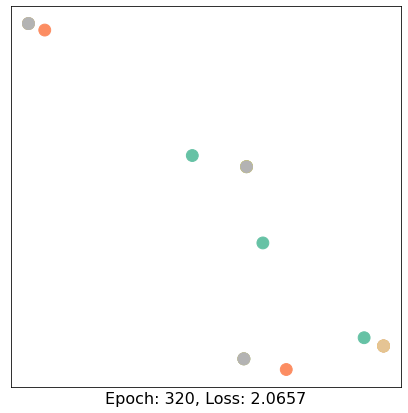

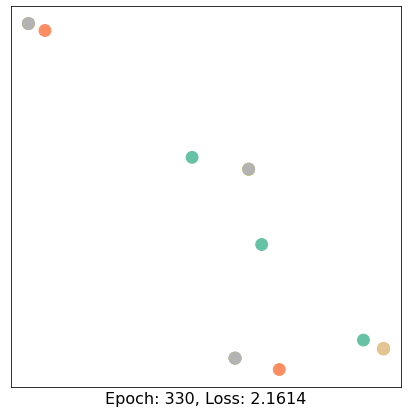

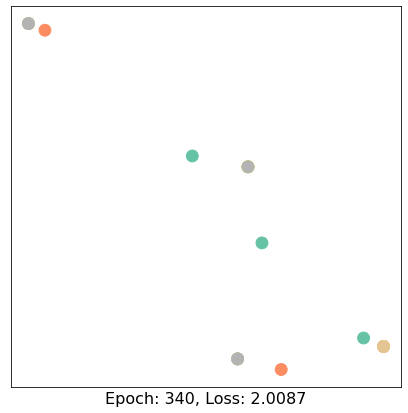

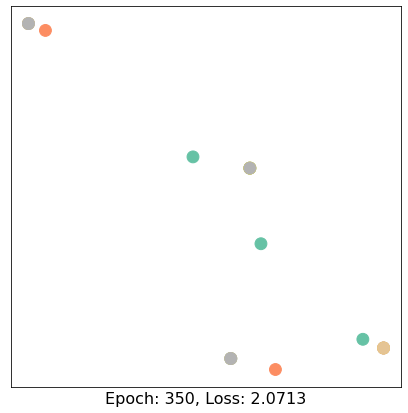

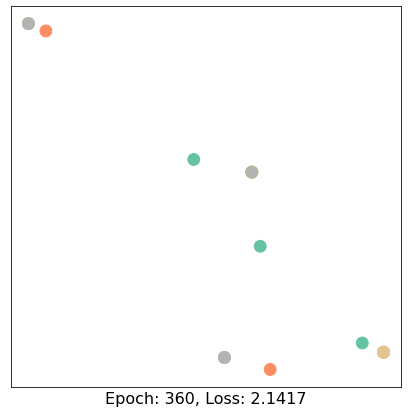

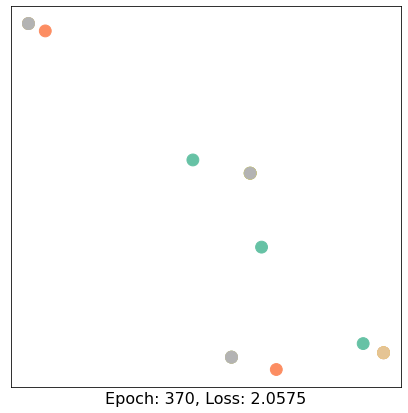

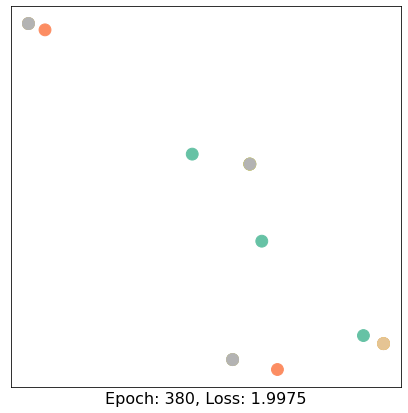

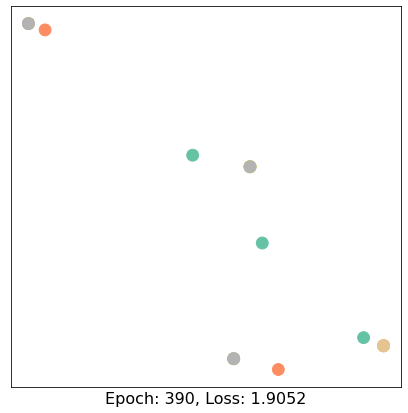

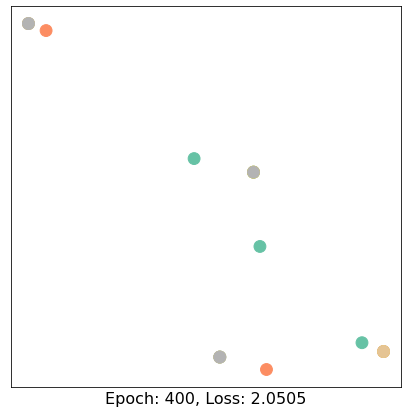

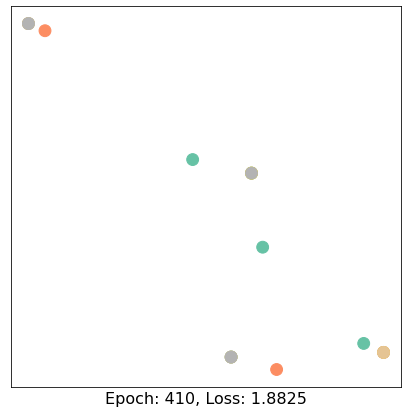

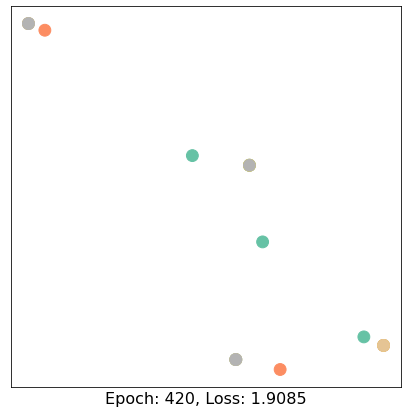

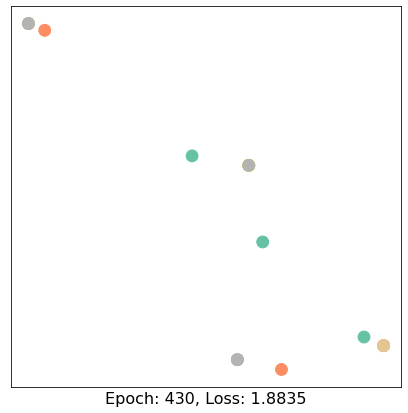

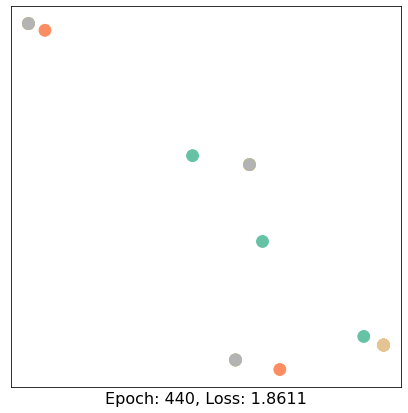

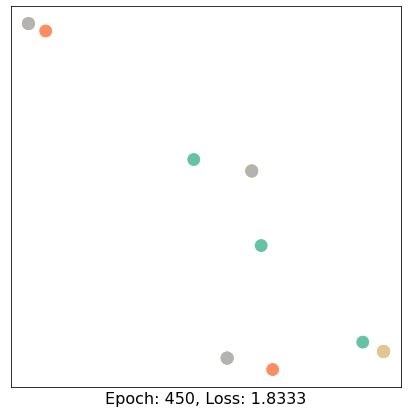

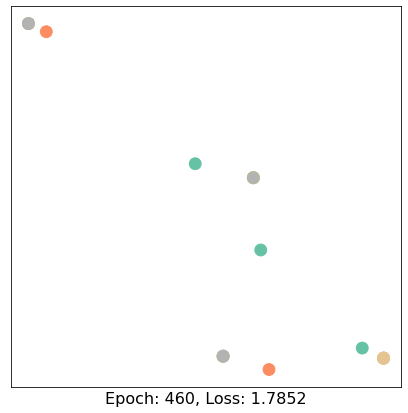

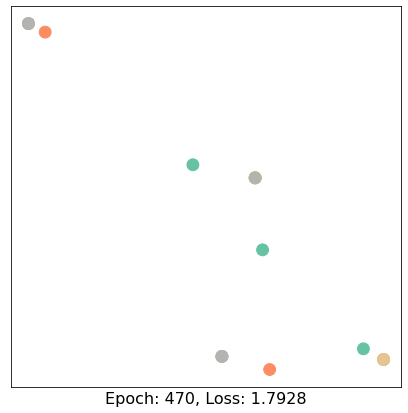

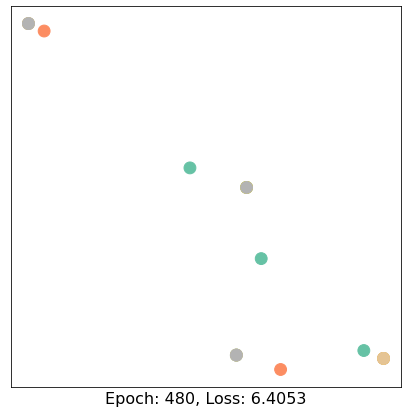

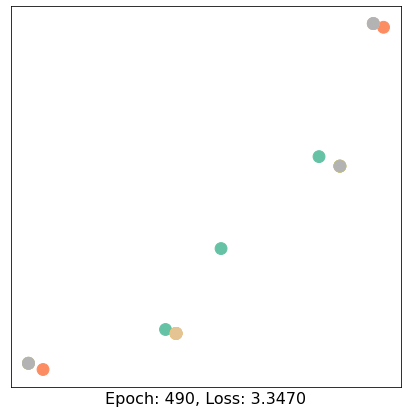

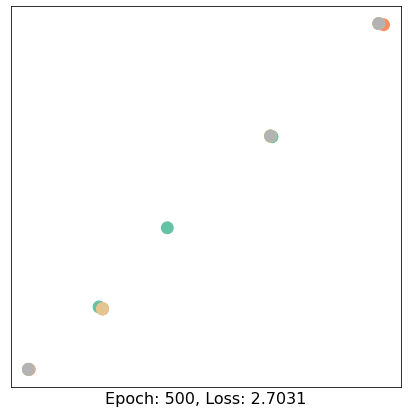

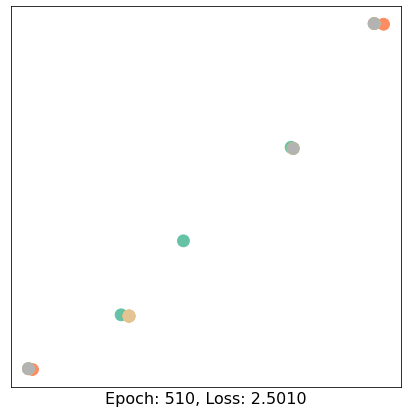

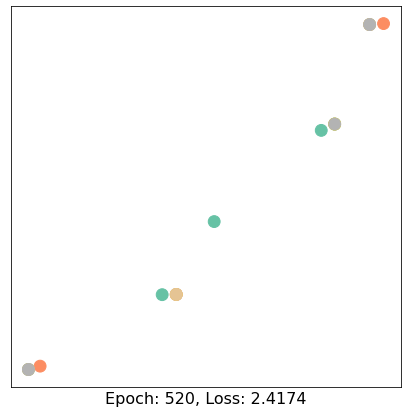

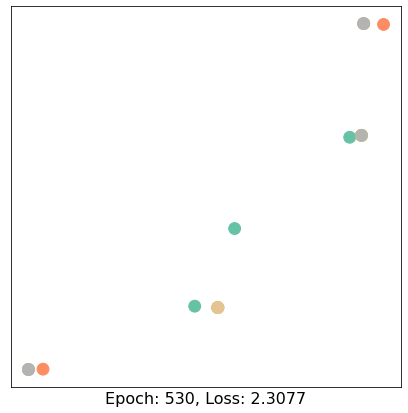

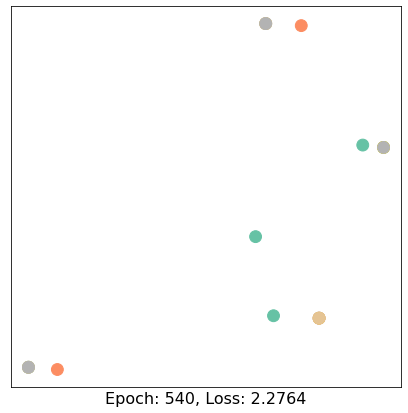

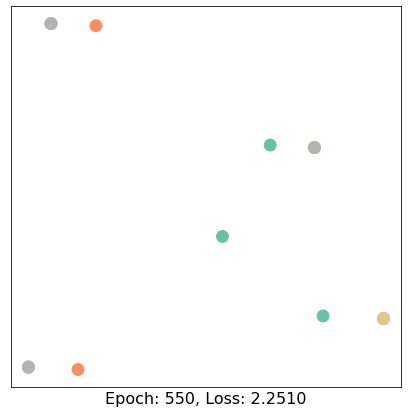

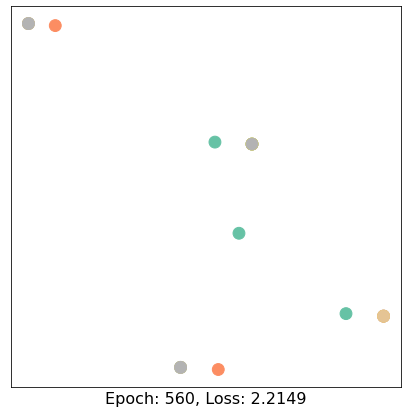

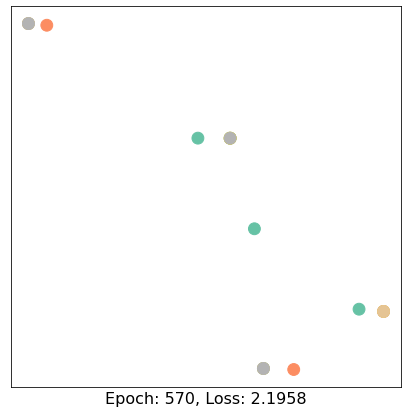

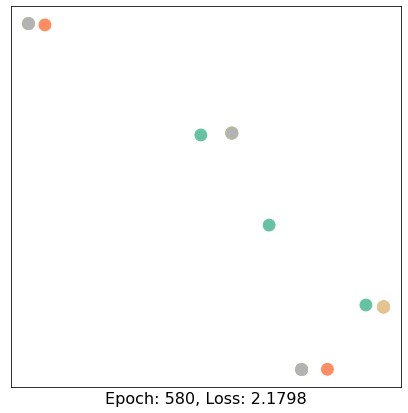

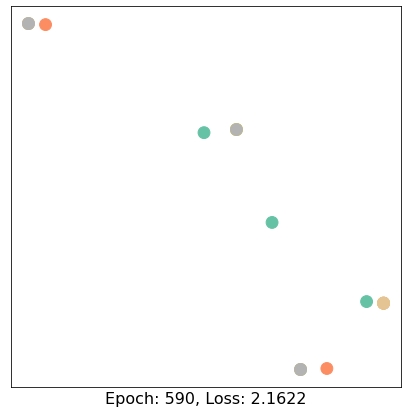

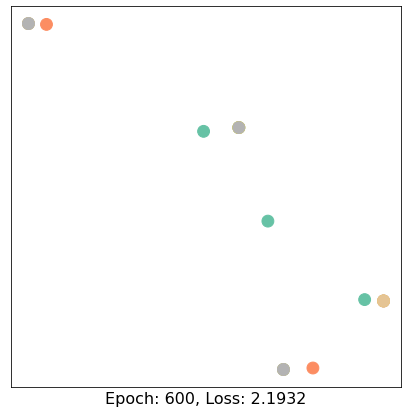

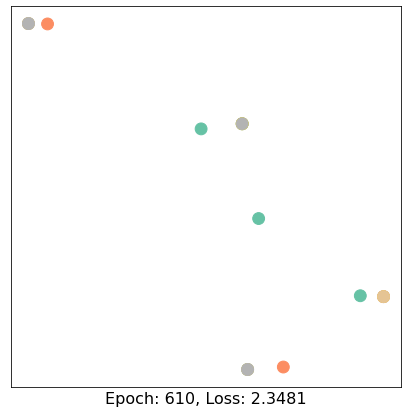

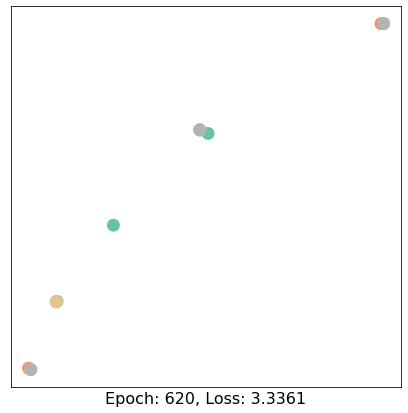

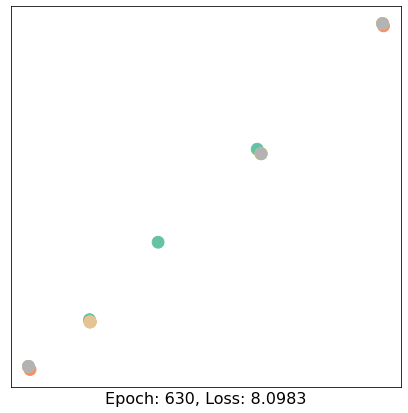

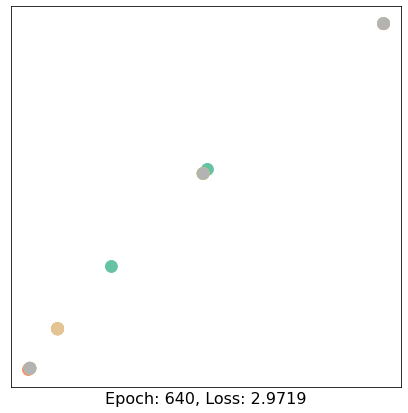

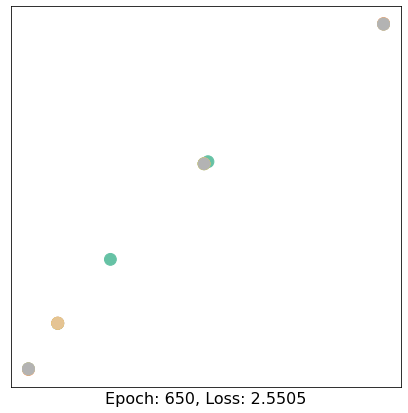

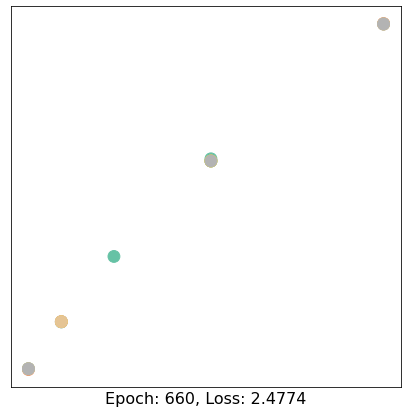

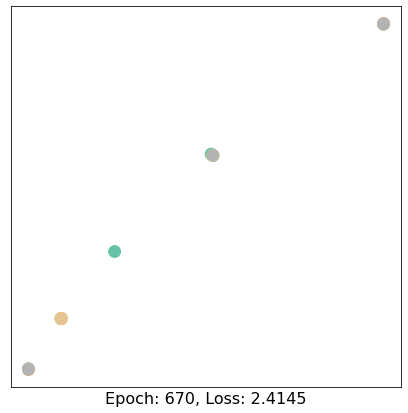

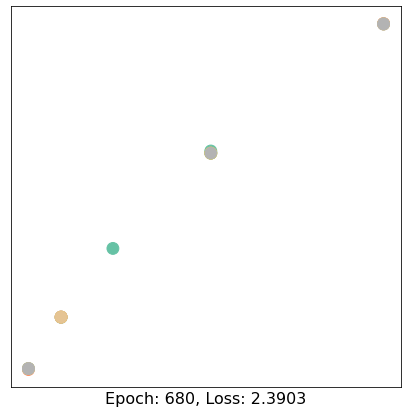

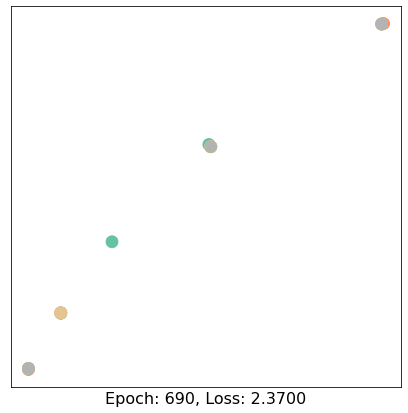

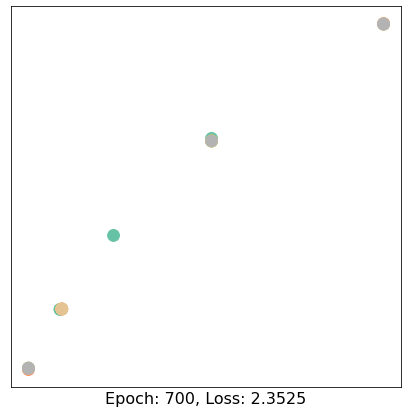

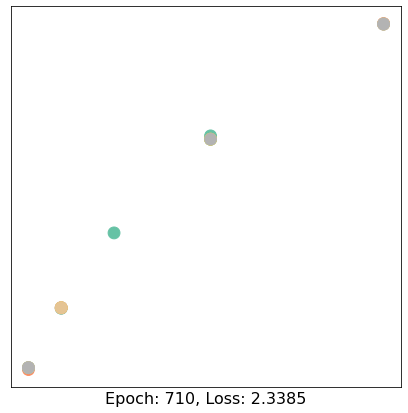

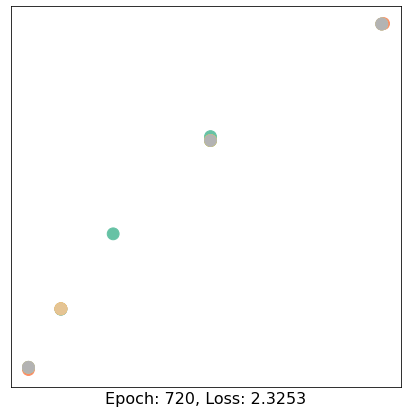

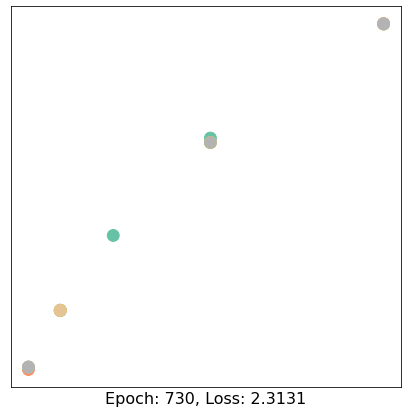

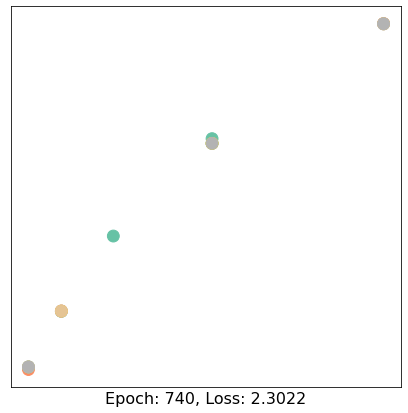

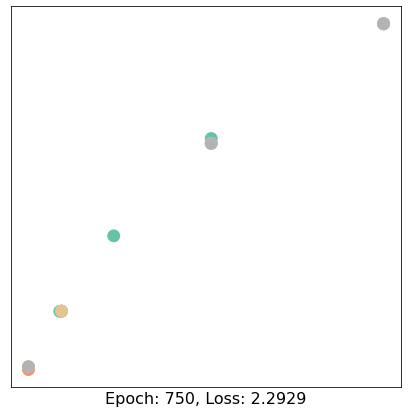

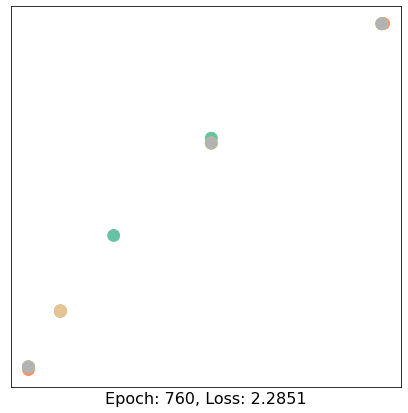

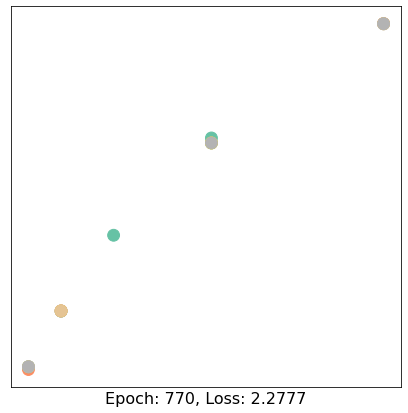

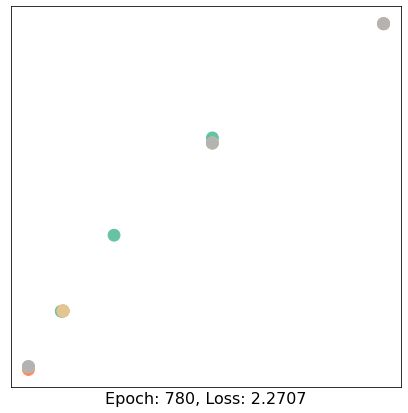

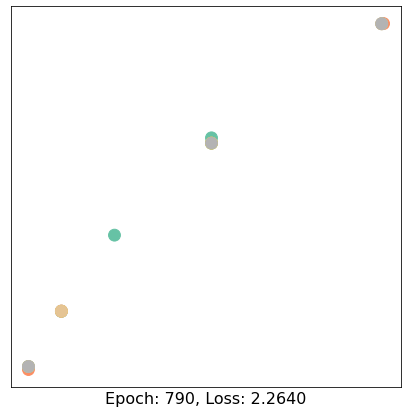

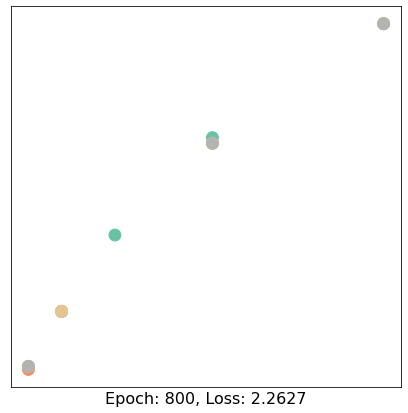

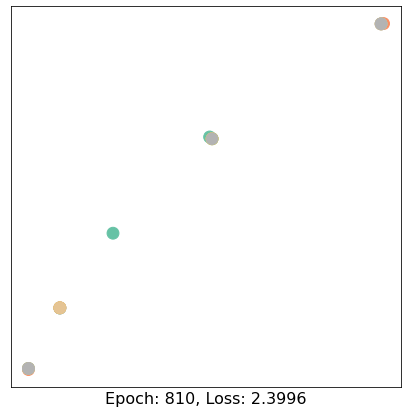

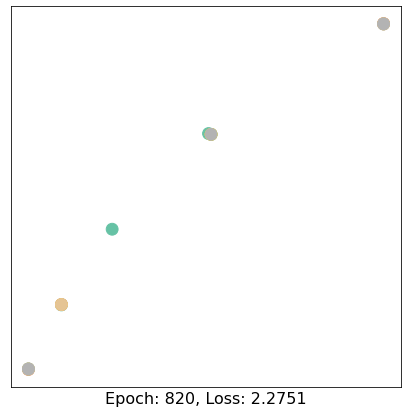

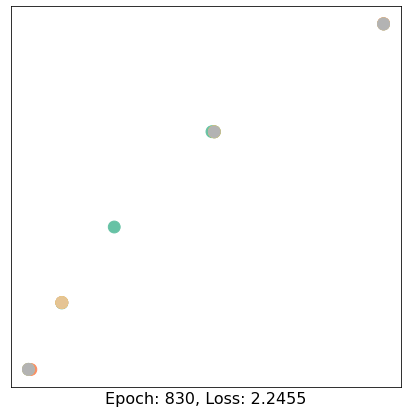

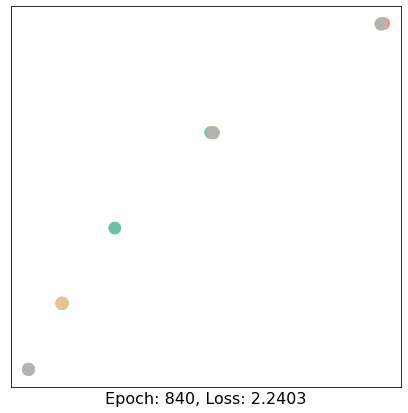

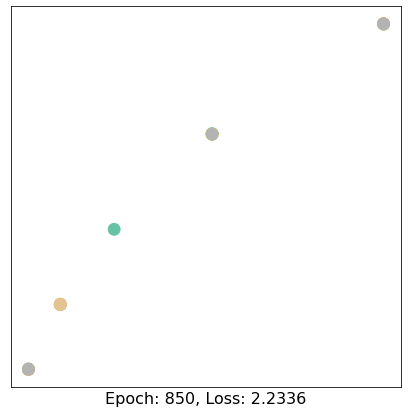

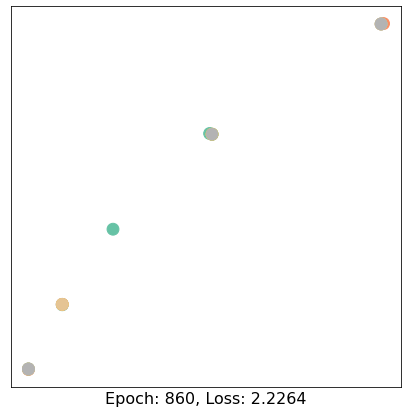

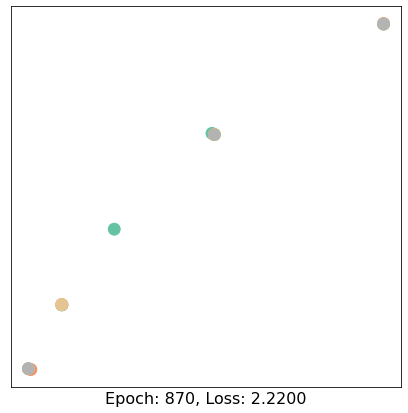

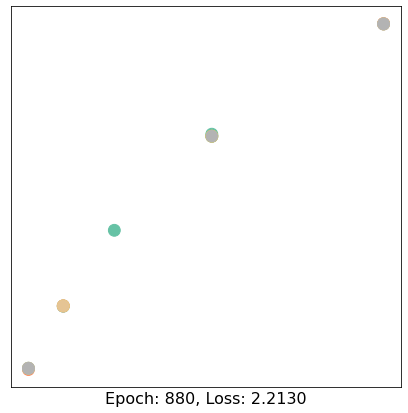

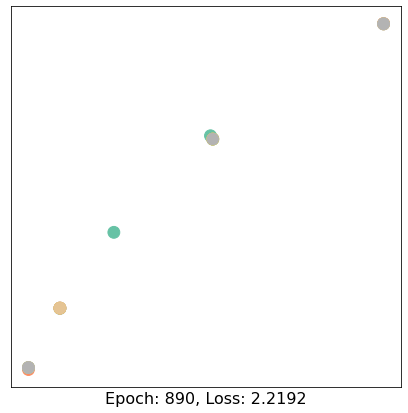

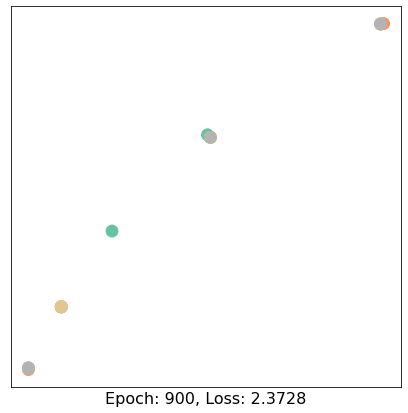

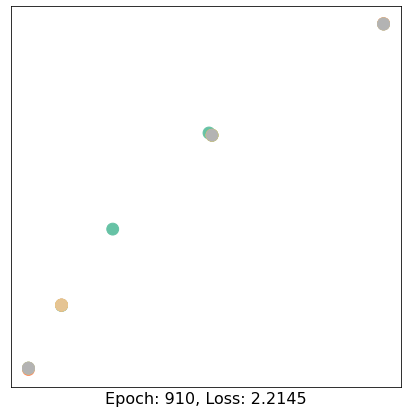

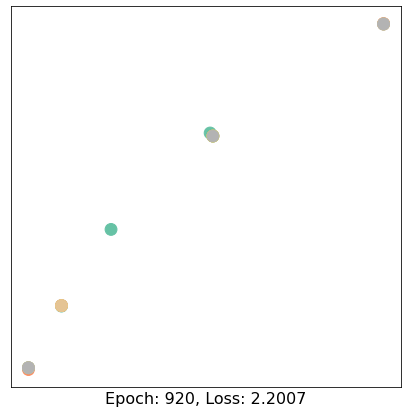

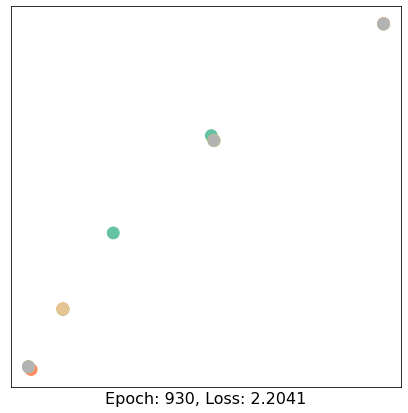

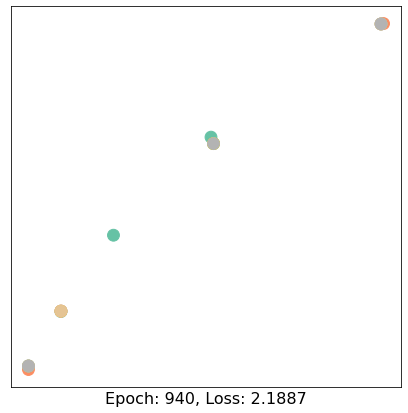

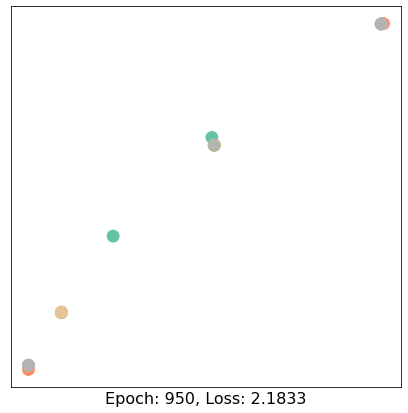

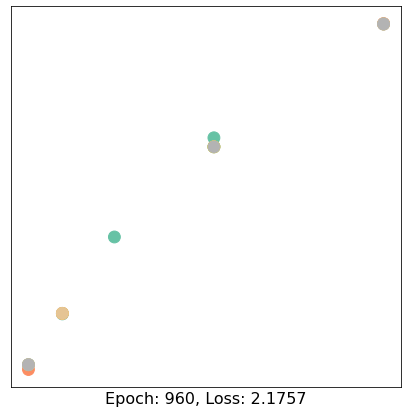

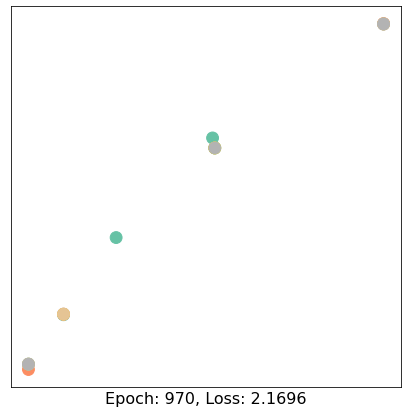

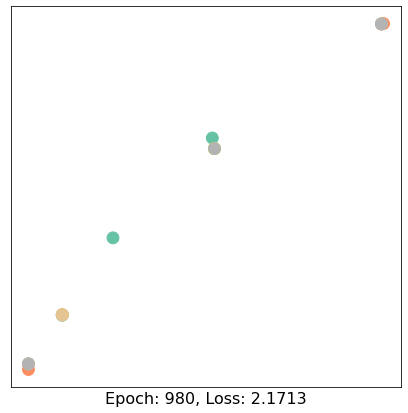

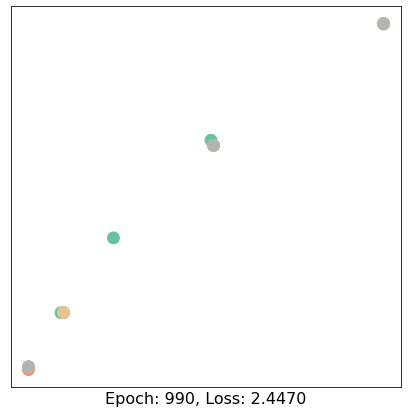

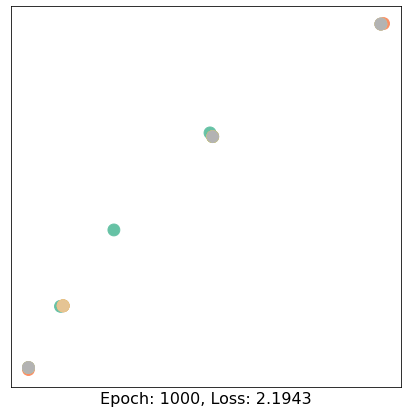

In [52]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN(RightHandTensor)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

for epoch in range(1001):
    loss, h = train(RightHandData)
    if epoch % 10 == 0:
        visualize(h, color=RightHandData.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

### 3. Pose Training

<IPython.core.display.Javascript object>

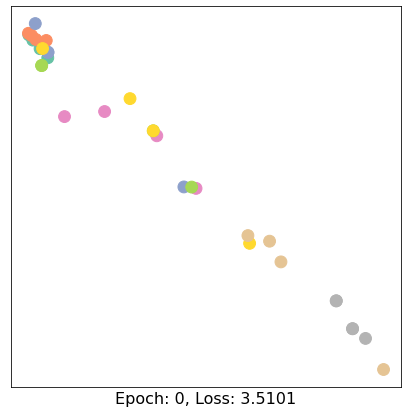

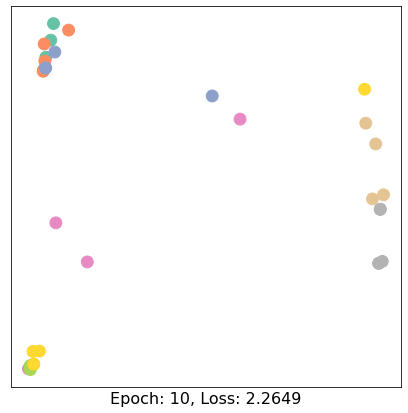

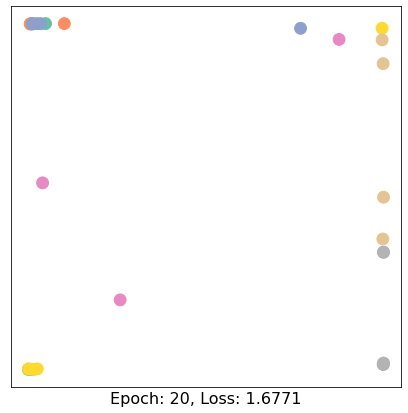

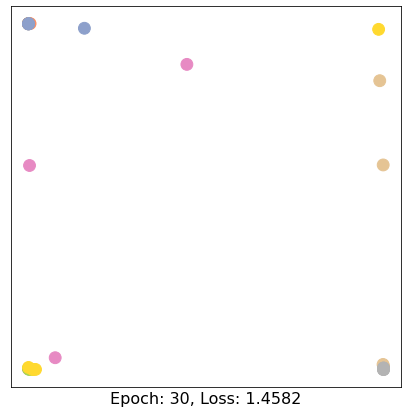

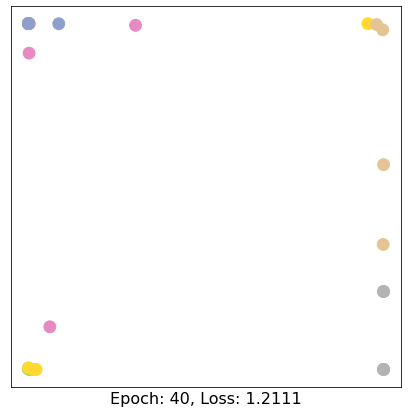

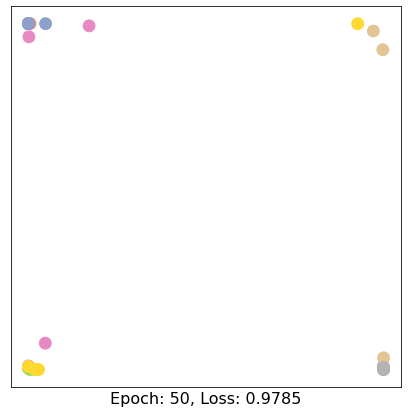

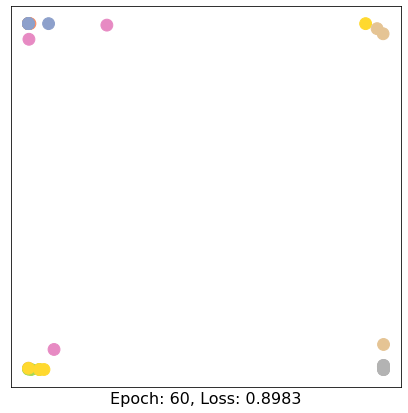

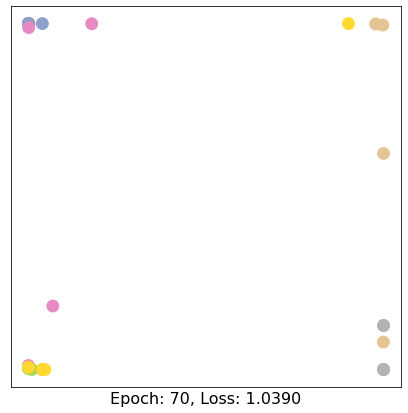

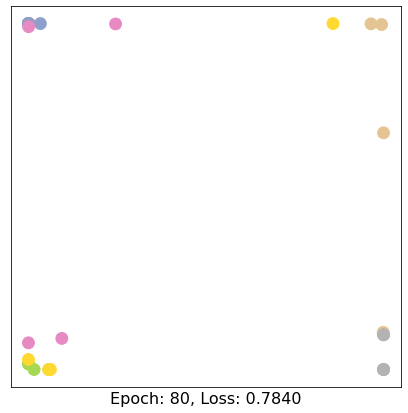

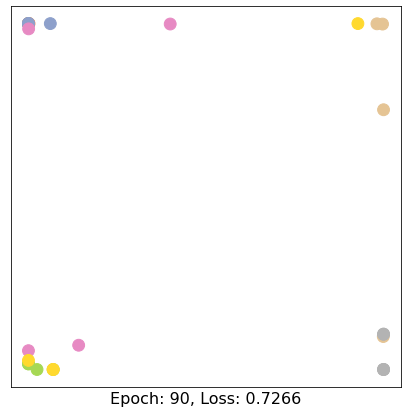

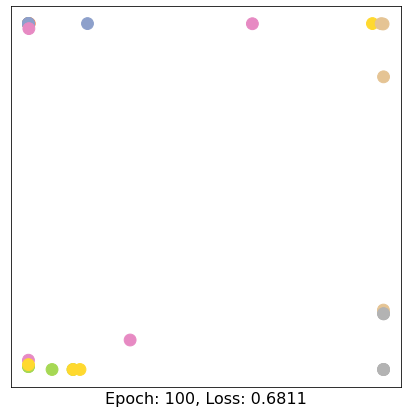

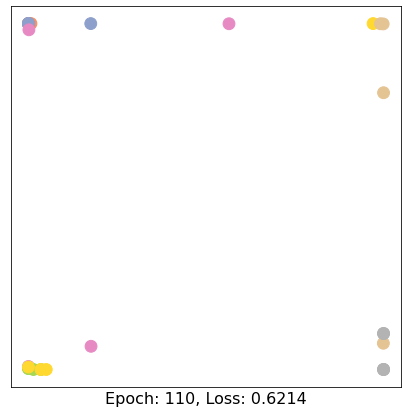

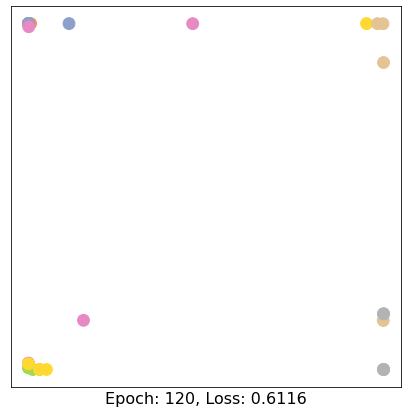

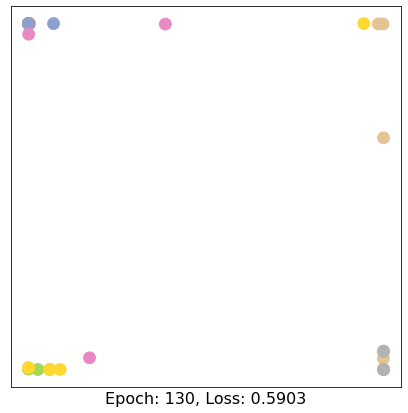

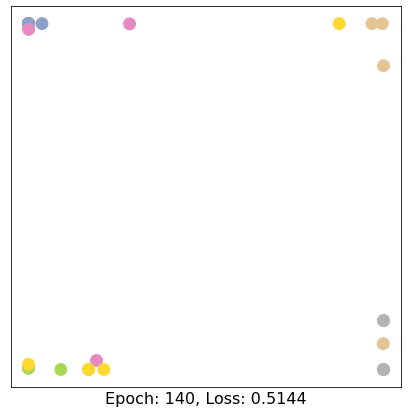

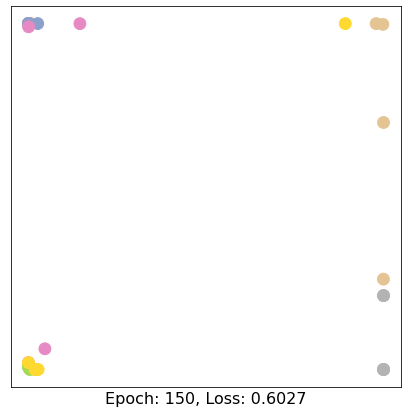

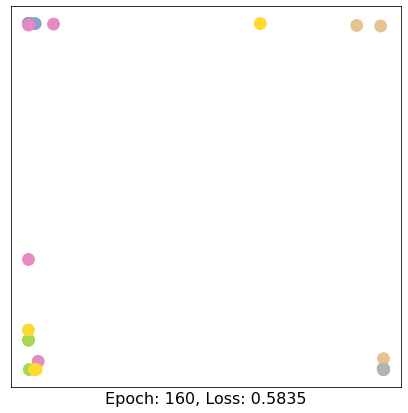

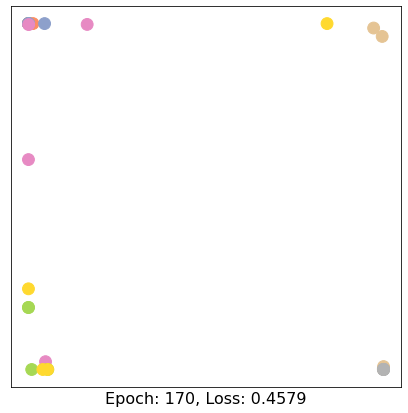

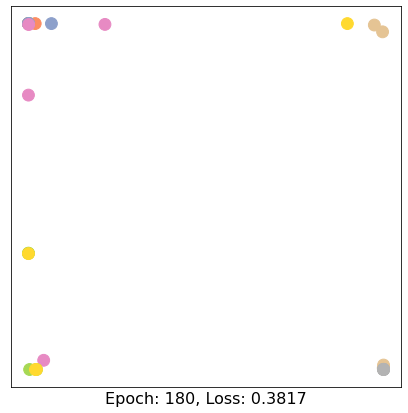

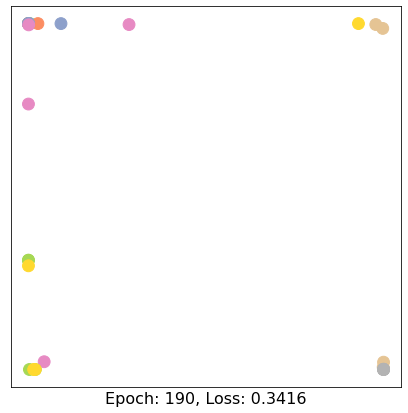

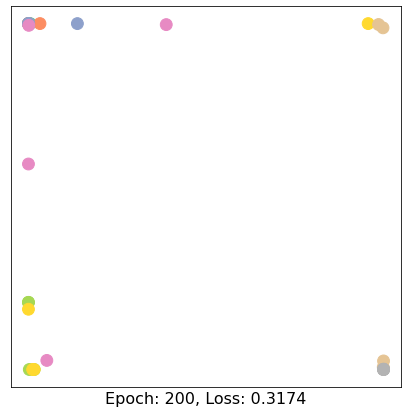

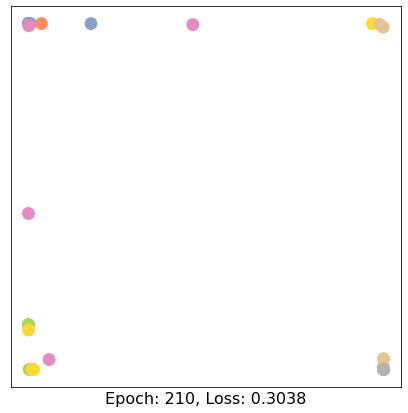

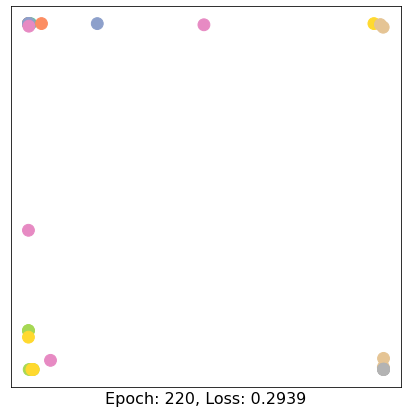

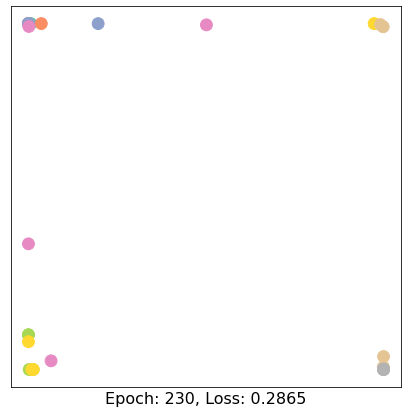

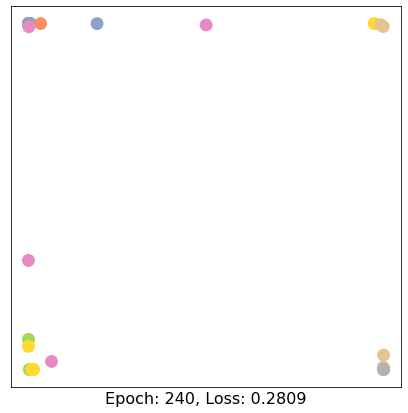

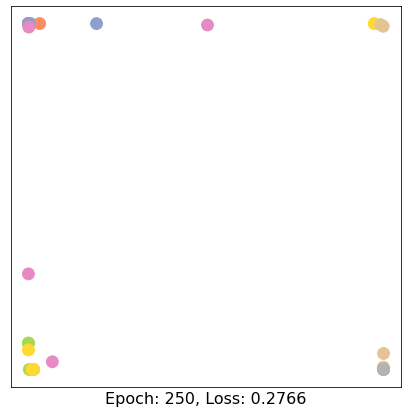

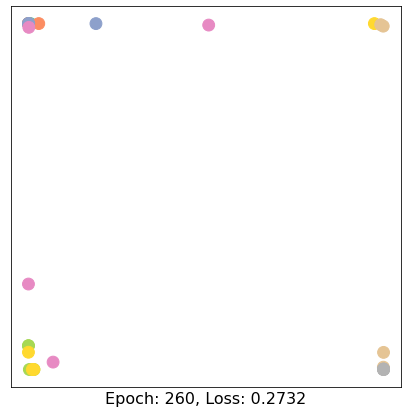

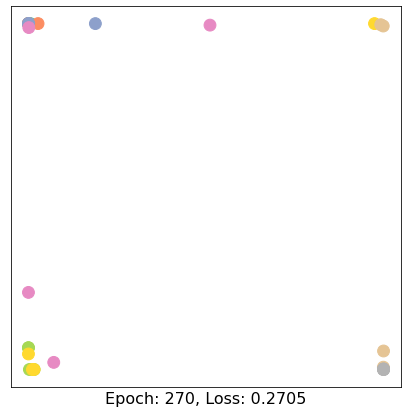

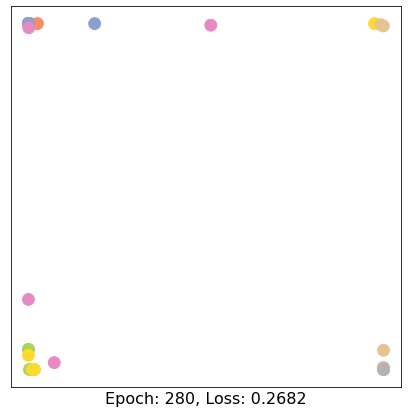

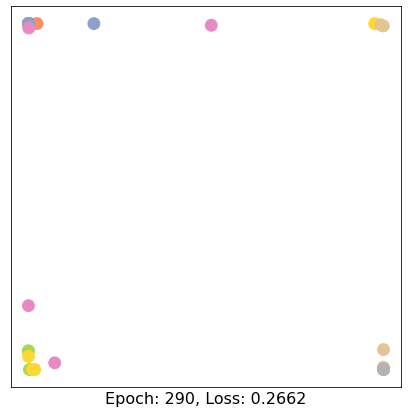

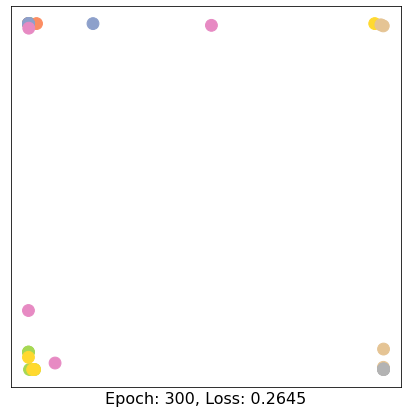

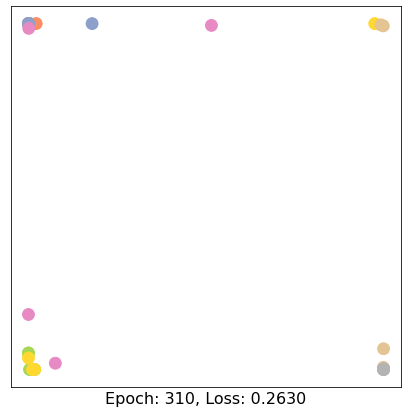

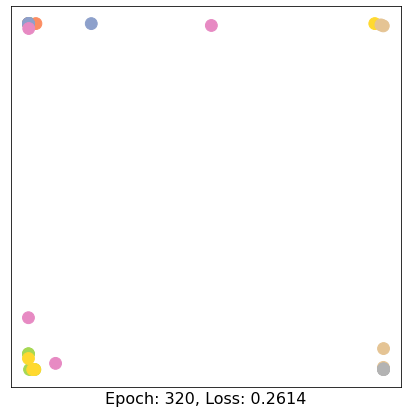

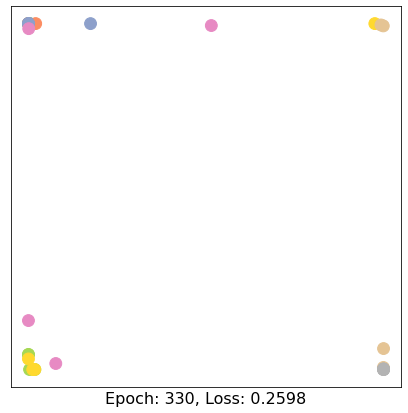

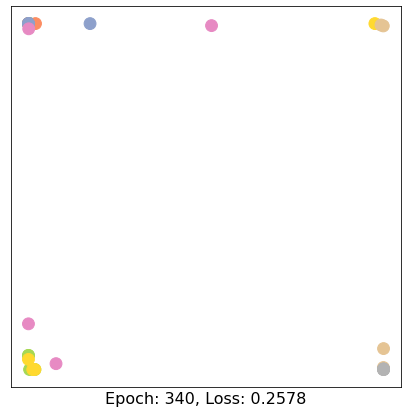

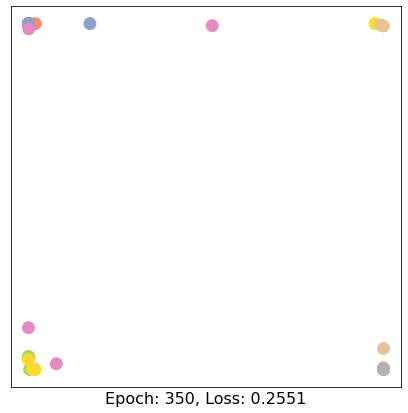

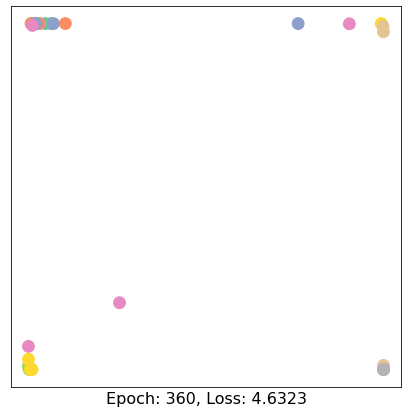

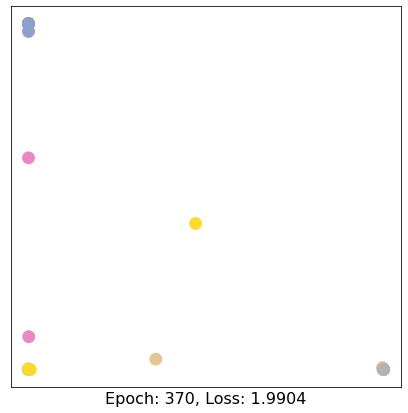

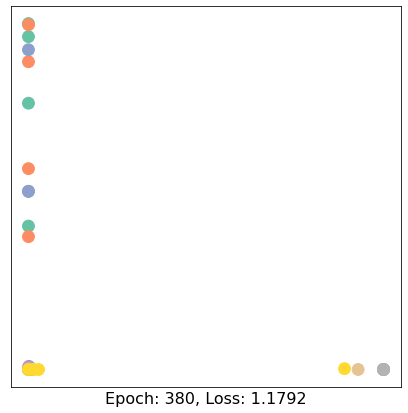

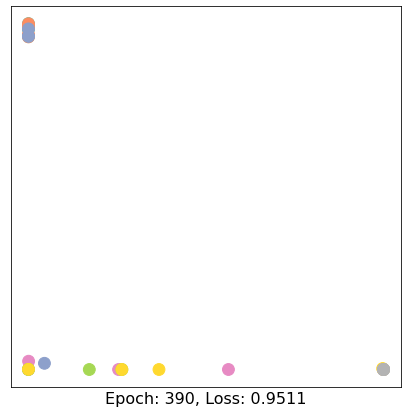

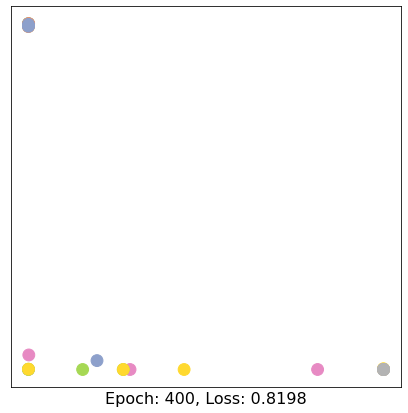

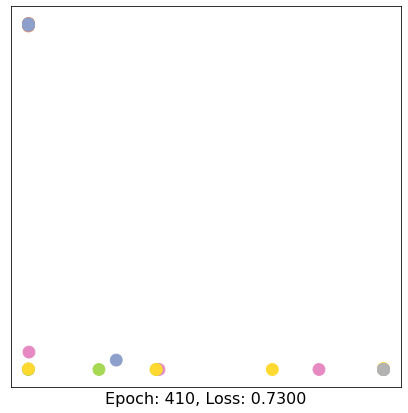

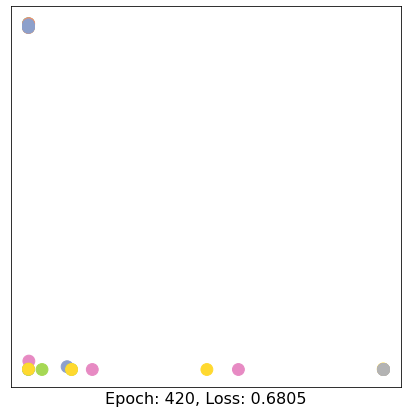

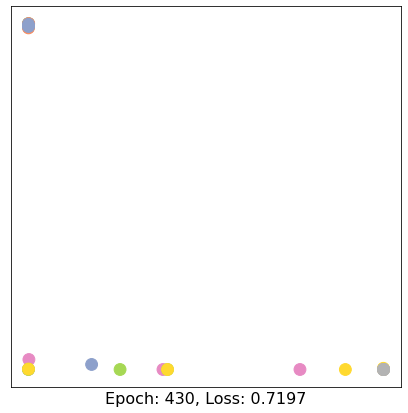

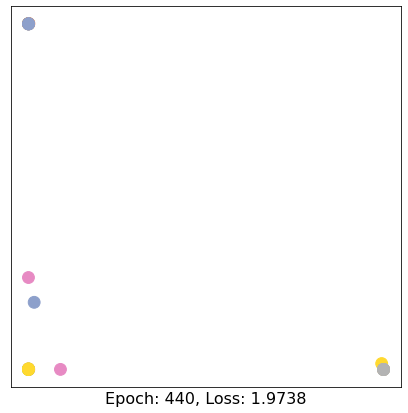

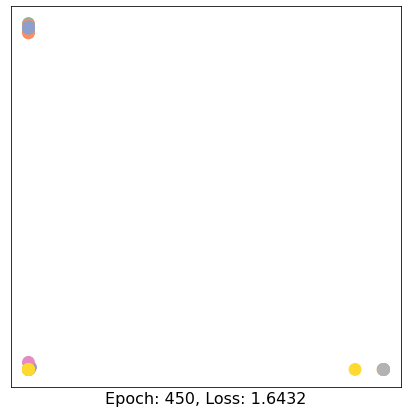

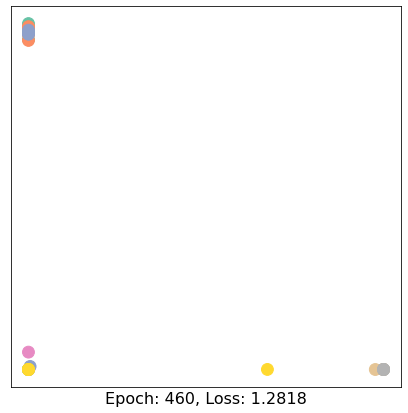

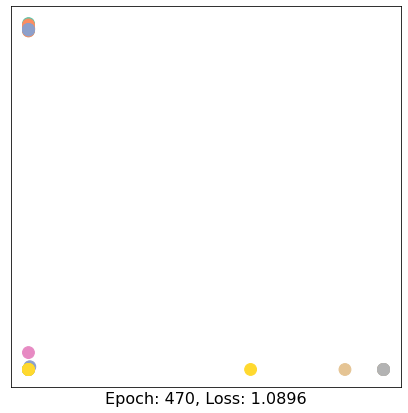

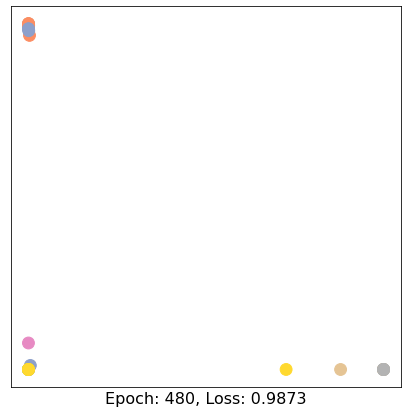

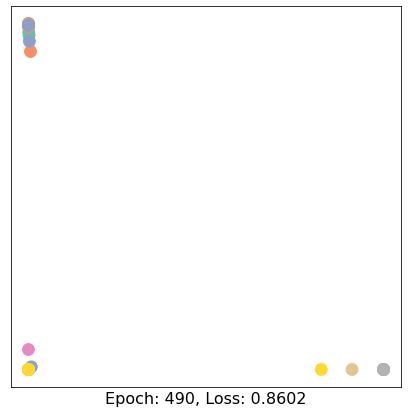

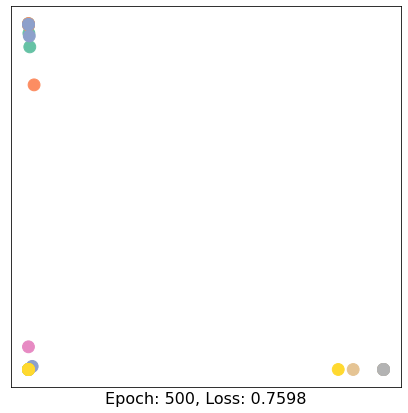

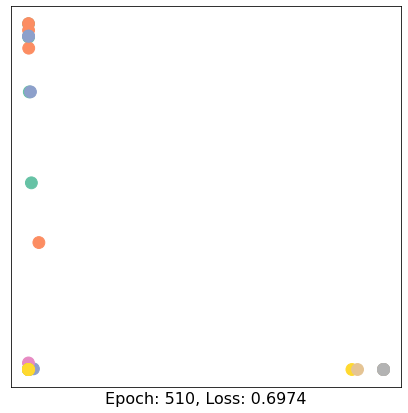

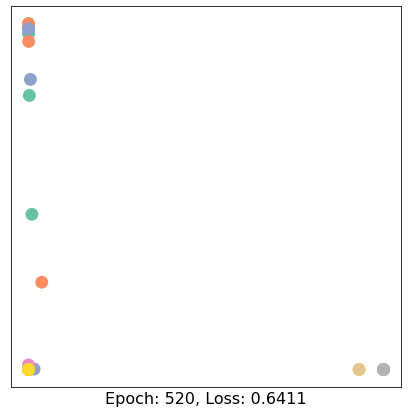

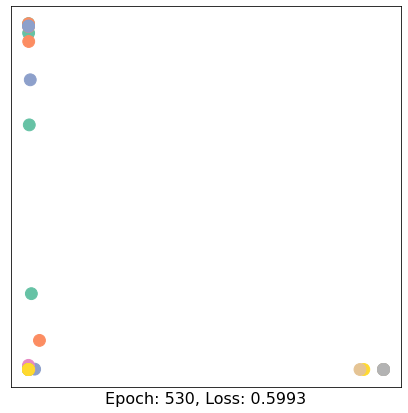

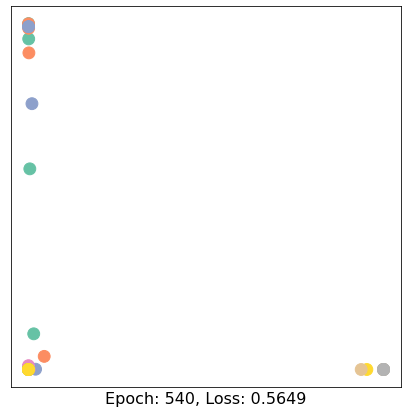

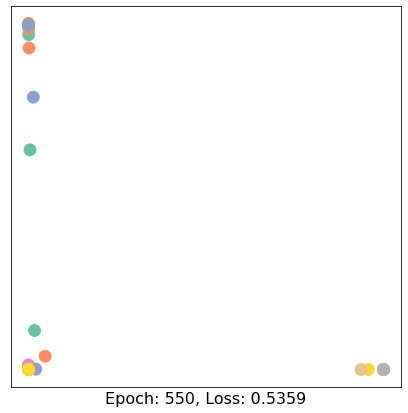

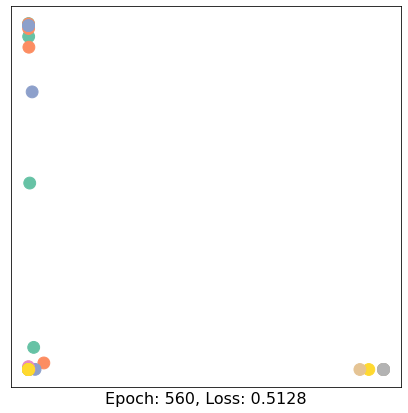

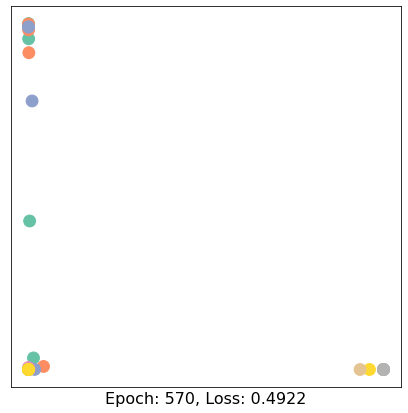

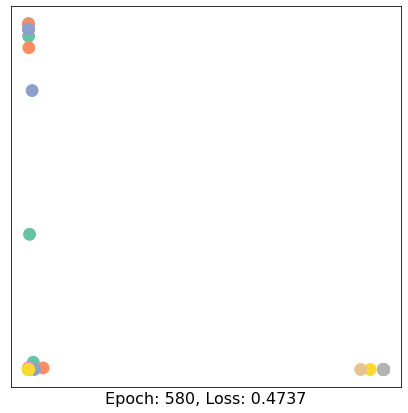

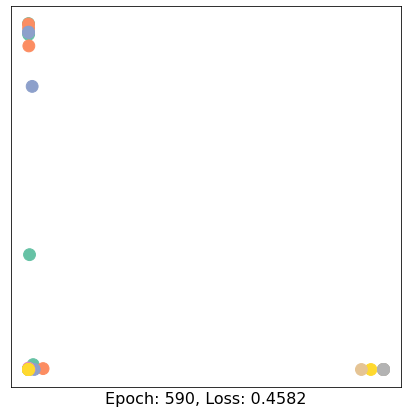

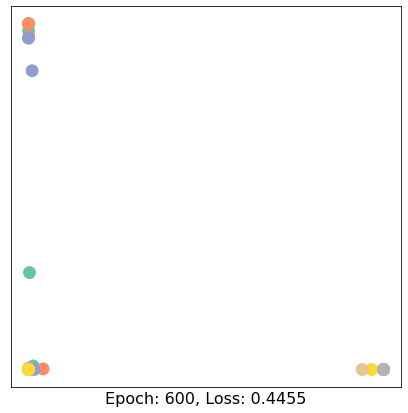

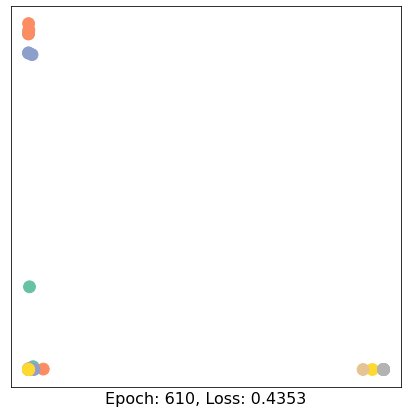

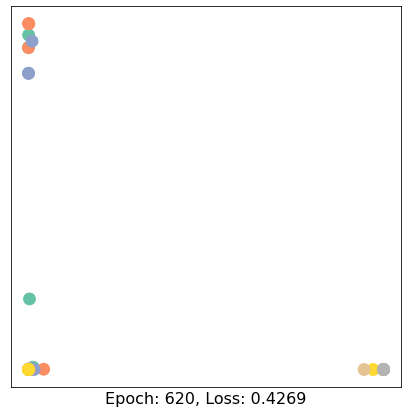

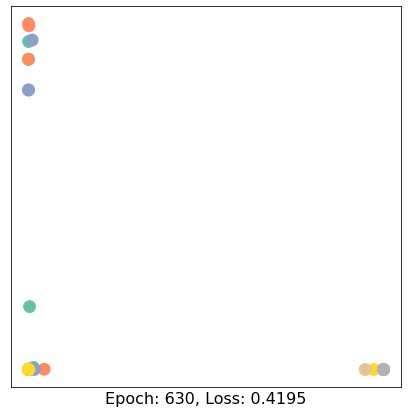

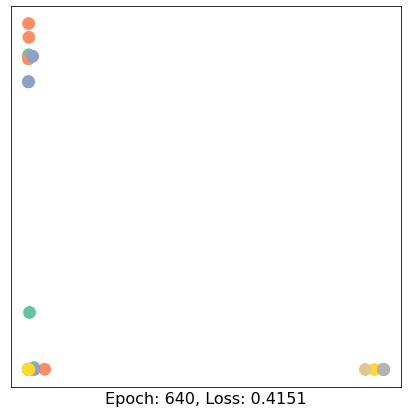

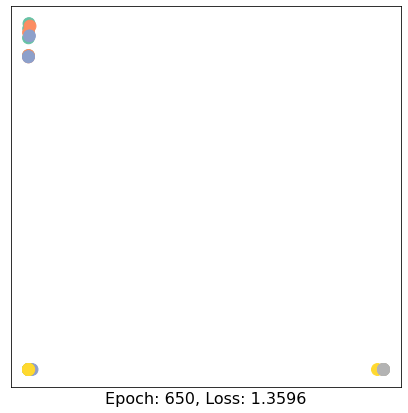

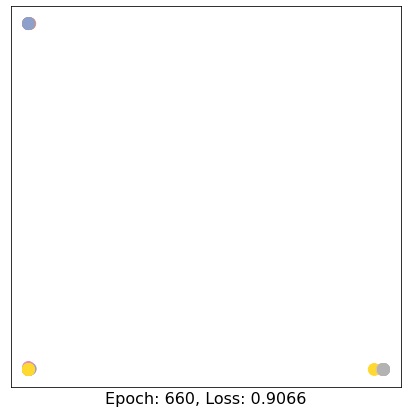

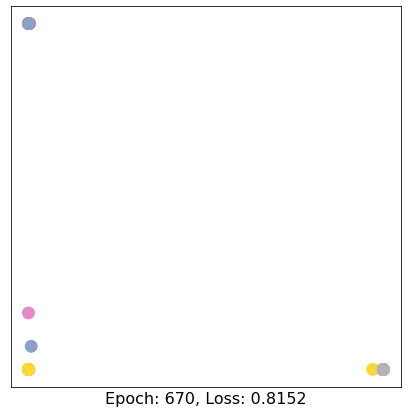

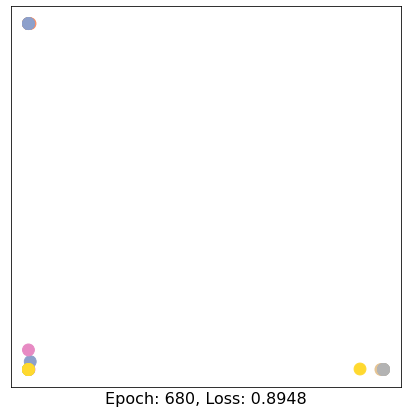

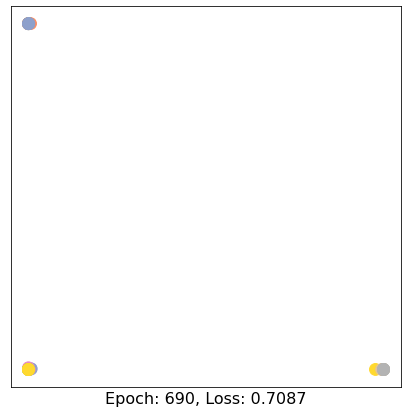

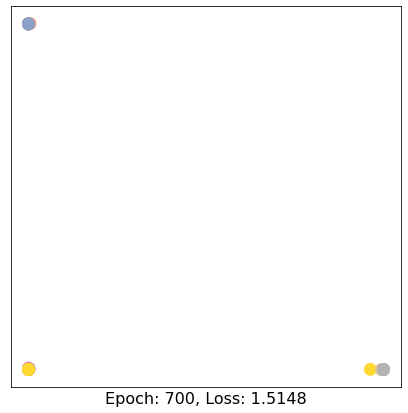

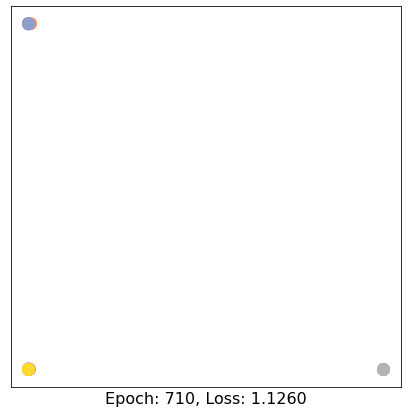

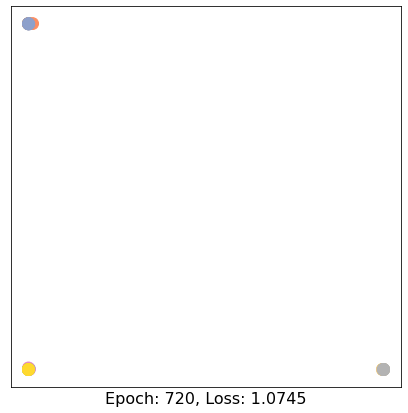

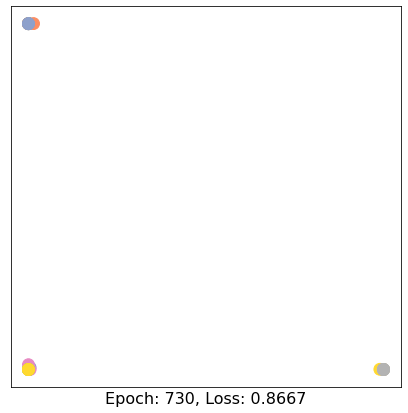

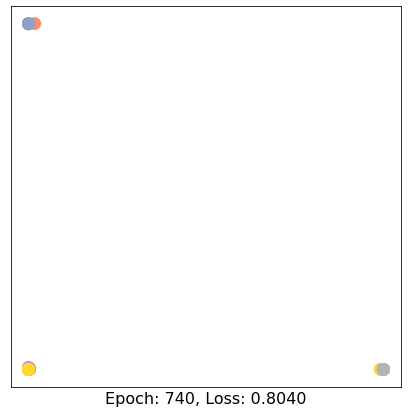

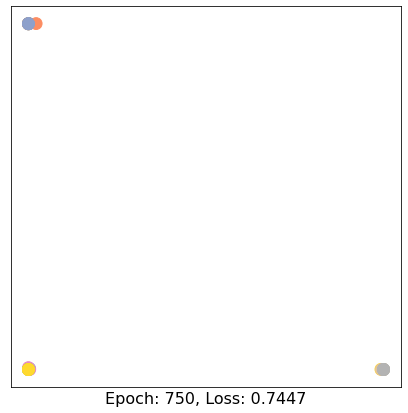

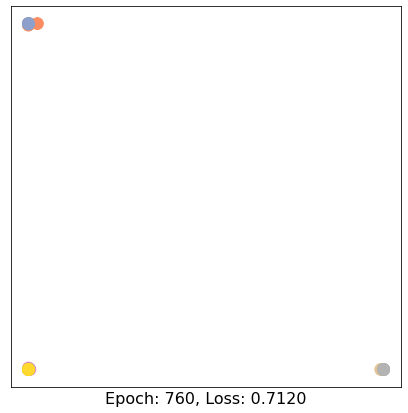

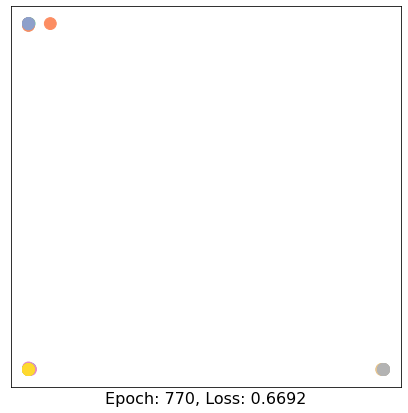

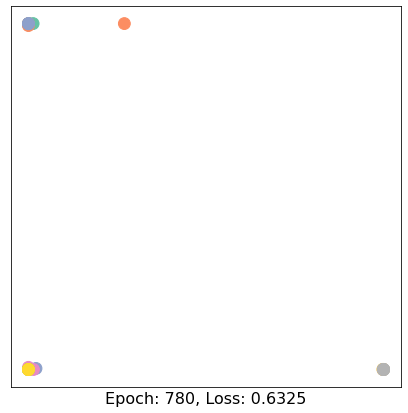

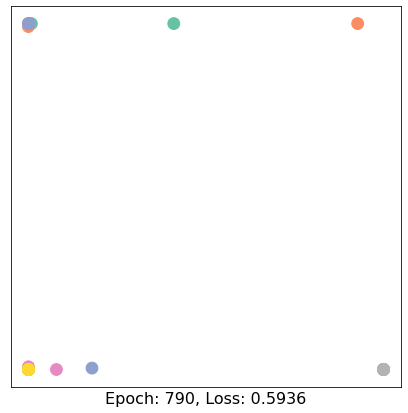

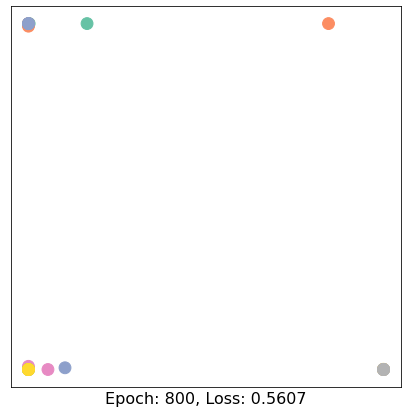

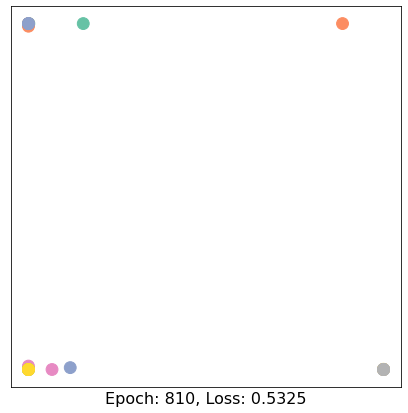

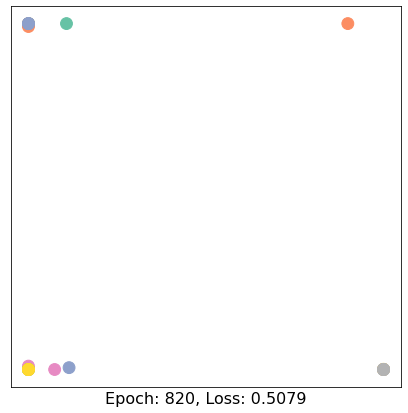

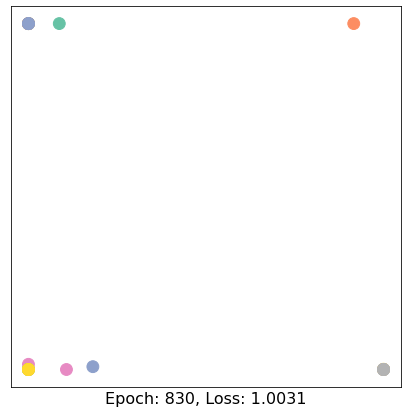

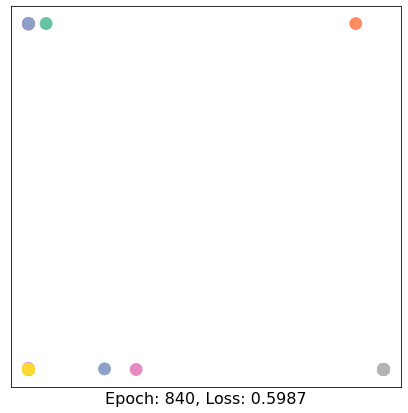

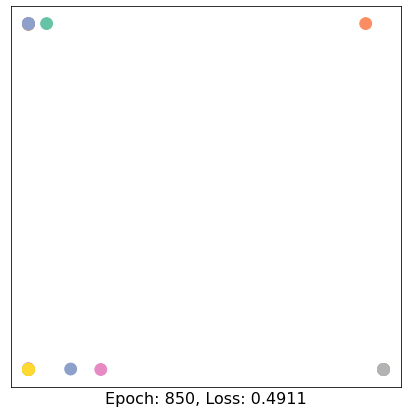

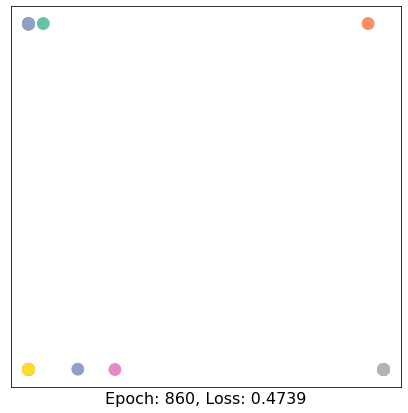

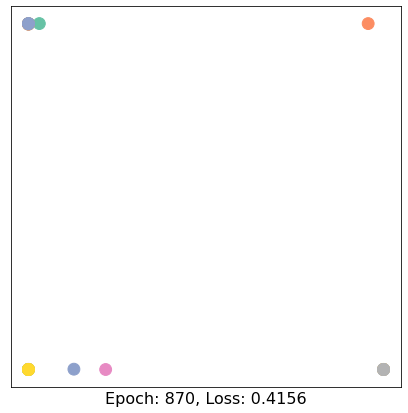

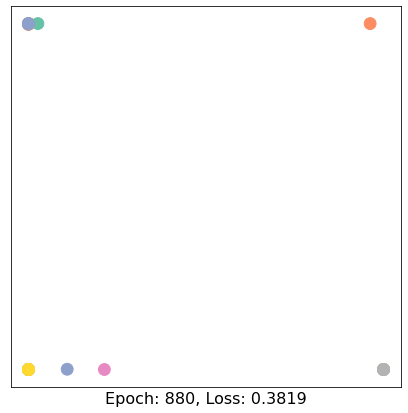

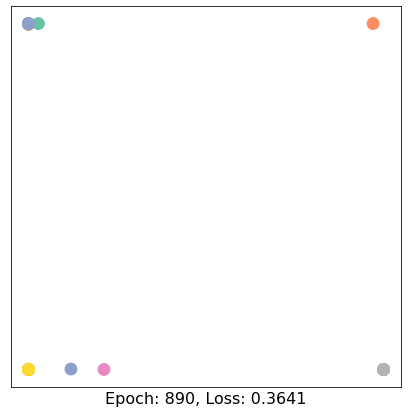

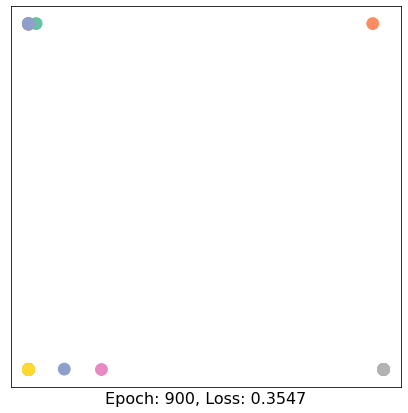

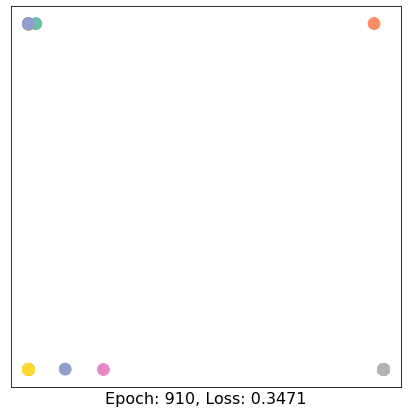

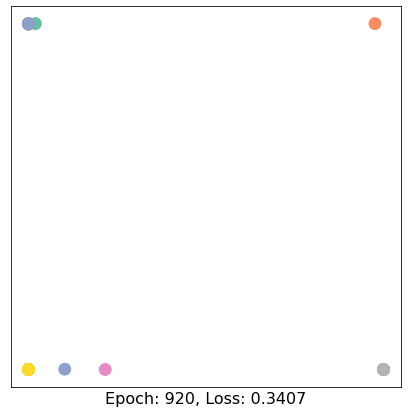

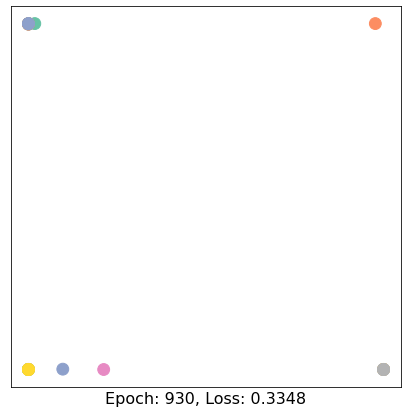

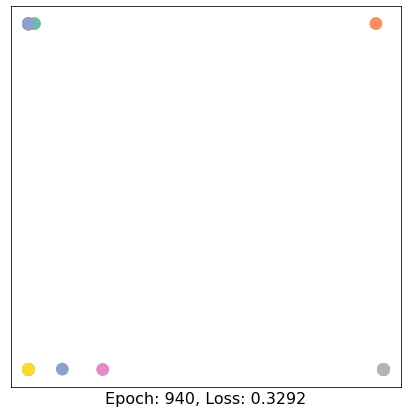

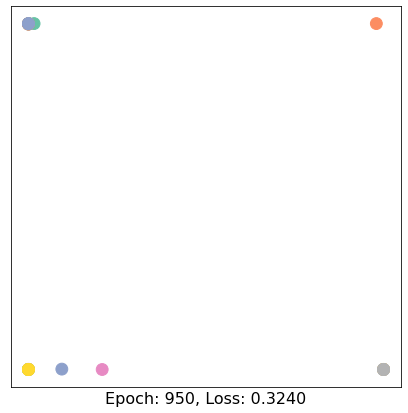

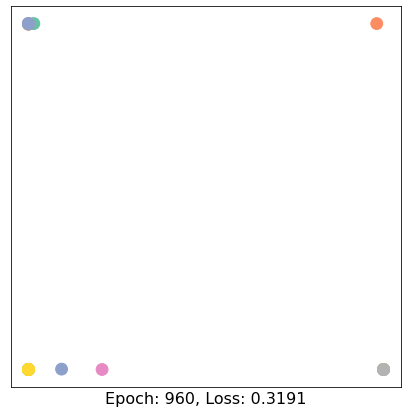

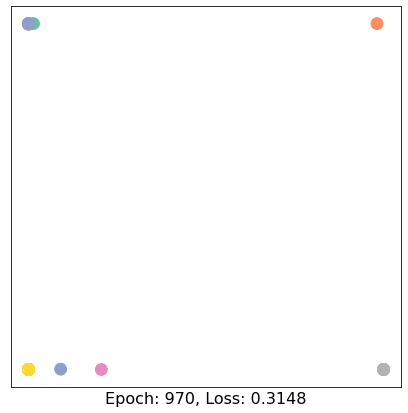

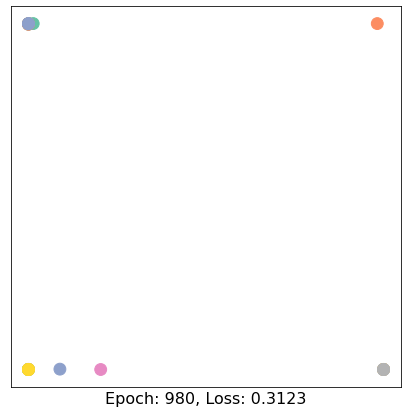

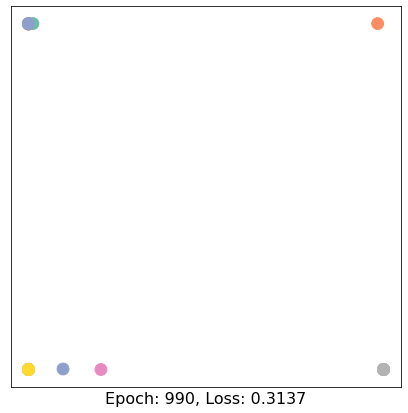

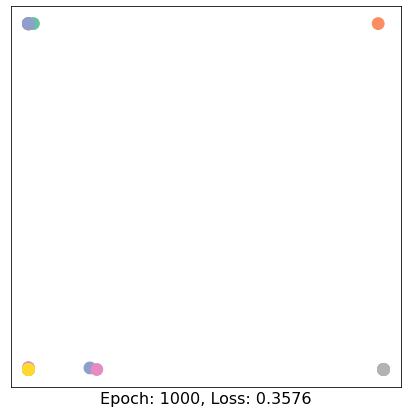

In [53]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN(poseTensor)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

for epoch in range(1001):
    loss, h = train(PoseData)
    if epoch % 10 == 0:
        visualize(h, color=PoseData.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

### 4. Face Training

<IPython.core.display.Javascript object>

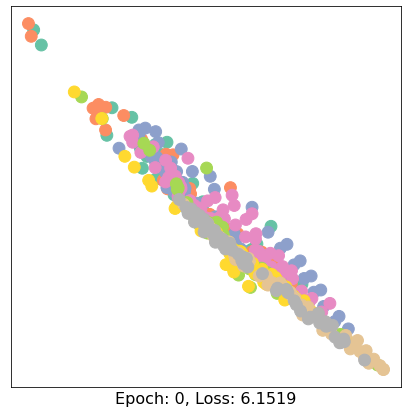

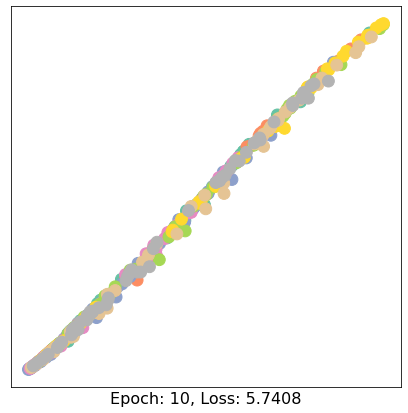

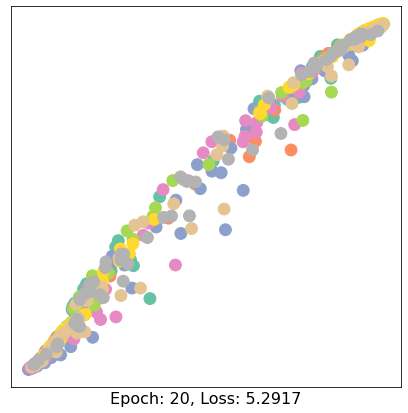

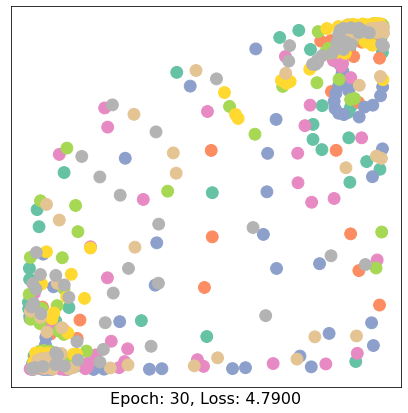

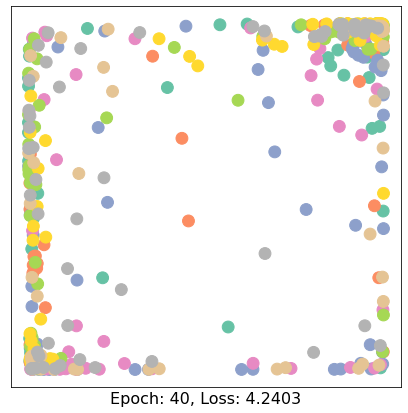

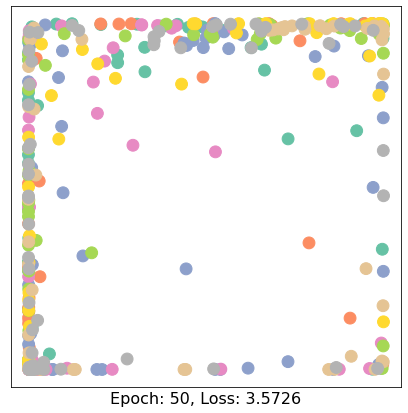

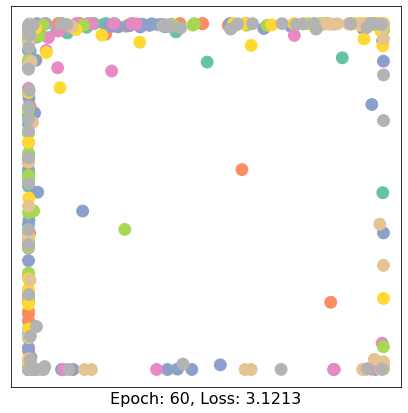

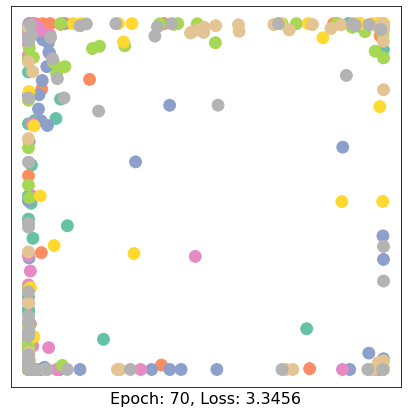

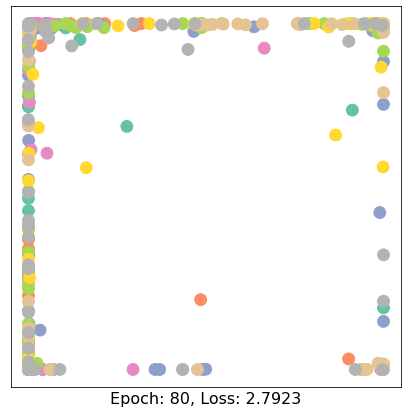

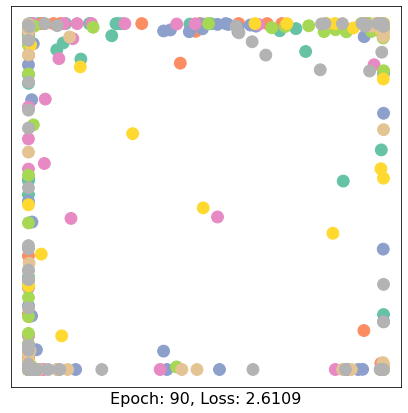

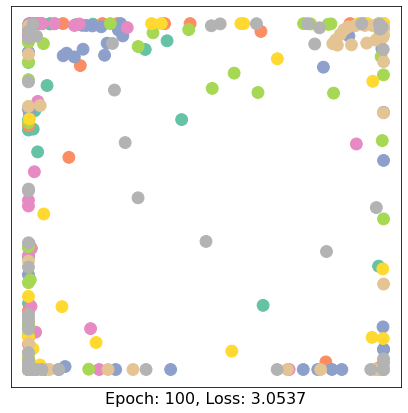

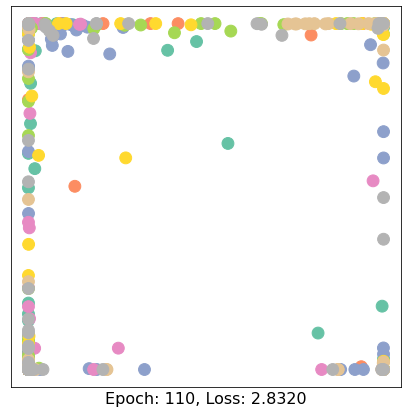

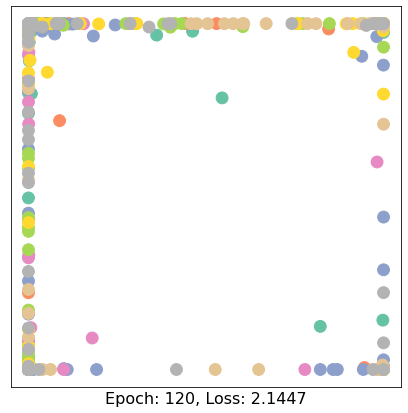

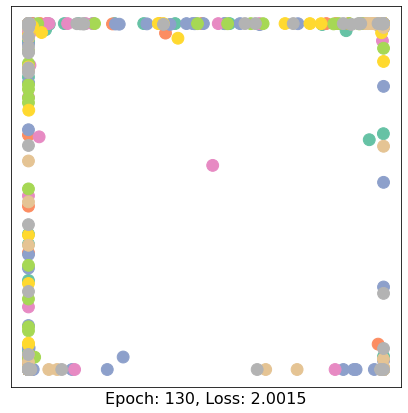

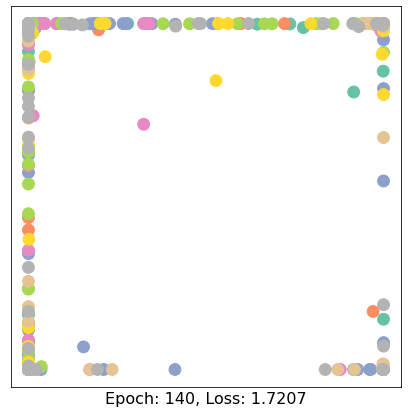

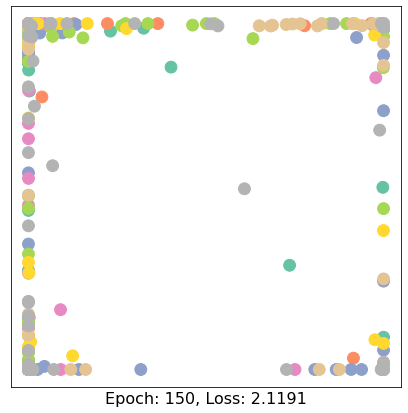

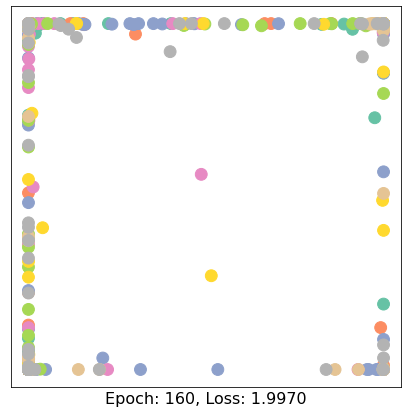

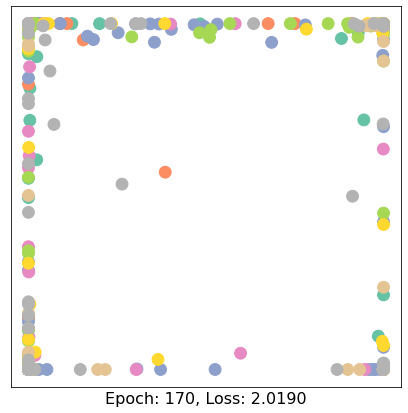

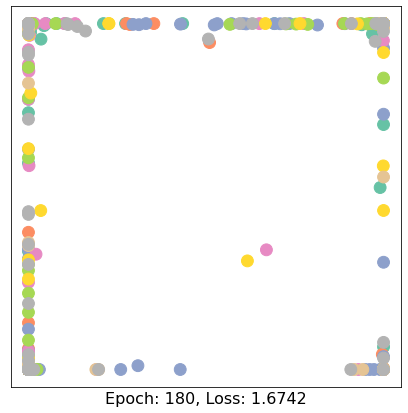

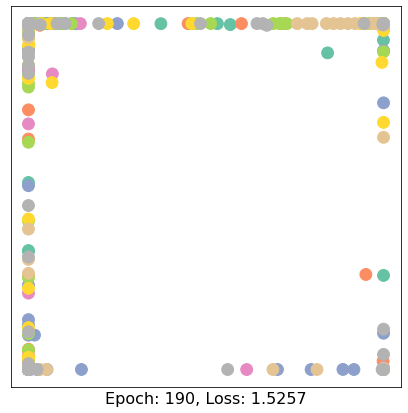

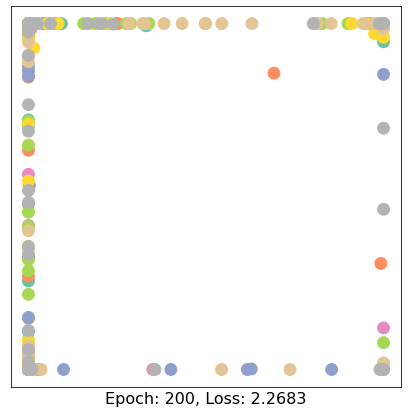

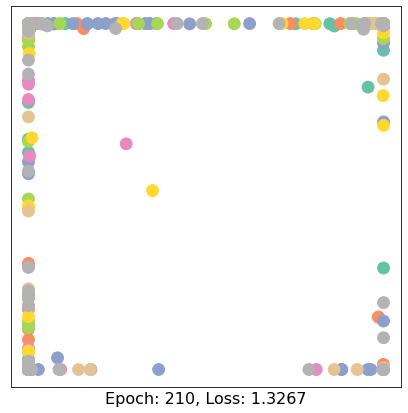

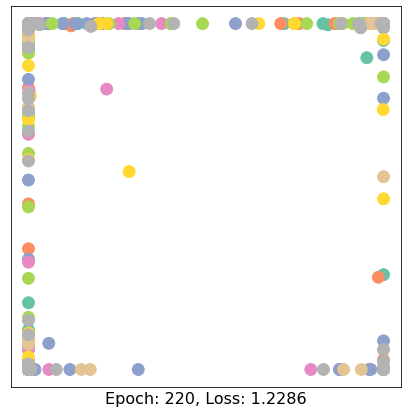

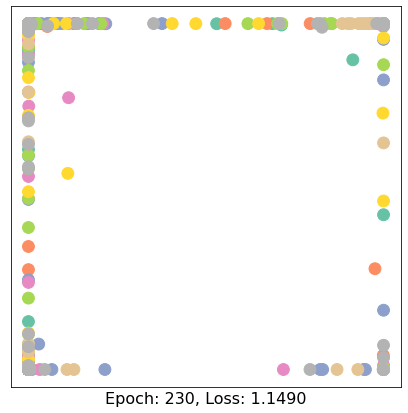

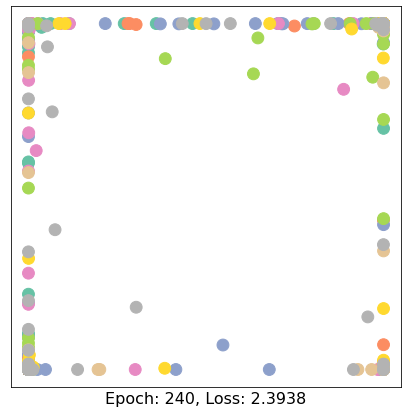

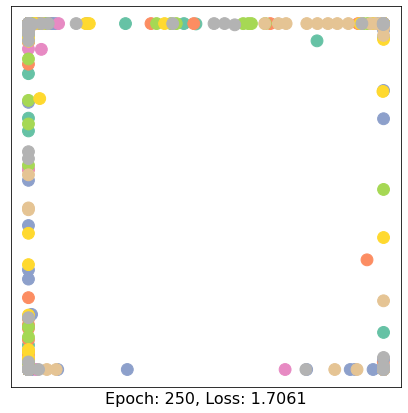

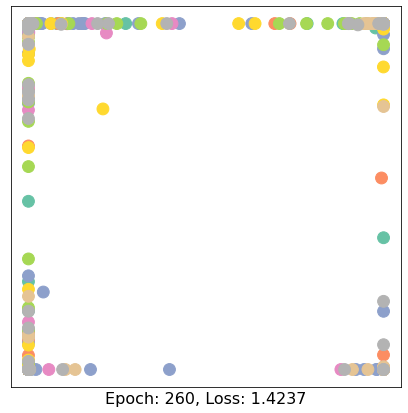

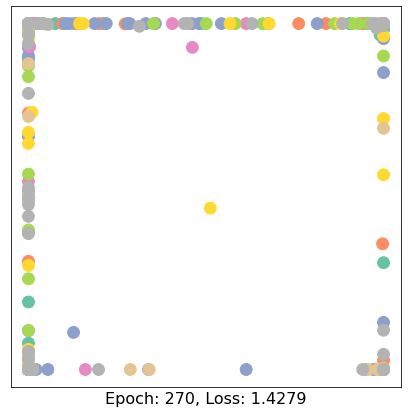

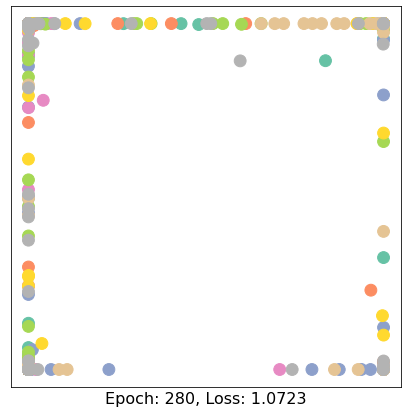

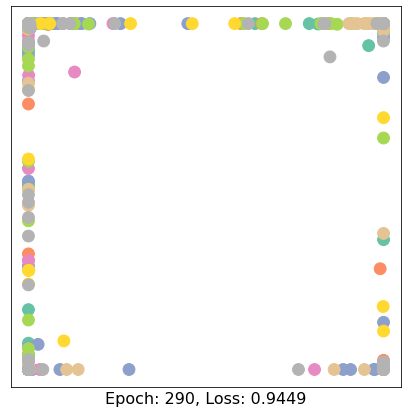

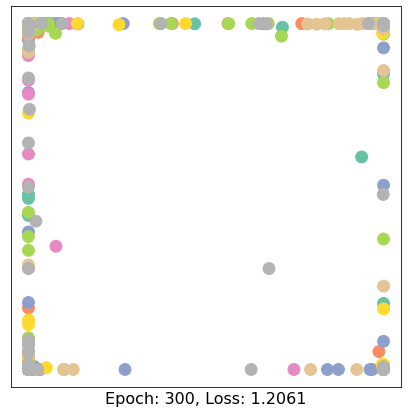

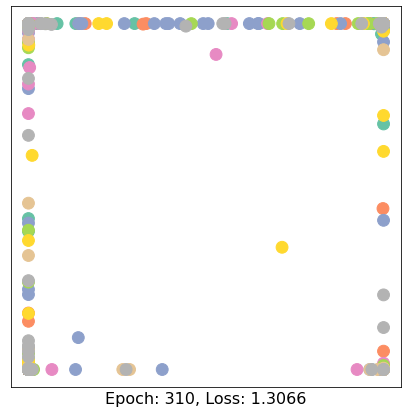

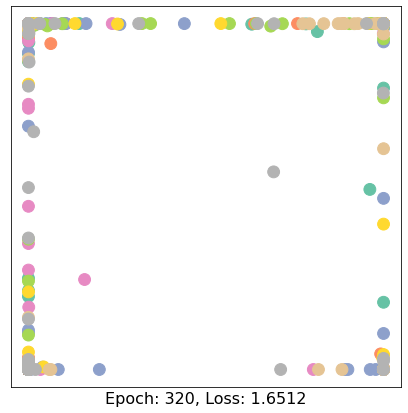

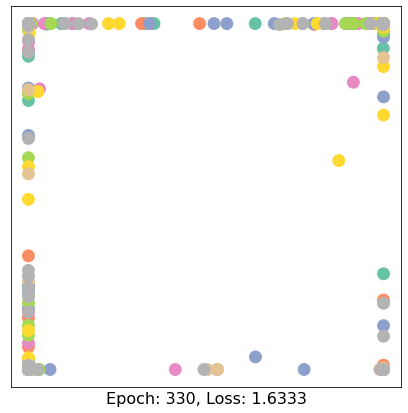

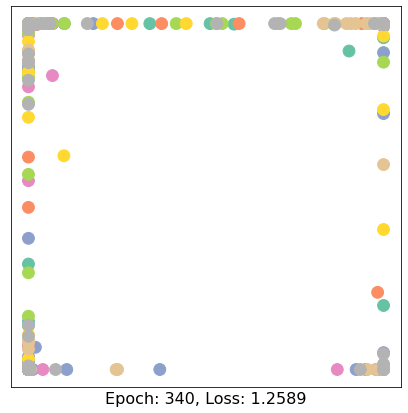

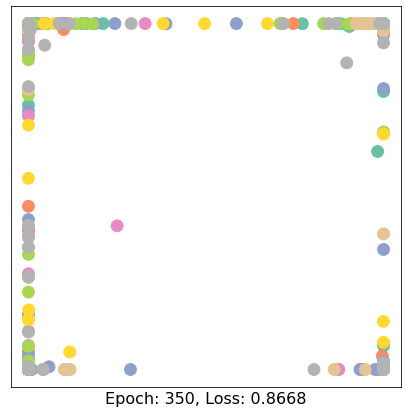

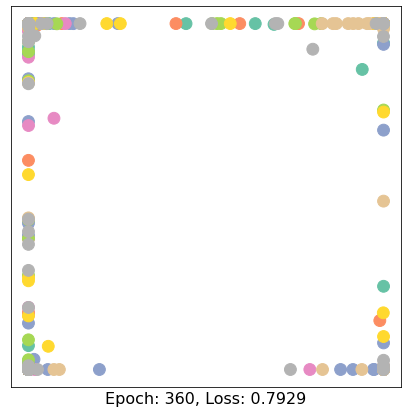

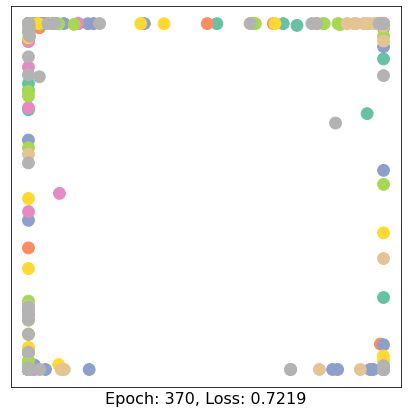

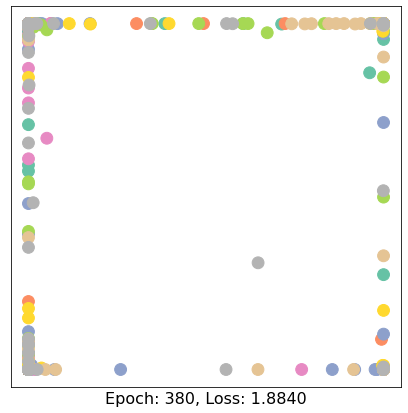

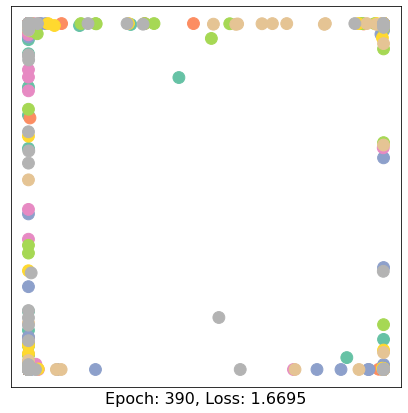

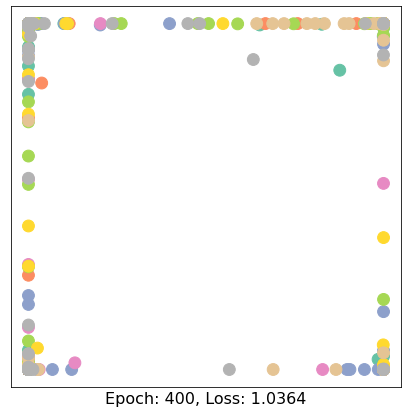

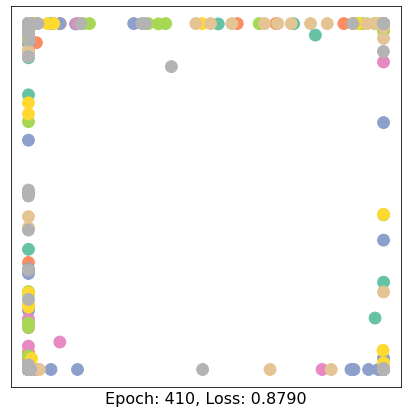

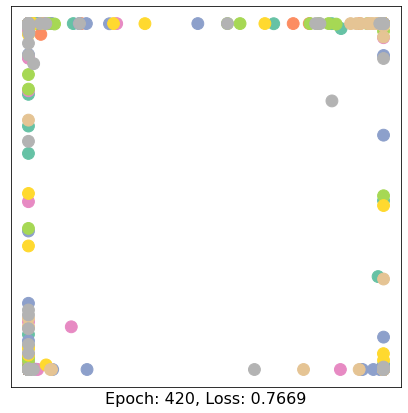

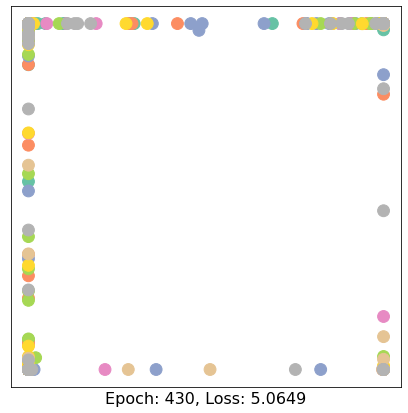

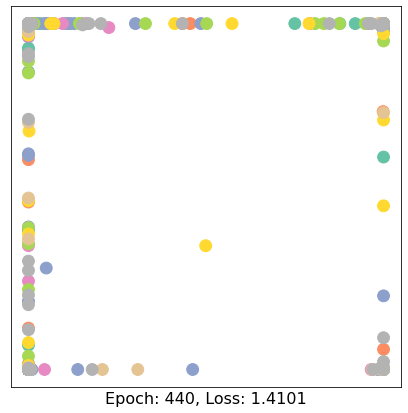

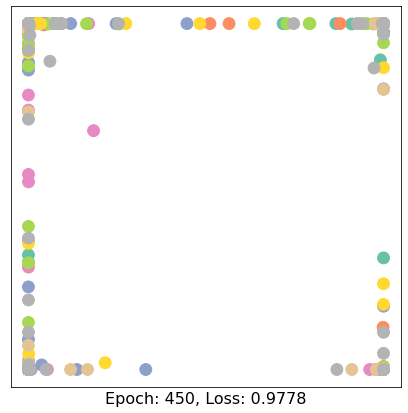

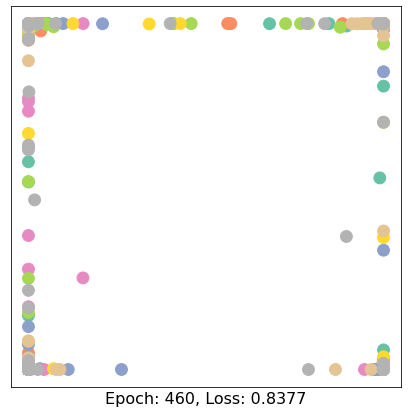

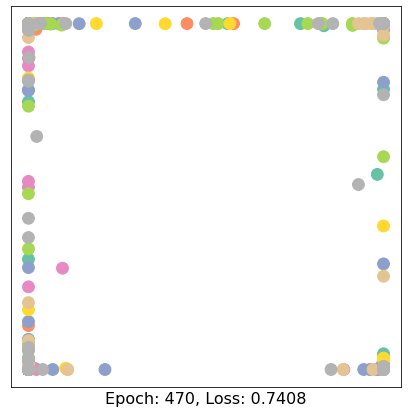

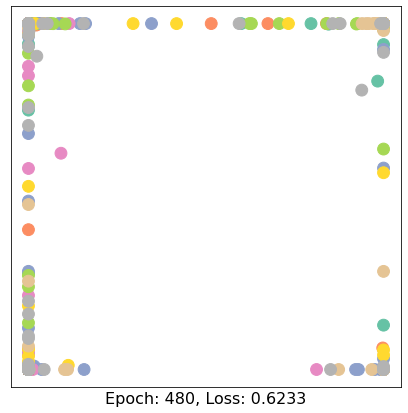

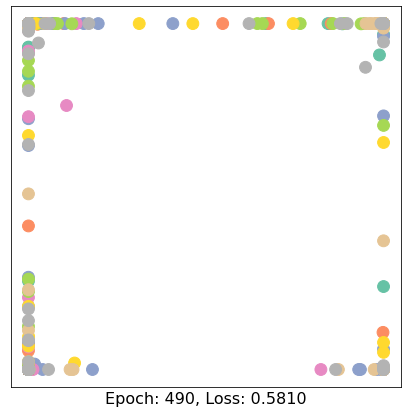

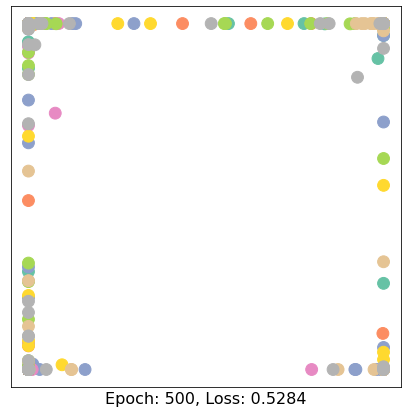

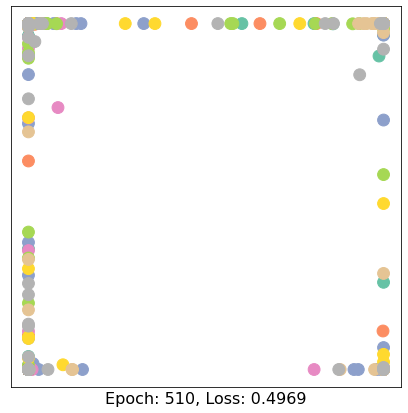

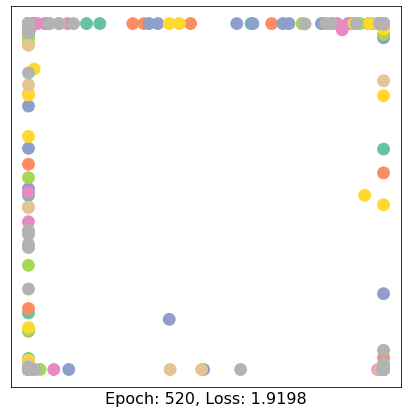

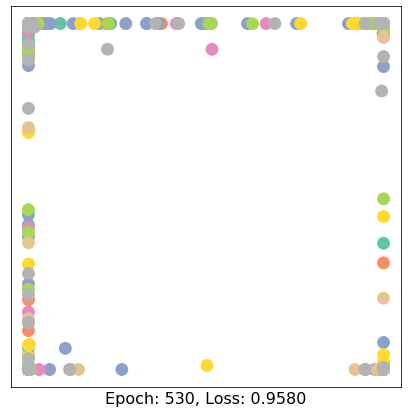

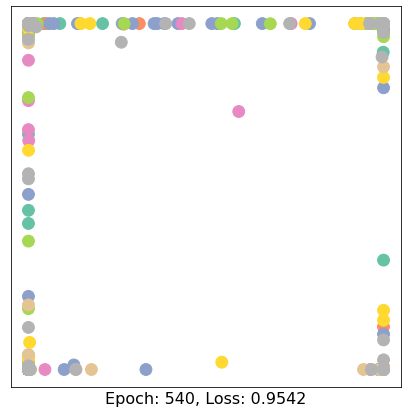

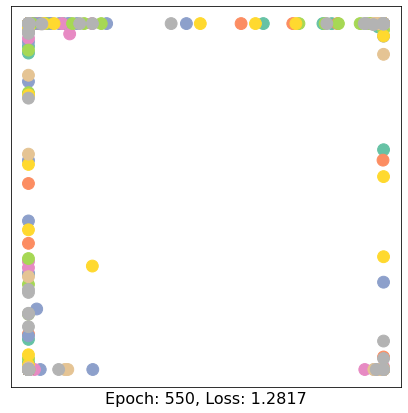

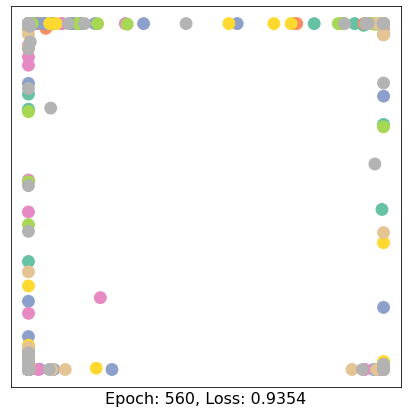

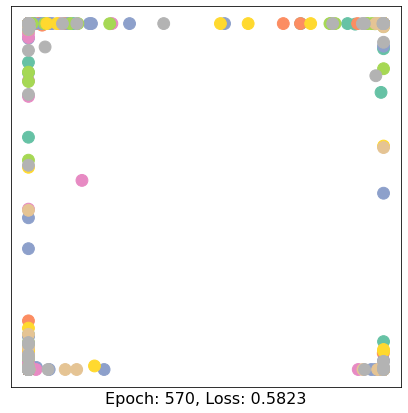

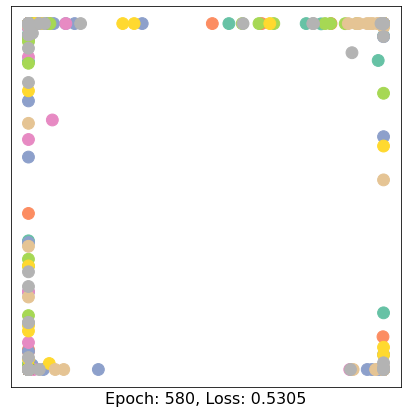

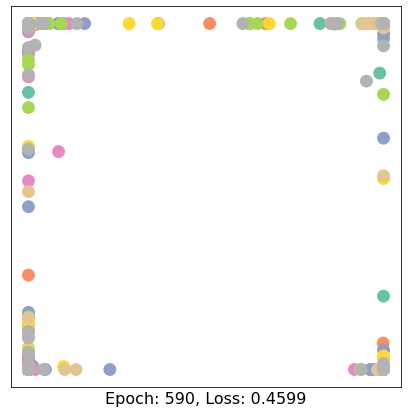

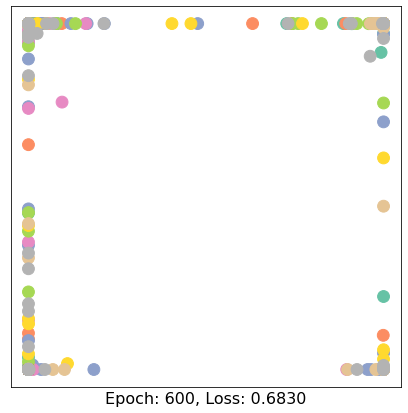

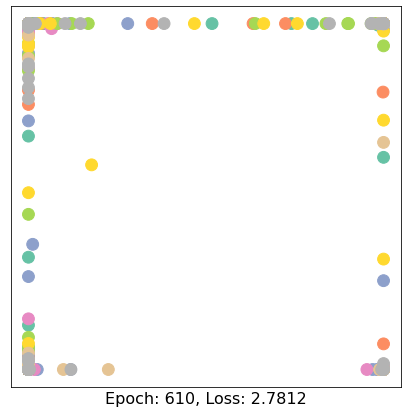

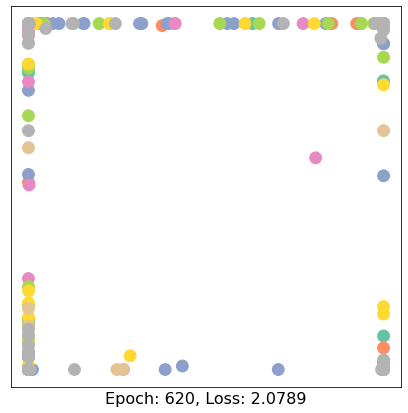

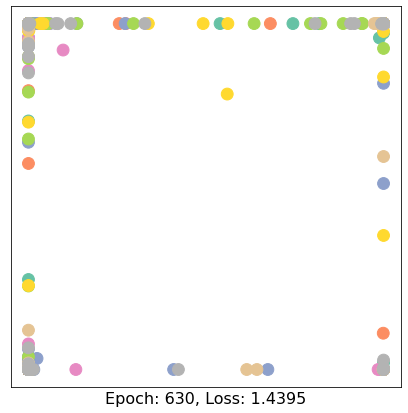

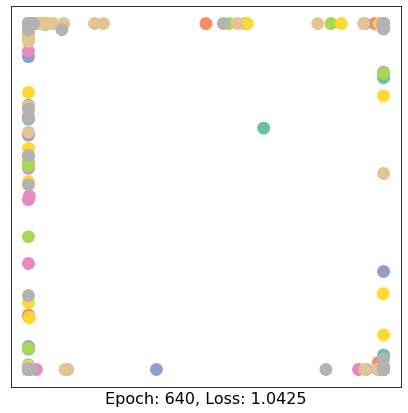

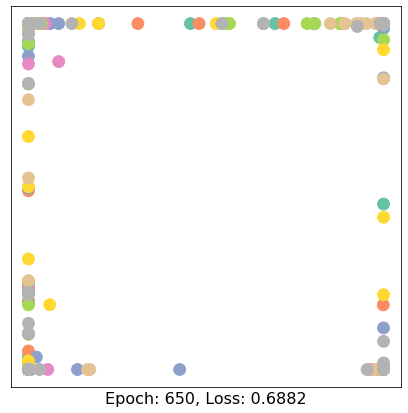

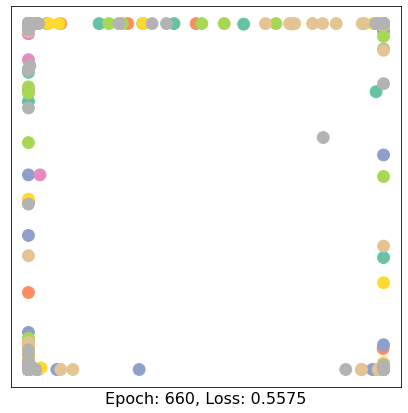

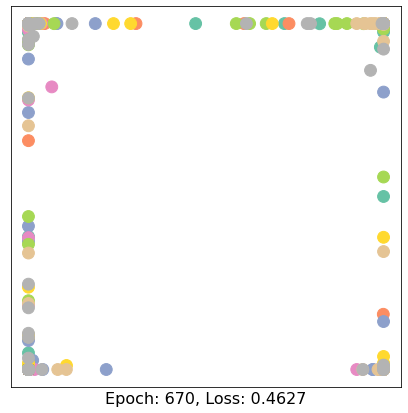

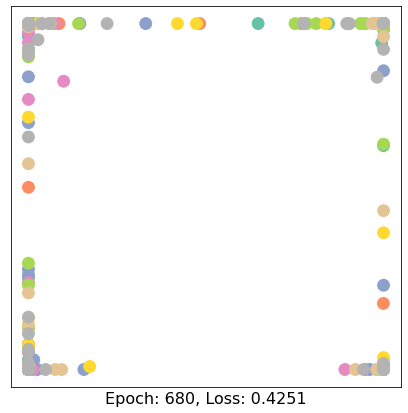

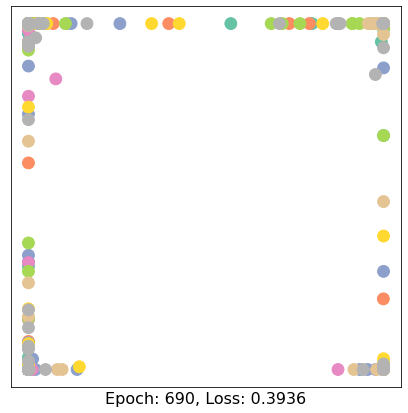

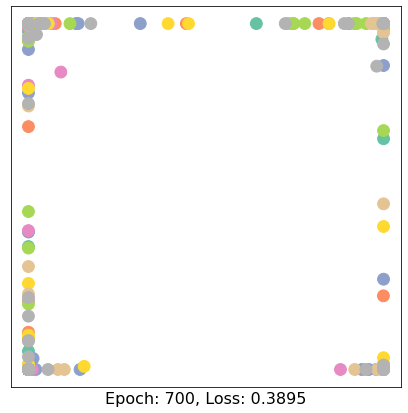

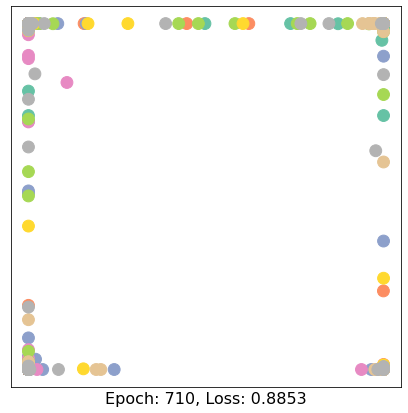

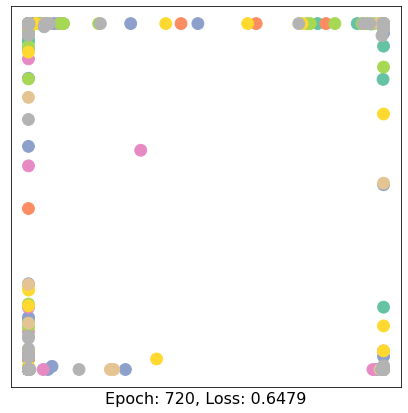

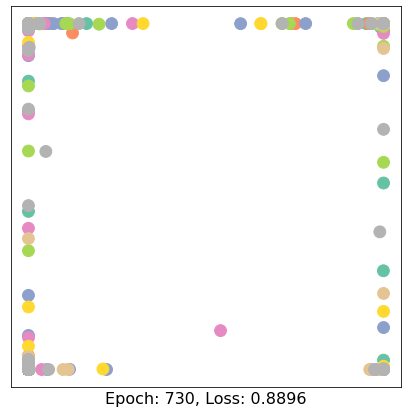

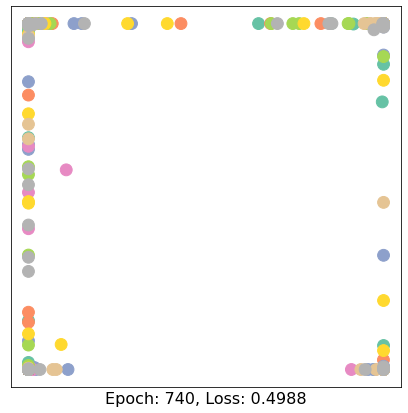

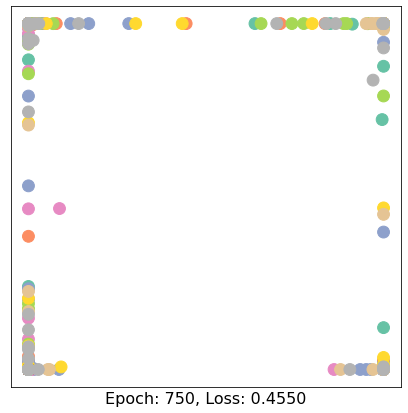

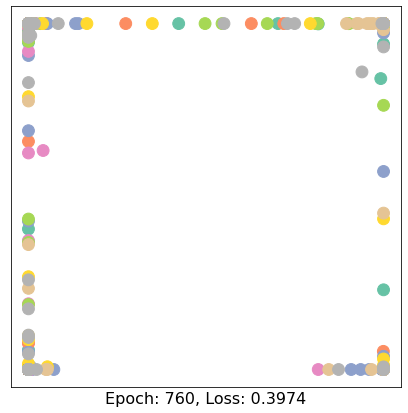

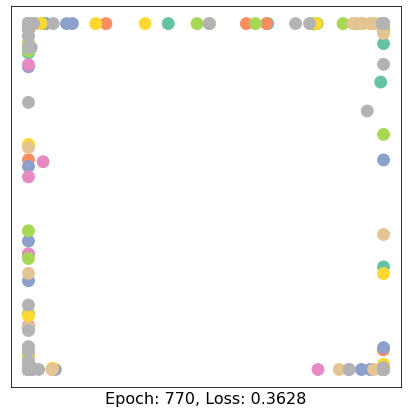

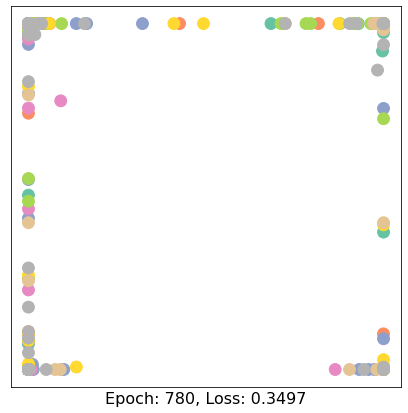

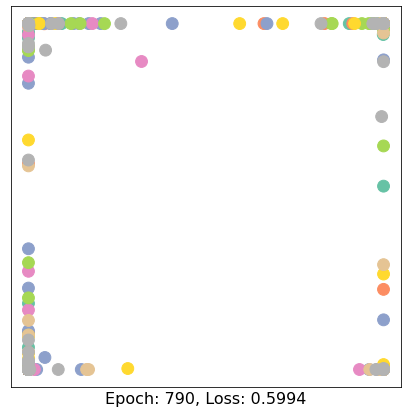

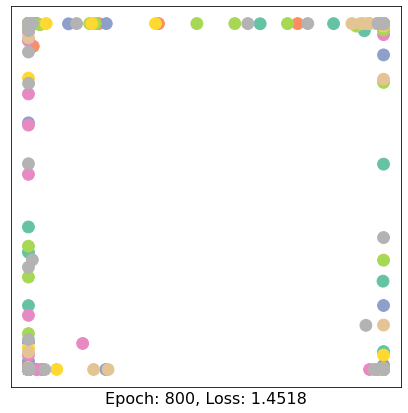

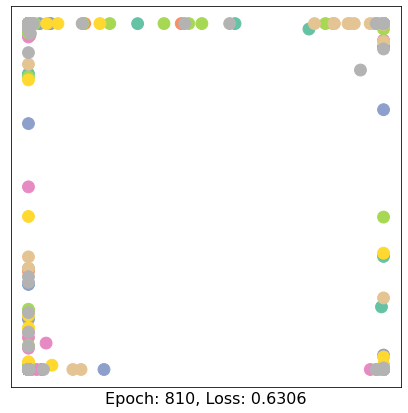

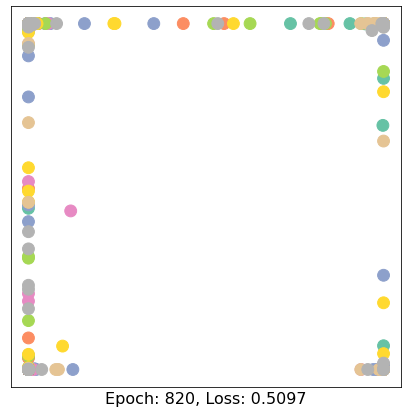

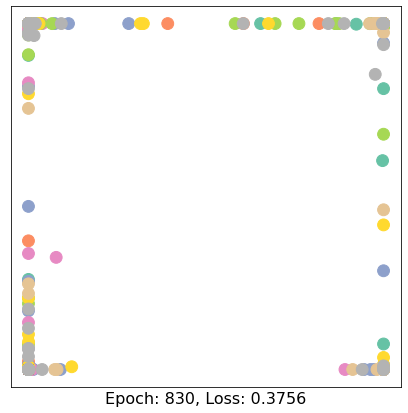

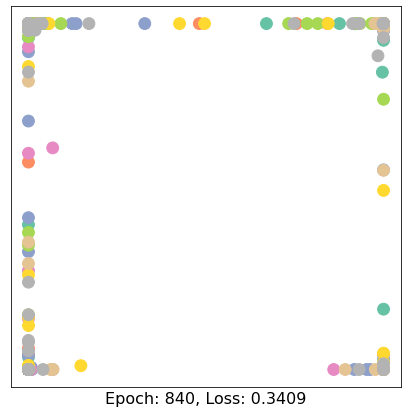

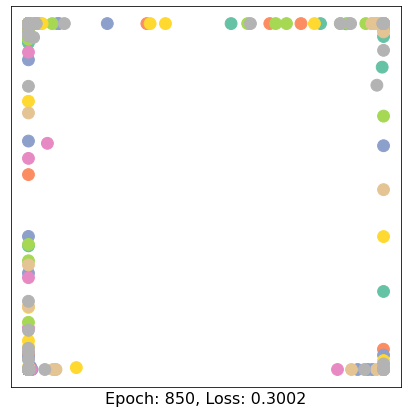

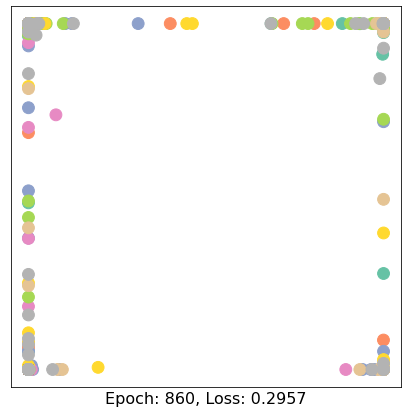

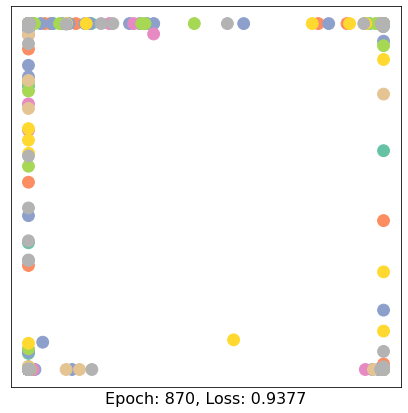

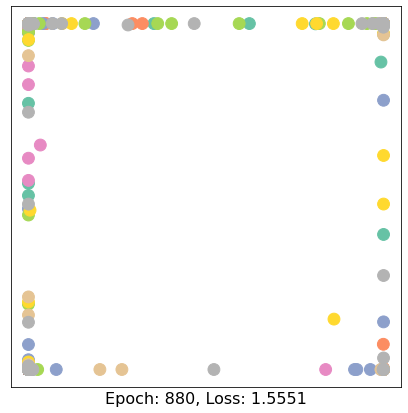

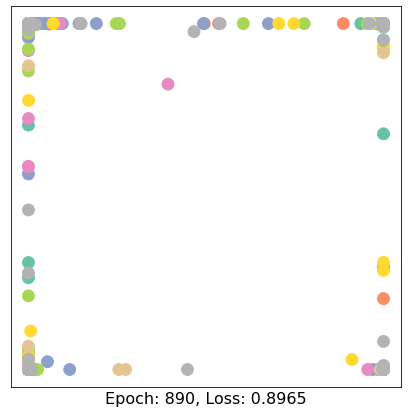

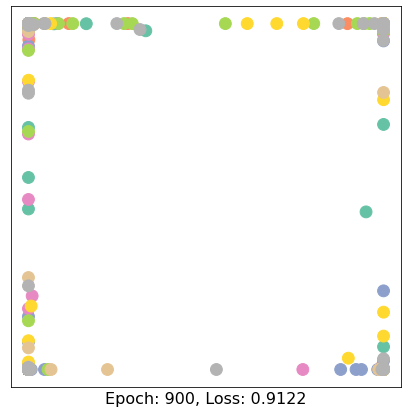

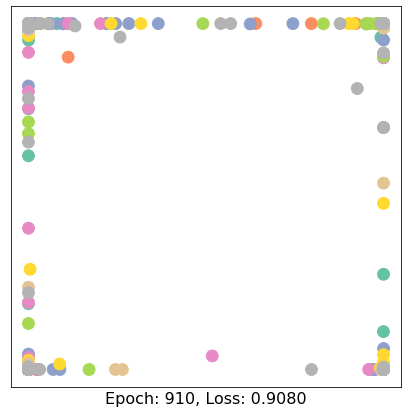

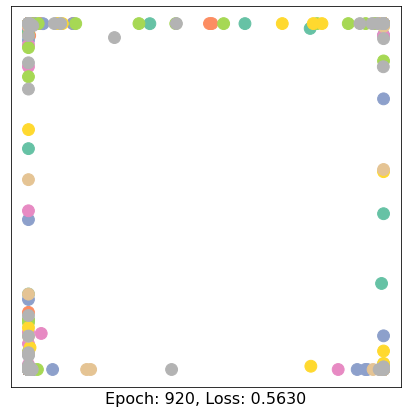

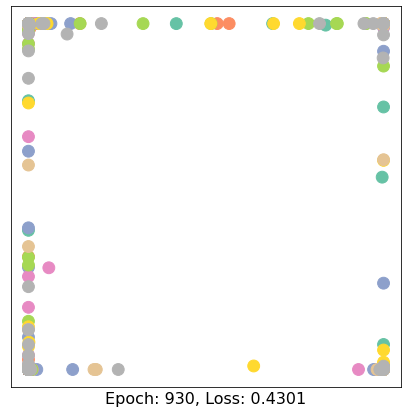

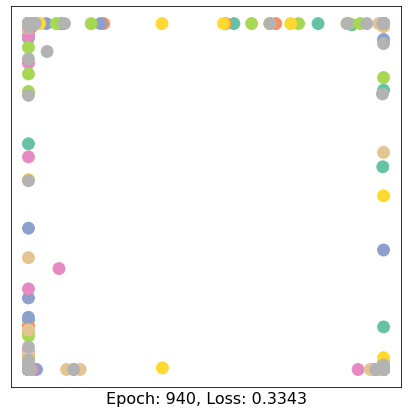

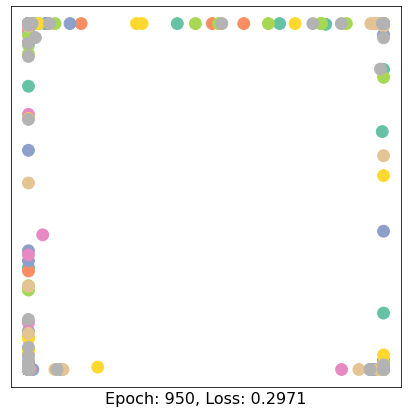

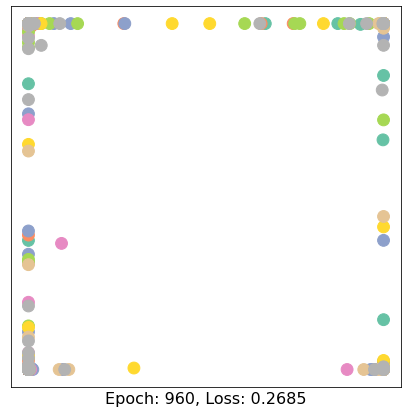

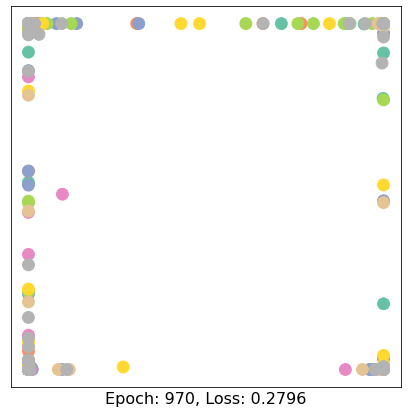

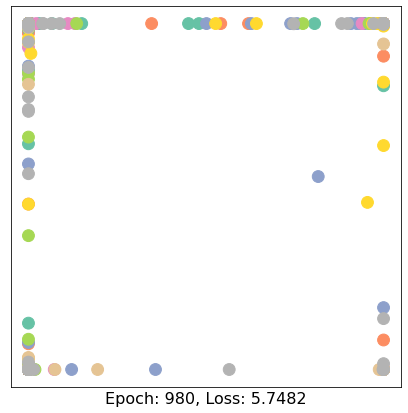

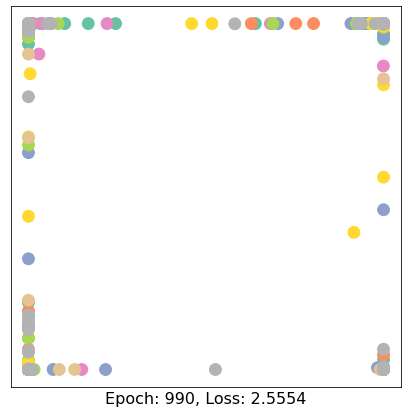

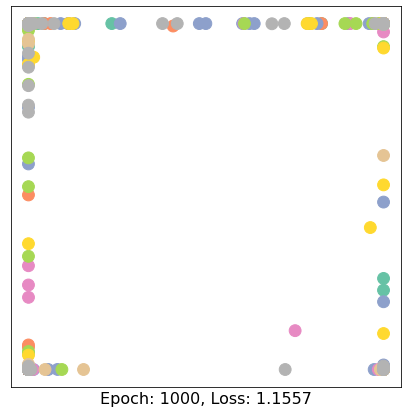

In [54]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN(FaceTensor)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

for epoch in range(1001):
    loss, h = train(FaceData)
    if epoch % 10 == 0:
        visualize(h, color=FaceData.y, epoch=epoch, loss=loss)
        time.sleep(0.3)